# Notes: You will have to:
  >1- Make a Copy of this notebook to edit it for your solutions;
  >
  >2- Upload on Gradescope: The `Colab Notebook edited with your solutions`, and a `pdf Report` with:
  >
   >>- All plots from experiments
   >>- Written interpretations and analyses
   >>- Summary tables.

# Question 1: xLSTM - Extended Long Short-Term Memory and Long-Sequence Generalization [50 points]


This question is divided into five parts. Please read carefully and follow all implementation and reporting instructions.

**Note:** Detailed instructions is provided in the HW PDF document.

## Section: Imports

In [1]:
import torch
from torch.nn.functional import logsigmoid
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict
from tqdm import tqdm

## Part 1.1: Exponential Gates [8 points]

In [2]:
class ExponentialGates(nn.Module):
    """
    ExponentialGates module.

    Core building block of xLSTM introducing exponential gating for
    better gradient flow over long sequences. A stabilizer state (m_t)
    ensures numerical stability by tracking maximum gate activations.

    The module supports two modes:
        - Exponential gating with stabilizer (xLSTM)
        - Standard sigmoid gating (for baseline/ablation)

    Returns:
        new_states: torch.Tensor [4, batch_size, hidden_size]
            (h_t, c_t, n_t, m_t)
        gates: torch.Tensor [4, batch_size, hidden_size]
            (input_gate, forget_gate, cell_input, output_gate)
    """

    def __init__(self, hidden_size: int, use_exponential: bool = True):
        """
        Args:
            hidden_size: int
                Dimensionality of the hidden representation.
            use_exponential: bool
                If True, use exponential gating with stabilizer.
                If False, use standard sigmoid gating.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.use_exponential = use_exponential

        # TODO: define linear projections for the four gates
        # Each projection maps hidden_size → hidden_size and corresponds to:
        #   - Input gate: input_gate_proj
        #   - Forget gate: forget_gate_proj
        #   - Cell input (update): cell_input_proj
        #   - Output gate: output_gate_proj
        # pass  # YOUR CODE HERE
        self.input_gate_proj = nn.Linear(hidden_size, hidden_size)
        self.forget_gate_proj = nn.Linear(hidden_size, hidden_size)
        self.cell_input_proj = nn.Linear(hidden_size, hidden_size)
        self.output_gate_proj = nn.Linear(hidden_size, hidden_size)
        # --------------------------------------------------------------------------
        # Note:
        # The linear layers and the .forward() method below are for Part 1.1 only,
        # allowing ExponentialGates to be tested as a standalone module.
        # In the full sLSTM/xLSTM architecture, the gate projections are handled
        # by the sLSTMLayer; only the pointwise_* methods are used during training.
        # --------------------------------------------------------------------------


    def forward_pointwise_exp(self, Wx, Ry, b, states, constants):
        """
        Exponential gating path (stabilized).

        Uses stabilized exponential gates (i'_t, f'_t) computed with the
        stabilizer state m_t. Updates the memory (c_t) and normalizer (n_t)
        following the equations provided in the handout.

        Args:
            Wx: torch.Tensor [batch_size, 4 * hidden_size]
                Input projections for all gates.
            Ry: torch.Tensor [batch_size, 4 * hidden_size]
                Recurrent contributions from h_{t-1}.
            b: torch.Tensor [1, 4 * hidden_size]
                Bias term for all gates.
            states: torch.Tensor [4, batch_size, hidden_size]
                Previous recurrent states (h_{t-1}, c_{t-1}, n_{t-1}, m_{t-1}).
            constants: dict
                Placeholder for optional constants (kept for interface consistency).

        Returns:
            new_states: torch.Tensor [4, batch_size, hidden_size]
                Updated states (h_t, c_t, n_t, m_t).
            gates: torch.Tensor [4, batch_size, hidden_size]
                Gate activations (input, forget, cell_input, output).
        """
        # pass  # YOUR CODE HERE
        h_prev, c_prev, n_prev, m_prev = states
        # print("x:", Wx.shape, "h_prev:", h_prev.shape)
        gates = Wx + Ry + b
        i_t, f_t, z_t, o_t = gates.chunk(4, dim=-1)

        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        z_t = torch.tanh(z_t)
        o_t = torch.sigmoid(o_t)
        m_t = torch.maximum(torch.log(f_t + 1e-8) + m_prev,
                            torch.log(i_t + 1e-8))

        i_t_prime = torch.exp(torch.log(i_t + 1e-8) - m_t)
        f_t_prime = torch.exp(torch.log(f_t + 1e-8) + m_prev - m_t)

        c_t = f_t_prime * c_prev + i_t_prime * z_t
        n_t = f_t_prime * n_prev + i_t_prime

        h_t = o_t * (c_t / (n_t + 1e-8)) #torch.tanh(c_t)

        new_states = torch.stack([h_t, c_t, n_t, m_t], dim=0)
        gates = torch.stack([i_t_prime, f_t_prime, z_t, o_t], dim=0)


        return new_states, gates


    def forward_pointwise_sigmoid(self, Wx, Ry, b, states, constants):
        """
        Sigmoid gating path (standard LSTM).

        Implements the classical LSTM update using sigmoid and tanh gates.
        Provided for comparison and ablation studies.

        Args:
            Wx, Ry, b, states, constants: same as forward_pointwise_exp().

        Returns:
            new_states: torch.Tensor [4, batch_size, hidden_size]
                (h_t, c_t, n_t, m_t) — n_t and m_t act as placeholders here.
            gates: torch.Tensor [4, batch_size, hidden_size]
                (input_gate, forget_gate, cell_input, output_gate).
        """
        # pass  # YOUR CODE HERE
        h_prev, c_prev, n_prev, m_prev = states

        gates = Wx + Ry + b
        i_t, f_t, z_t, o_t = gates.chunk(4, dim=-1)

        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        z_t = torch.tanh(z_t)
        o_t = torch.sigmoid(o_t)

        c_t = f_t * c_prev + i_t * z_t
        h_t = o_t * torch.tanh(c_t)

        n_t = n_prev
        m_t = m_prev

        new_states = torch.stack([h_t, c_t, n_t, m_t], dim=0)
        gates = torch.stack([i_t, f_t, z_t, o_t], dim=0)

        return new_states, gates

    def forward(self, x_t, h_prev, states):
        """
        Main forward interface for one timestep.

        Steps:
            1. Compute linear projections for all gates from x_t.
            2. Prepare recurrent contributions from h_prev and add biases.
            3. Depending on `use_exponential`, call:
                   - forward_pointwise_exp(...)  → stabilized exponential gates
                   - forward_pointwise_sigmoid(...) → standard LSTM gates
            4. Return the new states and gate activations.

        Args:
            x_t: torch.Tensor [batch_size, hidden_size]
                Input at time step t.
            h_prev: torch.Tensor [batch_size, hidden_size]
                Previous hidden state h_{t-1}.
            states: torch.Tensor [4, batch_size, hidden_size]
                Previous states (h, c, n, m).

        Returns:
            new_states: torch.Tensor [4, batch_size, hidden_size]
            gates: torch.Tensor [4, batch_size, hidden_size]
        """
        # pass  # YOUR CODE HERE
        Wx_i = self.input_gate_proj(x_t)
        Wx_f = self.forget_gate_proj(x_t)
        Wx_z = self.cell_input_proj(x_t)
        Wx_o = self.output_gate_proj(x_t)
        Wx = torch.cat([Wx_i, Wx_f, Wx_z, Wx_o], dim=-1)

        Ry_i = self.input_gate_proj(h_prev)
        Ry_f = self.forget_gate_proj(h_prev)
        Ry_z = self.cell_input_proj(h_prev)
        Ry_o = self.output_gate_proj(h_prev)
        Ry = torch.cat([Ry_i, Ry_f, Ry_z, Ry_o], dim=-1)

        b = torch.cat([
            self.input_gate_proj.bias,
            self.forget_gate_proj.bias,
            self.cell_input_proj.bias,
            self.output_gate_proj.bias
        ]).unsqueeze(0)

        constants = {}
        if self.use_exponential:
            new_states, gates = self.forward_pointwise_exp(Wx, Ry, b, states, constants)
        else:
            new_states, gates = self.forward_pointwise_sigmoid(Wx, Ry, b, states, constants)

        return new_states, gates


## Part 1.2 – sLSTM: Scalar Memory Architecture [8 points]



### Part 1.2.1 sLSTMCell

In [3]:
class sLSTMCell(nn.Module):
    """
    Core scalar-memory LSTM cell (sLSTM).

    Implements the scalar-memory recurrence defined in the handout:
        c_t = f'_t * c_{t-1} + i'_t * tanh(z_t)
        n_t = f'_t * n_{t-1} + i'_t
        h_t = o_t * (c_t / n_t)

    The exponential gates (i'_t, f'_t) are stabilized using the ExponentialGates
    module with the stabilizer state m_t. The cell maintains four internal states
    (h_t, c_t, n_t, m_t) and supports exponential or sigmoid gating.
    """

    def __init__(self, hidden_size: int, use_exponential: bool = True):
        """
        Args:
            hidden_size: int
                Dimensionality of the hidden representation.
            use_exponential: bool
                If True, use exponential gating with stabilizer (xLSTM).
                If False, use standard sigmoid gating (baseline).
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.use_exponential = use_exponential

        # TODO: define parameters for the sLSTM recurrence
        # Include recurrent weights and biases for the four gates.
        # A positive forget gate bias helps with stable training.
        # Vous devez définir
        # R (nn.Parameter): Matrice de poids récurrente (1, 4*hidden_size, hidden_size)
        # b (nn.Parameter): Vecteur de biais (4*hidden_size,)
        # gates (ExponentialGates): Module de calcul des portes

        # with torch.no_grad():
        #     # Set positive bias for forget gate (positions 1, 5, 9, ... in chunks of 4)
        #     self.b[1::4] = 1.0  # Forget gate bias
        self.R = nn.Parameter(torch.randn(1, 4 * hidden_size, hidden_size))
        self.b = nn.Parameter(torch.zeros(4 * hidden_size))
        with torch.no_grad():
            self.b[1::4] = 1.0

        self.gates = ExponentialGates(hidden_size, use_exponential)



    def forward_sequence(self, x, states, pointwise_forward):
        """
        Robust forward_sequence that accepts:
        - x: either a tensor [seq_len, batch, 4H] OR a tuple/list of 4 tensors
        - states: either tensor [4, batch, H] or tuple/list (h,c,n,m)
        Returns:
        states_all: tensor [4, seq_len+1, batch, H]
        final_state: tensor [4, batch, H]
        gates: tensor [seq_len, 4, batch, H]
        """
        if isinstance(states, (tuple, list)):
            states = torch.stack(states, dim=0)
        if isinstance(x, (tuple, list)):
            parts = list(x)
            p0 = parts[0]
            if p0.ndim != 3:
                raise ValueError("Each gate part must be 3D tensor [B,T,H] or [T,B,H]")
            if p0.shape[0] == self.hidden_size:  # unlikely, defensive
                pass
            if parts[0].shape[0] != parts[0].shape[1] and parts[0].shape[2] == self.hidden_size:
                # ambiguous test, safer approach: if any part shape[2]==H, we check which dim matches H.
                # We'll standardize by checking if parts[0].shape[2] == H (last dim)
                pass

            p = parts[0]
            if p.shape[2] == self.hidden_size:
                batch_major_parts = parts
            else:

                batch_major_parts = [pp.transpose(0,1) for pp in parts]

            x = torch.cat(batch_major_parts, dim=-1)

        if not torch.is_tensor(x):
            raise TypeError(f"forward_sequence expected tensor x but got {type(x)}")

        if x.ndim != 3:
            raise ValueError(f"forward_sequence expected 3D x but got shape {x.shape}")

        B = None
        T = None
        if x.shape[2] == 4 * self.hidden_size:
            B, T, _ = x.shape
            x_time_major = x.transpose(0, 1) 
        elif x.shape[1] == 4 * self.hidden_size:
            x_time_major = x
            T, B, _ = x_time_major.shape
        else:
            raise ValueError(f"forward_sequence expected last or middle dim to be 4*H, got {x.shape} and H={self.hidden_size}")

        if not torch.is_tensor(states) or states.ndim != 3 or states.shape[0] != 4:
            raise ValueError("states must be tensor [4, B, H] after normalization")

        seq_len = x_time_major.shape[0]

        states_all = [states]
        gates_all = []

        for t in range(seq_len):
            h_prev = states[0]

            Ry_t = h_prev @ self.R[0].T 

            # Compute new states and gates
            new_states, gates_t = pointwise_forward(
                Wx=x_time_major[t],  
                Ry=Ry_t,             
                b=self.b.unsqueeze(0),        
                states=states,
                constants=None
            )

            if isinstance(new_states, (tuple, list)):
                new_states = torch.stack(new_states, dim=0)

            states_all.append(new_states)
            gates_all.append(gates_t)

            states = new_states

        states_all = torch.stack(states_all, dim=1)
        gates_all = torch.stack(gates_all, dim=0)

        final_state = states 
        return states_all, final_state, gates_all


    def forward(self, x, state=None):
        """
        Robust forward that accepts:
        - x: tensor [B,T,4H] or [T,B,4H] or tuple/list of 4 tensors
        - state: None, tensor [4,B,H], or tuple/list (h,c,n,m)
        Returns:
        output_seq: [B,T,H]
        final_state: tensor [4,B,H]
        """

        if isinstance(x, (tuple, list)):
            parts = list(x)
            if parts[0].ndim != 3:
                raise ValueError("Each gate part must be 3D")

            p0 = parts[0]
            if p0.shape[2] == self.hidden_size:

                parts_b = parts
            else:
                parts_b = [pp.transpose(0,1) for pp in parts]
            x = torch.cat(parts_b, dim=-1)

        if not torch.is_tensor(x):
            raise TypeError(f"sLSTMCell expected tensor input but got {type(x)}")
        if x.ndim != 3:
            raise ValueError(f"sLSTMCell expected [B,T,4H] or [T,B,4H], got shape {x.shape}")

        if x.shape[2] == 4 * self.hidden_size:
            B, T, _ = x.shape
        elif x.shape[1] == 4 * self.hidden_size:
            x = x.transpose(0,1)
            B, T, _ = x.shape
        else:
            raise ValueError(f"sLSTMCell expected 4*H in either middle or last dim; got {x.shape}")

        H = self.hidden_size

        if state is None:
            h = x.new_zeros(B, H)
            c = x.new_zeros(B, H)
            n = x.new_zeros(B, H)
            m = x.new_zeros(B, H)
        else:
            if isinstance(state, torch.Tensor):
                if state.ndim != 3 or state.shape[0] != 4:
                    raise ValueError("state tensor must be [4, B, H]")
                h, c, n, m = state[0], state[1], state[2], state[3]
            elif isinstance(state, (tuple, list)):
                if len(state) != 4:
                    raise ValueError("state tuple must have 4 elements")
                h, c, n, m = state
            else:
                raise TypeError("state must be None, tensor [4,B,H], or tuple/list of 4 tensors")

        outputs = []
        for t in range(T):
            gates_t = x[:, t]
            i, f, z, o = gates_t.split(H, dim=-1)
            i = torch.sigmoid(i)
            f = torch.sigmoid(f)
            z = torch.tanh(z)
            o = torch.sigmoid(o)
            c = f * c + i * z
            n = torch.tanh(c)
            h = o * n

            outputs.append(h)

        if T > 0:
            output_seq = torch.stack(outputs, dim=1)
        else:
            output_seq = x.new_zeros(B, 0, H)

        final_state = torch.stack([h, c, n, m], dim=0)
        return output_seq, final_state


### Part 1.2.2 – sLSTMLayer: High-Level Sequence Processor

In [4]:
class sLSTMLayer(nn.Module):

    """
    High-level sequence processor built on top of sLSTMCell.

    Applies the sLSTM recurrence across time for input sequences of shape [B, T, H]:
        h_t, (h, c, n, m) = sLSTMCell(x_t, h_{t-1}, states)
    Returns the full hidden sequence and final states.
    """
    def __init__(self, hidden_size: int, dropout_prob: float = 0.1, use_exponential: bool = True):
        """
        Args:
            hidden_size: int
                Dimensionality of the hidden representation.
            dropout_prob: float
                Dropout probability applied to the output sequence.
            use_exponential: bool
                If True, use exponential gating (xLSTM mode).
                If False, use standard sigmoid gating (baseline).
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_prob)
        self.W = nn.Linear(hidden_size, 4 * hidden_size)

        self.cell = sLSTMCell(hidden_size, use_exponential)

    def forward(self, x, initial_state=None):
        """
        Forward pass of sLSTM layer for batch processing.

        Args:
            x: Input tensor [batch_size, seq_len, hidden_size]

        Returns:
            output: Output tensor [batch_size, seq_len, hidden_size]
        """
        
        Wx = self.W(x)
        output, _ = self.cell(Wx, initial_state)
        output = self.dropout(output)
        return  output




## **Part 1.3 – xLSTM Block and Stack [8 points]**

In this section, we assemble full **xLSTM layers** by combining the previously implemented components into Transformer-style residual blocks.

The code below already provides:
- **LayerNorm** with residual weighting — ensures numerical stability during deep stacking. *(No edits required.)*
- **GatedMLP** using GeLU activation and a projection factor of 4/3. *(No edits required.)*

You will complete:
- **xLSTMBlock** — one residual block that wraps:
  1. LayerNorm → sLSTM layer → first residual connection  
  2. LayerNorm → GatedMLP → second residual connection  
  The block should return the final tensor after both residuals.

- **xLSTM** — a stack of multiple xLSTMBlocks that processes entire sequences in parallel.  
  It should loop over the configured number of layers and apply each block sequentially.

Follow the structure and equations described in the handout.



In [5]:
class LayerNorm(nn.Module):
    """Layer normalization with residual weight mechanism (important for xLSTM stability)."""
    def __init__(self, hidden_size: int):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.eps = 1e-5

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        weight_proxy = 1.0 + self.weight
        return torch.nn.functional.layer_norm(x, normalized_shape=(x.shape[-1],),
                                           weight=weight_proxy, bias=self.bias, eps=self.eps)


class GatedMLP(nn.Module):
    """Gated MLP with GeLU activation and projection factor 4/3."""
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.projection_factor = 4 / 3
        self.inner_size = int(hidden_size * self.projection_factor)

        self.up_proj = nn.Linear(hidden_size, self.inner_size)
        self.down_proj = nn.Linear(self.inner_size, hidden_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down_proj(torch.nn.functional.gelu(self.up_proj(x)))


In [6]:
class xLSTMBlock(nn.Module):
    """
    One residual block of the xLSTM architecture.

    Each block follows:
        h₁ = sLSTMLayer(LayerNorm(x))
        x₁ = x + h₁
        h₂ = GeLU(W_up * LayerNorm(x₁))
        x₂ = x₁ + W_down * h₂

    Combines recurrent memory updates (via sLSTM) and gated feed-forward
    processing within dual residual connections.
    """

    def __init__(self, hidden_size: int, dropout_prob: float = 0.1, use_exponential: bool = True):
        """
        Args:
            hidden_size: int
                Dimensionality of the hidden representation.
            use_exponential: bool
                Whether to use exponential gating (xLSTM) or sigmoid gating (baseline).
        """
        super().__init__()
        # pass  # YOUR CODE HERE
        self.layer_norm = LayerNorm(hidden_size)
        self.slstm = sLSTMLayer(hidden_size=hidden_size,dropout_prob=dropout_prob, use_exponential=use_exponential)
        self.mlp_norm = LayerNorm(hidden_size)
        self.gated_mlp = GatedMLP(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden_size = hidden_size


    def forward(self, x):
        """
        Forward pass of xLSTM block for batch processing.

        Args:
            x: Input tensor [batch_size, seq_len, hidden_size]

        Returns:
            output: Output tensor [batch_size, seq_len, hidden_size]
        """
        # pass  # YOUR CODE HERE

        x_norm = self.layer_norm(x)
        h1 = self.slstm(x_norm)
        x1 = x + h1
        x1_norm = self.mlp_norm(x1)
        h2 = self.gated_mlp(x1_norm)
        output = x1 + h2
        return output




In [7]:
class xLSTM(nn.Module):
    """
    Full xLSTM stack of L residual blocks.

    Applies the recurrence:
        x ← xLSTMBlock₁(x)
        ...
        x ← xLSTMBlock_L(x)

    Args:
        d: Hidden dimension.
        num_layers: Number of stacked xLSTM blocks.
        dropout_prob: Dropout probability.
    """

    def __init__(self, hidden_size: int = 64, num_layers: int = 4, dropout_prob: float = 0.1, use_exponential: bool = True):
        """
        Args:
            hidden_size: int
                Dimensionality of the hidden representation.
            num_layers: int
                Number of stacked xLSTM blocks.
            use_exponential: bool
                If True, use exponential gating (xLSTM mode).
                If False, use standard sigmoid gating (baseline).
        """
        super().__init__()
        # TODO: create list of xLSTMBlock modules
        # pass  # YOUR CODE HERE
        self.input_proj = nn.LazyLinear(hidden_size)
        self.layers = nn.ModuleList([
            xLSTMBlock(hidden_size=hidden_size, dropout_prob=dropout_prob, use_exponential=use_exponential)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden_size = hidden_size

    def forward(self, x):
        """
        Forward pass through all blocks with true batch processing.

        Args:
            x: Input tensor [batch_size, seq_len, hidden_size]

        Returns:
            output: Final output [batch_size, seq_len, hidden_size]
        """
        # pass  # YOUR CODE HERE
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)

        return x

## Part 1.4 –  xLSTM Training on the Parity Task [6 points]

In this part, you will train and evaluate your **xLSTM implementation** on a synthetic *parity task* that tests the model’s ability to capture **long-range dependencies**.

Several helper components are provided to make experimentation easier:

- **ParityDataset** – Generates binary sequences and corresponding parity labels for both training and testing. *(No modifications required.)*  
- **ModelFactory** – Creates and configures different model types (xLSTM-Exp, xLSTM-Sigmoid, and Vanilla LSTM). *(No modifications required.)*  
- **ModelTrainer** – Implements batching, optimization, and evaluation.  
  ➜ *You will complete this section.*  
- **ExperimentRunner** – Manages the full training and evaluation pipeline, connecting all components together. *(No modifications required.)*

Your goal in this part is to **complete the missing code in `ModelTrainer`** and verify that your models from previous parts can successfully learn and generalize on the parity dataset.


### Parity Dataset (No Modifications Required)





In [8]:
# ParityDataset: Complete implementation provided - handles the generation of the parity dataset.
# No modifications required.
class ParityDataset:
    """Parity dataset with variable-length training and generalization testing."""

    def __init__(self, max_length: int, num_samples: int = 1000,
                 variable_length: bool = True, test_range: tuple = None):
        """
        Args:
            max_length: Maximum training length (for variable-length sequences).
            num_samples: Number of samples to generate.
            variable_length: Whether to randomly sample sequence lengths (for training/test).
            test_range: Tuple (min_len, max_len) for generalization test (e.g., (40, 256)).
        """
        self.max_length = max_length
        self.num_samples = num_samples
        self.variable_length = variable_length
        self.test_range = test_range

    def generate_sequence(self, length: int) -> Tuple[torch.Tensor, int]:
        seq = torch.randint(0, 2, (length,))
        parity = seq.sum().item() % 2
        return seq.float(), parity

    def create_dataset(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Create padded dataset with mask for variable-length sequences."""
        sequences, labels, lengths = [], [], []

        for _ in range(self.num_samples):
            if self.test_range:
                # Test mode: sample random length from generalization range
                length = np.random.randint(self.test_range[0], self.test_range[1] + 1)
            elif self.variable_length:
                # Training or in-distribution test: sample 1–max_length
                length = np.random.randint(1, self.max_length + 1)
            else:
                # Fixed-length case
                length = self.max_length

            seq, label = self.generate_sequence(length)
            sequences.append(seq)
            labels.append(label)
            lengths.append(length)

        max_len = max(lengths)
        padded_sequences = torch.zeros(self.num_samples, max_len)
        mask = torch.zeros_like(padded_sequences)

        for i, seq in enumerate(sequences):
            padded_sequences[i, :len(seq)] = seq
            mask[i, :len(seq)] = 1  # mark valid positions

        return padded_sequences, torch.tensor(labels), mask

### Model Factory (No Modifications Required)





In [9]:
# ModelFactory: Complete implementation provided - handles the creation of different model types.
# including model creation. No modifications required.
class ModelFactory:
    """Factory for creating different model types."""

    def __init__(self, config: dict):
        self.config = config

    def create_xlstm_exp(self) -> xLSTM:
        """Create xLSTM with exponential gates."""
        model = xLSTM(self.config['hidden_size'], self.config['num_layers'], use_exponential=True)
        model.input_proj = nn.Linear(1, self.config['hidden_size'])  # Project binary input to hidden_size
        model.classifier = nn.Linear(self.config['hidden_size'], 2)
        return model

    def create_xlstm_sigmoid(self) -> xLSTM:
        """Create xLSTM with sigmoid gates."""
        model = xLSTM(self.config['hidden_size'], self.config['num_layers'], use_exponential=False)
        model.input_proj = nn.Linear(1, self.config['hidden_size'])  # Project binary input to hidden_size
        model.classifier = nn.Linear(self.config['hidden_size'], 2)
        return model

    def create_vanilla_lstm(self) -> nn.Module:
        """Create vanilla LSTM baseline."""
        model = nn.LSTM(self.config['hidden_size'], self.config['hidden_size'],
                       self.config['num_layers'], batch_first=True)
        model.input_proj = nn.Linear(1, self.config['hidden_size'])  # Project binary input to hidden_size
        model.classifier = nn.Linear(self.config['hidden_size'], 2)
        model.hidden_size = self.config['hidden_size']  # Add for compatibility
        return model

    def create_all_models(self) -> dict:
        """Create all models for comparison."""
        return {
            'xLSTM (Exponential)': self.create_xlstm_exp(),
            'xLSTM (Sigmoid)': self.create_xlstm_sigmoid(),
            'Vanilla LSTM': self.create_vanilla_lstm()
        }

### Model Training and Evaluation

In [10]:
from pyexpat import model


class ModelTrainer:
    """Handles training and evaluation of models (with masking support)."""

    def __init__(self, batch_size: int = 256, lr: float = 0.001):
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

    def train_model(self, model: nn.Module, train_data: tuple, epochs: int = 10):
        """
        Generic training loop supporting padding masks.

        Expects:
            train_data = (sequences, labels, masks)
        """
        sequences, labels, masks = train_data
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr, weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        model = model.to(self.device)
        sequences, labels, masks = (
            sequences.to(self.device),
            labels.to(self.device),
            masks.to(self.device),
        )

        losses_per_epoch = []

        for epoch in range(epochs):
            model.train()
            total_loss, correct = 0.0, 0

            for batch_start in range(0, len(sequences), self.batch_size):
                batch_end = min(batch_start + self.batch_size, len(sequences))
                x = sequences[batch_start:batch_end]
                # print("shape of x", x.shape)
                y = labels[batch_start:batch_end]
                m = masks[batch_start:batch_end]

                optimizer.zero_grad()
                if isinstance(model, xLSTM):
                    if x.ndim == 2:     # only if truly needed
                        x = x.unsqueeze(-1)

                    out = model(x)

                    # choose last non-padded timestep
                    seq_lens = (m.sum(dim=1) - 1).long()
                    out = out[torch.arange(len(out), device=out.device), seq_lens]

                    logits = model.classifier(out)
                else:
                    if x.ndim == 2:
                        x = x.unsqueeze(-1)           # [B, T, 1]

                    x_in = model.input_proj(x)        # [B, T, hidden]
                    output, (_, _) = model(x_in) # underlying LSTM
                    seq_lens = (m.sum(dim=1) - 1).long()
                    out = output[torch.arange(len(output)), seq_lens]
                    logits = model.classifier(out)
                    
                loss = criterion(logits, y)
                loss.backward()
                optimizer.step()
            
                total_loss += loss.item()
                correct += (logits.argmax(dim=1) == y).sum().item()
            scheduler.step()
            avg_loss = total_loss / (len(sequences) // self.batch_size + 1)
            acc = correct / len(sequences)
            losses_per_epoch.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs} — Loss: {avg_loss:.4f}, Acc: {acc:.4f}")

        return losses_per_epoch

    def evaluate_model(self, model: nn.Module, test_data: tuple) -> float:
        """
        Evaluation loop with padding mask support.
        """
        sequences, labels, masks = test_data
        model = model.to(self.device)
        sequences, labels, masks = (
            sequences.to(self.device),
            labels.to(self.device),
            masks.to(self.device),
        )

        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_start in range(0, len(sequences), self.batch_size):
                batch_end = min(batch_start + self.batch_size, len(sequences))
                x = sequences[batch_start:batch_end]
                y = labels[batch_start:batch_end]
                m = masks[batch_start:batch_end]

                # Forward pass — implement your model call here
                # Example: logits = model(x, m)
                # ---------------------------------
                # YOUR CODE HERE
                
                if isinstance(model, xLSTM):
                    if x.ndim == 2:     # only if truly needed
                        x = x.unsqueeze(-1)

                    out = model(x)

                    # choose last non-padded timestep
                    seq_lens = (m.sum(dim=1) - 1).long()
                    out = out[torch.arange(len(out), device=out.device), seq_lens]

                    logits = model.classifier(out)
                else:
                    if x.ndim == 2:
                        x = x.unsqueeze(-1)           # [B, T, 1]

                    x_in = model.input_proj(x)        # [B, T, hidden]
                    output, (_, _) = model(x_in) # underlying LSTM
                    seq_lens = (m.sum(dim=1) - 1).long()
                    out = output[torch.arange(len(output)), seq_lens]
                    logits = model.classifier(out)
                # logits = model(x)
                correct += (logits.argmax(dim=1) == y).sum().item()

        return correct / len(sequences)


### Experiment Runner (No Modifications Required)

In [11]:
# ExperimentRunner: Complete implementation provided - handles the full experiment pipeline
# including model testing, training, and evaluation. No modifications required.
class ExperimentRunner:
    """Runs the complete experiment pipeline."""

    def __init__(self, config: dict):
        self.config = config
        self.model_factory = ModelFactory(config)
        self.trainer = ModelTrainer(
            batch_size=config.get('batch_size', 256),
            lr=config.get('learning_rate', 1e-3)
        )

    def test_exponential_gates(self):
        """Test Part 1.1: ExponentialGates implementation."""
        print("Testing ExponentialGates...")

        # Create gates
        gates_exp = ExponentialGates(self.config['hidden_size'], use_exponential=True)
        gates_sigmoid = ExponentialGates(self.config['hidden_size'], use_exponential=False)

        # Test data
        batch_size = 4
        x_t = torch.randn(batch_size, self.config['hidden_size'])
        h_prev = torch.randn(batch_size, self.config['hidden_size'])
        states = torch.randn(4, batch_size, self.config['hidden_size'])

        # Test exponential gates
        new_states_exp, gates_exp_vals = gates_exp(x_t, h_prev, states)
        print(f"✅ Exponential gates output shape: {new_states_exp.shape}")

        # Test sigmoid gates
        new_states_sigmoid, gates_sigmoid_vals = gates_sigmoid(x_t, h_prev, states)
        print(f"✅ Sigmoid gates output shape: {new_states_sigmoid.shape}")

        print("✅ Part 1.1: ExponentialGates working correctly!")

    def test_slstm_cell(self):
        """Test Part 1.2: sLSTMCell implementation."""
        print("Testing sLSTMCell...")

        # Create sLSTM cell
        slstm = sLSTMCell(self.config['hidden_size'], use_exponential=True)

        # Test data
        batch_size = 4
        seq_len = 10
        x = torch.randn(batch_size, seq_len, 4 * self.config['hidden_size'])  # Concatenated gates

        # Test forward pass
        output, final_state = slstm(x)
        print(f"✅ sLSTM output shape: {output.shape}")
        print(f"✅ sLSTM final state shape: {final_state.shape}")

        print("✅ Part 1.2: sLSTMCell working correctly!")

    def test_xlstm_architecture(self):
        """Test Part 1.3: xLSTM Block and Stack."""
        print("Testing xLSTM architecture...")

        # Create xLSTM
        xlstm = xLSTM(self.config['hidden_size'], self.config['num_layers'], use_exponential=True)

        # Test data
        batch_size = 4
        seq_len = 10
        x = torch.randn(batch_size, seq_len, self.config['hidden_size'])

        # Test forward pass (batch processing)
        output = xlstm(x)
        print(f"✅ xLSTM output shape: {output.shape}")

        print("✅ Part 1.3: xLSTM architecture working correctly!")


    # -------------------------------------------------------------------------
    # 2. Main Experiment Flow
    # -------------------------------------------------------------------------
    def run_experiment(self):
        """Run complete training and evaluation experiment."""
        print("Running complete experiment...")

        # === Datasets ===
        print("Preparing datasets...")
        # Training: variable 1–40
        train_dataset = ParityDataset(
            max_length=self.config['train_length'],
            num_samples=self.config['num_samples'],
            variable_length=True
        )
        train_data = train_dataset.create_dataset()

        # IID test: 1–40
        test_id_dataset = ParityDataset(
            max_length=self.config['train_length'],
            num_samples=1000,
            variable_length=True
        )
        test_id_data = test_id_dataset.create_dataset()

        # Generalization test: 40–256
        test_ood_dataset = ParityDataset(
            max_length=self.config['test_max_length'],
            num_samples=1000,
            variable_length=False,
            test_range=(40, 256)
        )
        test_ood_data = test_ood_dataset.create_dataset()

        # === Models ===
        models = self.model_factory.create_all_models()

        # === Training ===
        loss_histories = {}
        for name, model in models.items():
            print(f"\nTraining {name}...")
            loss_history = self.trainer.train_model(model, train_data, self.config['epochs'])
            loss_histories[name] = loss_history

        # === Evaluation & Analysis ===
        self.analyze_results(models, loss_histories, test_id_data, test_ood_data)

    # -------------------------------------------------------------------------
    # 3. Unified Analyze Function
    # -------------------------------------------------------------------------
    def analyze_results(self, models: dict, loss_histories: dict,
                        test_id_data: tuple, test_ood_data: tuple):
        """Evaluate all models and generate IID + generalization plots and table."""
        print("\n🔍 Analyzing results...")

        # Evaluate all models
        results = {}
        for name, model in models.items():
            print(f"\nEvaluating {name}...")
            id_acc = self.trainer.evaluate_model(model, test_id_data)
            ood_acc = self.trainer.evaluate_model(model, test_ood_data)
            results[name] = (id_acc, ood_acc)
            print(f"✅ {name}: In-Dist={id_acc:.3f}, Generalization={ood_acc:.3f}")

        # === Plot all results ===
        self.plot_training_loss(loss_histories)
        self.plot_in_distribution_accuracy(results)
        self.plot_generalization_accuracy(results)
        self.create_results_table(results)

    # -------------------------------------------------------------------------
    # 4. Plots & Summary
    # -------------------------------------------------------------------------
    def plot_training_loss(self, loss_histories: dict):
        """Plot training loss over epochs for all models."""
        plt.figure(figsize=(10, 6))
        for name, losses in loss_histories.items():
            plt.plot(range(1, len(losses)+1), losses, marker='o', label=name, markersize=3)
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_in_distribution_accuracy(self, results: dict):
        """Plot in-distribution (1–40) test accuracy for all models."""
        plt.figure(figsize=(8, 6))
        models = list(results.keys())
        id_accs = [results[m][0] for m in models]
        plt.bar(models, id_accs, color='skyblue')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.title('In-Distribution Accuracy (1–40)')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_generalization_accuracy(self, results: dict):
        """Plot generalization (40–256) accuracy for all models."""
        plt.figure(figsize=(8, 6))
        models = list(results.keys())
        ood_accs = [results[m][1] for m in models]
        plt.bar(models, ood_accs, color='lightcoral')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.title('Generalization Accuracy (40–256)')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    def create_results_table(self, results: dict):
        """Print results summary table."""
        print("\n" + "="*70)
        print(f"{'Model':<25}{'In-Distribution (1–40)':<20}{'Generalization (40–256)':<20}")
        print("-"*70)
        for name, (id_acc, ood_acc) in results.items():
            print(f"{name:<25}{id_acc:<20.3f}{ood_acc:<20.3f}")
        print("="*70)

## Part 1.5 Result and Analysis [20 points]

### Training tips
When getting started, try training on a small sample — for example, use num_samples = batch_size (e.g., 64 samples) — just to confirm that your model runs without errors and that the loss decreases. Once things look stable, you can increase the number of epochs and data samples for a full training run.

🚀 xLSTM Assignment Implementation

🖥️  GPU Available: True
   GPU Device: NVIDIA GeForce RTX 4070 Ti
   GPU Memory: 12.88 GB

Configuration: {'hidden_size': 64, 'num_layers': 2, 'train_length': 40, 'test_max_length': 256, 'num_samples': 10000, 'epochs': 20, 'batch_size': 256, 'learning_rate': 0.01, 'weight_decay': 0.0}
Using device: cuda

PART 1.1: Testing ExponentialGates
Testing ExponentialGates...
✅ Exponential gates output shape: torch.Size([4, 4, 64])
✅ Sigmoid gates output shape: torch.Size([4, 4, 64])
✅ Part 1.1: ExponentialGates working correctly!

PART 1.2: Testing sLSTMCell
Testing sLSTMCell...
✅ sLSTM output shape: torch.Size([4, 10, 64])
✅ sLSTM final state shape: torch.Size([4, 4, 64])
✅ Part 1.2: sLSTMCell working correctly!

PART 1.3: Testing xLSTM Architecture
Testing xLSTM architecture...
✅ xLSTM output shape: torch.Size([4, 10, 64])
✅ Part 1.3: xLSTM architecture working correctly!

PART 1.4 & 1.5: Complete Experiment
Running complete experiment...
Preparing datasets.

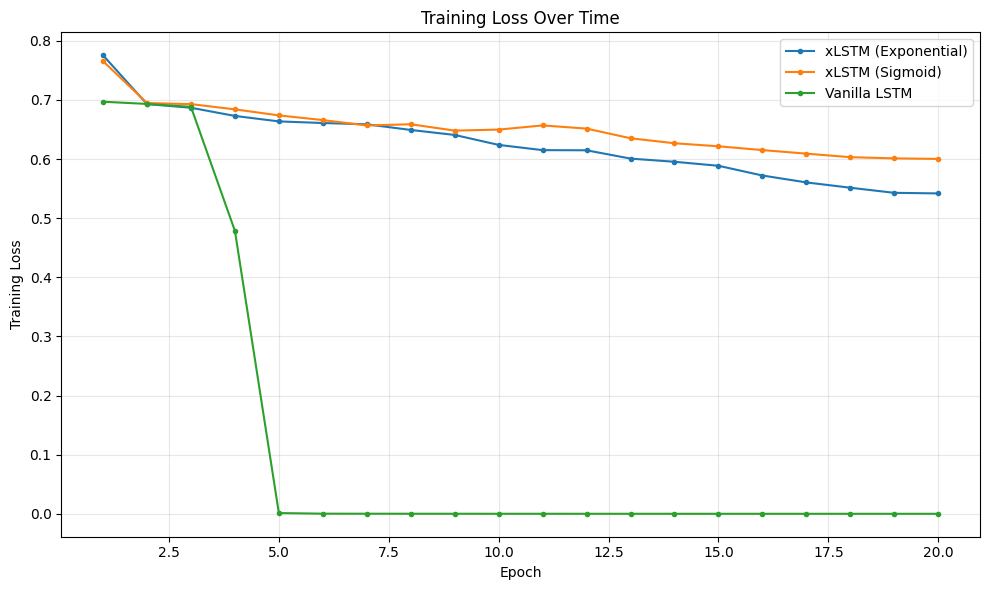

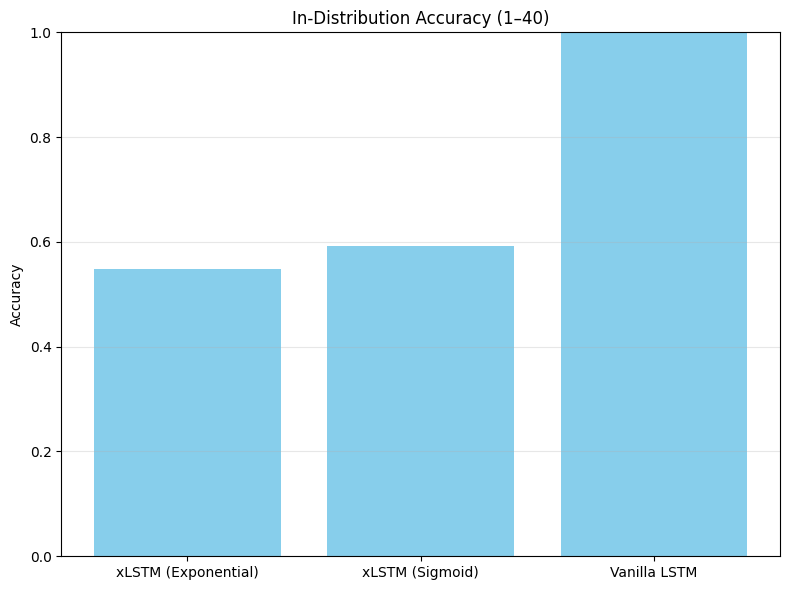

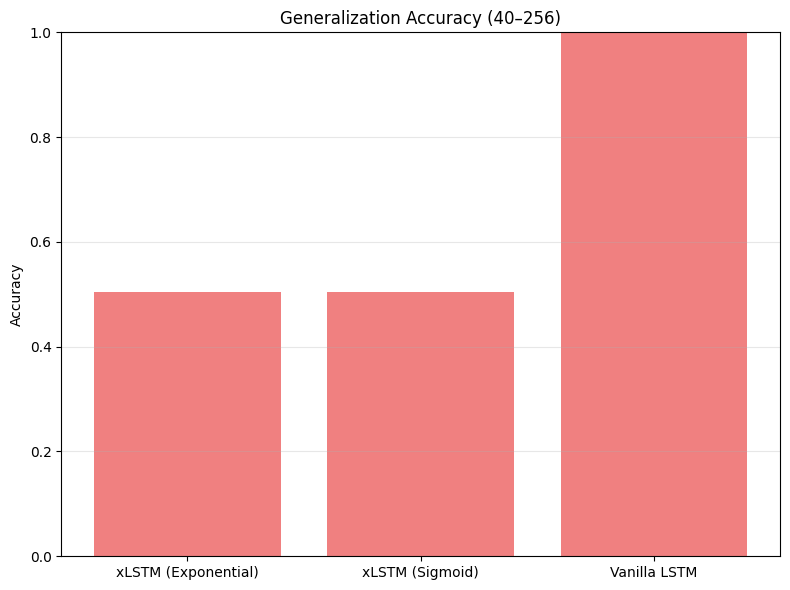


Model                    In-Distribution (1–40)Generalization (40–256)
----------------------------------------------------------------------
xLSTM (Exponential)      0.549               0.504               
xLSTM (Sigmoid)          0.592               0.504               
Vanilla LSTM             1.000               1.000               

✅ HW1 completed successfully!


In [12]:
print("🚀 xLSTM Assignment Implementation")
print("="*50)

# GPU availability check
print(f"\n🖥️  GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print()
config = {
    'hidden_size': 64,
    'num_layers': 2,
    'train_length': 40,        # variable-length 1–40
    'test_max_length': 256,    # generalization test 40–256
    'num_samples': 10000,     # More data for better convergence
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 1e-2,
    'weight_decay': 0.0,     # Add weight decay!
}
print(f"Configuration: {config}")
# Create experiment runner
experiment = ExperimentRunner(config)
# Part 1.1: Test ExponentialGates
print("\n" + "="*50)
print("PART 1.1: Testing ExponentialGates")
print("="*50)
experiment.test_exponential_gates()
# Part 1.2: Test sLSTMCell
print("\n" + "="*50)
print("PART 1.2: Testing sLSTMCell")
print("="*50)
experiment.test_slstm_cell()
# Part 1.3: Test xLSTM Architecture
print("\n" + "="*50)
print("PART 1.3: Testing xLSTM Architecture")
print("="*50)
experiment.test_xlstm_architecture()
# Part 1.4 & 1.5: Run Complete Experiment
print("\n" + "="*50)
print("PART 1.4 & 1.5: Complete Experiment")
print("="*50)
experiment.run_experiment()
print("\n✅ HW1 completed successfully!")

# Question 2: Building a Modern Transformer for Modular Arithmetic [50 points]

In this question, you will implement a state-of-the-art decoder-only transformer architecture from scratch using PyTorch. Your model will learn to perform modular arithmetic operations. Through careful implementation and systematic experimentation, you will gain deep understanding of modern architectural components including RMSNorm, SwiGLU activations, rotary position embeddings (RoPE), and grouped-query attention (GQA). This assignment emphasizes both implementation rigor and experimental methodology.

## Section 0: Setup and Imports

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Optional, Dict
import math
from tqdm import tqdm
import json
import pickle

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Section 1: Core Component Implementations (30 points total)

### 1.1 RMSNorm: Root Mean Square Normalization [3 points]

In [14]:
class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization.

    Paper: "Root Mean Square Layer Normalization" (Zhang & Sennrich, 2019)
    https://arxiv.org/abs/1910.07467

    Key implementation details from paper:
    - RMS(x) = sqrt(mean(x^2) + eps)
    - Output = gamma * (x / RMS(x))
    - No mean centering (unlike LayerNorm)
    - No bias parameter

    Args:
        d: Model dimension
        eps: Small constant for numerical stability (default: 1e-6)
    """
    def __init__(self, d: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps

        # TODO: Create learnable scale parameter initialized to ones
        # Hint: Use nn.Parameter with torch.ones
        # Shape should be (d,)
        # pass  # YOUR CODE HERE
        self.scale = nn.Parameter(torch.ones(d))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor of shape (B, S, d)

        Returns:
            Normalized tensor of shape (B, S, d)
        """
        # pass  # YOUR CODE HERE
        # first step is to do RMS
        rms = torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        x_norm = x * rms * self.scale
        return x_norm
        # Alternative implementation:
        # rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        # x_norm = x / rms
        # return self.scale * x_norm


### 1.2 SwiGLU Feed-Forward Network [3 points]

In [15]:
class FeedForward(nn.Module):
    """
    SwiGLU Feed-Forward Network.

    Paper: "GLU Variants Improve Transformer" (Shazeer, 2020)
    https://arxiv.org/abs/2002.05202

    Key implementation details from paper:
    - FFN_SwiGLU(x) = (Swish(xW1) ⊙ xV) W2
    - Swish(x) = x * sigmoid(x), also known as SiLU
    - Two parallel projections (gate and value)
    - Standard output projection
    - All projections are bias-free

    Args:
        d: Model dimension
        d_ff: Hidden dimension (typically 4*d, or 8d/3 for SwiGLU to match params)
        dropout_prob: Dropout probability
    """
    def __init__(self, d: int, d_ff: int, dropout_prob: float):
        super().__init__()

        # TODO: Define three linear layers (all bias=False)
        # - w_gate: d -> d_ff (gate path, will apply Swish)
        # - w_value: d -> d_ff (value path, stays linear)
        # - w_out: d_ff -> d (output projection)
        # pass  # YOUR CODE HERE
        self.w_gate = nn.Linear(d, d_ff, bias=False)
        self.w_value = nn.Linear(d, d_ff, bias=False)
        self.w_out = nn.Linear(d_ff, d, bias=False)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor of shape (B, S, d)

        Returns:
            Output tensor of shape (B, S, d)
        """
        # pass  # YOUR CODE HERE
        swiglu = self.w_out(torch.nn.functional.silu(self.w_gate(x)) * self.w_value(x))
        # we apply dropout after the output projection because it's common to apply dropout on the output of FFN layers. 
        # The real reason is to prevent overfitting and improve generalization.
        return self.dropout(swiglu)

### 1.3 RoPE: Rotary Position Embeddings [6 points]

In [16]:
from networkx import omega


def rotate_half(t: torch.Tensor) -> torch.Tensor:
    """
    Helper function for RoPE: rotates pairs of elements.

    Paper: "RoFormer: Enhanced Transformer with Rotary Position Embedding" (Su et al., 2021)
    https://arxiv.org/abs/2104.09864

    Transforms [x0, x1, x2, x3, ...] -> [-x1, x0, -x3, x2, ...]
    This implements the rotation matrix in complex number form.

    Args:
        t: Tensor of shape (..., d) where d is even

    Returns:
        Rotated tensor of shape (..., d)
    """
    # pass  # YOUR CODE HERE
    dimension = t.shape[-1]
    assert dimension % 2 == 0, "dimensionimension must be even for rotate_half"
    t1 = []
    for i in range(dimension):
        if i % 2 == 0:
            t1.append(t[..., i])
        else:
            t1.insert(i-1, -1*t[..., i])
    t1 = torch.stack(t1, dim=-1)

    return t1

    


def apply_rope(x: torch.Tensor, positions: torch.Tensor,
               d_rope: Optional[int] = None, theta: float = 10000.0) -> torch.Tensor:
    """
    Apply Rotary Position Embeddings to input tensor.

    Paper details:
    - Rotation angles: theta_j = position * base^(-2j/d_rope)
    - Applied as: x * cos(theta) + rotate_half(x) * sin(theta)
    - Only rotates first d_rope dimensions (partial rotation)
    - Base frequency typically 10000 (for context length ~2048)

    Args:
        x: Input tensor of shape (B, S, H, d_h)
        positions: Position indices of shape (S,)
        d_rope: Dimension to apply rotation (if None, use all d_h)
        theta: Base frequency (default: 10000)

    Returns:
        Rotated tensor of shape (B, S, H, d_h)
    """
    B, S, H, d_h = x.shape

    # Use full dimension if d_rope not specified
    if d_rope is None:
        d_rope = d_h
    assert d_rope <= d_h and d_rope % 2 == 0, "d_rope must be even and <= d_h"

    device = x.device
    
    # TODO: Implement RoPE
    # Step 1: Compute inverse frequencies
    # pass  # YOUR CODE HERE
    omega = theta
    inverse_frequcy = [omega**(-2*j/d_rope) for j in range(d_rope//2)]

    # Step 2: Build angle matrix of shape (S, d_rope/2)
    # pass  # YOUR CODE HERE
    theta = positions.unsqueeze(1) * torch.tensor(inverse_frequcy, device=device).unsqueeze(0)  # (S, d_rope/2)
    # Step 3: Repeat angles to match d_rope dimension
    # Create cos and sin angles for the rotation matrix
    # pass  # YOUR CODE HERE
    cos_theta = torch.cos(theta).repeat_interleave(2, dim=-1)  # (S, d_rope)
    sin_theta = torch.sin(theta).repeat_interleave(2, dim=-1)  # (S, d_rope)

    # Step 4: Apply rotation to first d_rope channels
    x_rotated = (x[..., :d_rope] * cos_theta.unsqueeze(1) +
                 rotate_half(x[..., :d_rope]) * sin_theta.unsqueeze(1))

    # Step 5: Concatenate with unchanged channels if d_rope < d_h
    if d_rope < d_h:
        x_rotated = torch.cat([x_rotated, x[..., d_rope:]], dim=-1)
   # Return rotated tensor with shape (B, S, H, dh)
    return x_rotated

### 1.4 Grouped-Query Attention (GQA) [12 points]

In [17]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class GroupedQueryAttention(nn.Module):
    """
    Grouped-Query Attention mechanism.

    Paper: "GQA: Training Generalized Multi-Query Transformer Models" (Ainslie et al., 2023)
    https://arxiv.org/abs/2305.13245

    Key implementation details:
    - Q has H heads, K and V have G groups where G < H and G divides H
    - Each KV group is shared across H/G query heads
    - Memory efficient: reduces KV cache size by factor of H/G
    - Use repeat_interleave to broadcast KV groups to query heads

    Args:
        d: Model dimension
        num_heads: Number of query heads (H)
        num_kv_groups: Number of key-value groups (G), must divide num_heads
        dropout_prob: Dropout probability
        d_rope: Dimension for RoPE (if None, uses d_h)
    """
    def __init__(self, d: int, num_heads: int, num_kv_groups: int,
                 dropout_prob: float, d_rope: Optional[int] = None):
        super().__init__()
        assert d % num_heads == 0, "d must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.d = d
        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.d_h = d // num_heads
        self.d_rope = d_rope if d_rope is not None else self.d_h

        # TODO: Define linear projections (all bias=False): query, key-value, output
        # pass  # YOUR CODE HERE
        self.w_query = nn.Linear(d, d, bias=False)  # Projects to H·d_h = d
        self.w_kv = nn.Linear(d, 2 * self.d_h * num_kv_groups, bias=False)  # Projects to 2·G·d_h
        self.w_output = nn.Linear(d, d, bias=False)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass.

        Args:
            x: Input tensor of shape (B, S, d)

        Returns:
            output: Context tensor of shape (B, S, d)
            attn_weights: Attention weights of shape (B, H, S, S)
        """
        B, S, d = x.shape

        # TODO: Step 1 - Project to Q, K, V
        # pass  # YOUR CODE HERE
        Q = self.w_query(x)  # (B, S, d)
        KV = self.w_kv(x)    # (B, S, 2·G·d_h)


        # TODO: Step 2 - Reshape Q to separate heads
        # pass  # YOUR CODE HERE
        q = Q.view(B, S, self.num_heads, self.d_h)  # (B, S, H, d_h) # view reshape the same data but with different shape

        # TODO: Step 3 - Reshape and split KV to get K and V
        # pass  # YOUR CODE HERE
        kv = KV.view(B, S, self.num_kv_groups, 2 * self.d_h)  # (B, S, G, 2·d_h) #TODO check if it's just d_h or 2*d_h
        k, v = kv.split(self.d_h, dim=-1)  # each (B, S, G, d_h)

        # TODO: Step 4 - Broadcast K and V to match query heads
        # pass  # YOUR CODE HERE
        k = k.repeat_interleave(self.num_heads // self.num_kv_groups, dim=2)  # (B, S, H, d_h)
        v = v.repeat_interleave(self.num_heads // self.num_kv_groups, dim=2)  # (B, S, H, d_h)

        # TODO: Step 5 - Apply RoPE to Q and K
        # pass  # YOUR CODE HERE
        positions = torch.arange(S)
        positions = positions.to(device) # Sidney added to ensure positions are on the correct device
        q = apply_rope(q, positions, self.d_rope)
        k = apply_rope(k, positions, self.d_rope)

        # TODO: Step 6 - Transpose for attention computation
        # pass  # YOUR CODE HERE
        q = q.transpose(1, 2)  # (B, num_heads, S, d_h)
        k = k.transpose(1, 2)  # (B, num_heads, S, d_h)
        v = v.transpose(1, 2)  # (B, num_heads, S, d_h)

        # TODO: Step 7 - Compute scaled dot-product attention scores
        # pass  # YOUR CODE HERE
        scores = torch.matmul(q, k.transpose(-2, -1).to(q.device)) / math.sqrt(self.d_h)  # (B, H, S, S)
        

        # TODO: Step 8 - Apply causal mask
        # pass  # YOUR CODE HERE
        # mask = torch.triu(torch.ones(S, S), diagonal=1)
        mask = torch.triu(torch.full((S, S), float('-inf')), diagonal=1).unsqueeze(0).unsqueeze(0).to(scores.device)

        scores = scores + mask  # Apply the mask to the scores

        # TODO: Step 9 - Apply softmax and dropout
        # pass  # YOUR CODE HERE
        attn_weights = torch.softmax(scores, dim=-1)  # (B, H, S, S)
        attn_weights = self.dropout(attn_weights)

        # TODO: Step 10 - Apply attention to values
        # pass  # YOUR CODE HERE
        context = torch.matmul(attn_weights, v)  # (B, H, S, d_h)
        context = context.transpose(1, 2).contiguous().view(B, S, d)  # (B, S, d)

        # TODO: Step 11 - Concatenate heads and project
        # pass  # YOUR CODE HERE
        output = self.w_output(context)  # (B, S, d)
        output = self.dropout(output) # Note: dropout after output projection not sure if it's necessary
        return output, attn_weights

Using device: cuda


### 1.5 Decoder Block with Parallel Pre-Normalization [3 points]

In [18]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class DecoderBlock(nn.Module):
    """
    Transformer decoder block with parallel pre-normalization.

    Architecture based on modern LLMs (e.g., PaLM, LLaMA):
    - Pre-normalization (norm before attention/FFN, not after)
    - Parallel formulation: both branches normalize the same input
    - Equation: y = x + Dropout(Attn(Norm(x))) + Dropout(FFN(Norm(x)))

    Note: This differs from sequential (GPT-2 style) where FFN sees attention output

    Args:
        d: Model dimension
        num_heads: Number of attention heads
        num_kv_groups: Number of key-value groups
        d_ff: Feed-forward hidden dimension
        dropout_prob: Dropout probability
    """
    def __init__(self, d: int, num_heads: int, num_kv_groups: int,
                 d_ff: int, dropout_prob: float = 0.1):
        super().__init__()

        # TODO: Create two RMSNorm instances (one for attention path, one for FFN path)
        # pass  # YOUR CODE HERE
        self.attn_RMSNorm = RMSNorm(d=d)
        self.FFN_RMSNorm = RMSNorm(d=d)

        # TODO: Create GroupedQueryAttention and FeedForward instances
        # pass  # YOUR CODE HERE
        self.group_attention = GroupedQueryAttention(d=d, num_heads=num_heads, num_kv_groups=num_kv_groups,dropout_prob=0.1)
        self.feed_forward = FeedForward(d=d, d_ff=d_ff, dropout_prob=dropout_prob)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass with parallel pre-normalization.

        Args:
            x: Input tensor of shape (B, S, d)

        Returns:
            output: Output tensor of shape (B, S, d)
            attn_weights: Attention weights of shape (B, H, S, S)
        """
        # TODO: Implement parallel pre-normalization
        # Step 1: Attention branch
        # Step 2: FFN branch (normalizes the SAME input x, not attn output)
        # Step 3: Sum both branches with input residual

        # pass  # YOUR CODE HERE
        attn_input = self.attn_RMSNorm(x)
        attn_output, attn_weights = self.group_attention(attn_input)

        ffn_input = self.FFN_RMSNorm(x)
        ffn_output = self.feed_forward(ffn_input)

        output = x + self.dropout(attn_output) + self.dropout(ffn_output)
        return output, attn_weights


Using device: cuda


### 1.6 Complete Model: ModernDecoderLM [3 points]

In [19]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class ModernDecoderLM(nn.Module):
    """
    Modern decoder-only language model with state-of-the-art components.

    Architecture features:
    - Token embeddings only (no absolute positional embeddings - RoPE handles this)
    - Stack of decoder blocks with parallel pre-norm
    - Final RMSNorm before output
    - Weight tying: embedding weights shared with LM head

    Args:
        vocab_size: Vocabulary size
        d: Model dimension
        num_layers: Number of decoder layers
        num_heads: Number of attention heads
        num_kv_groups: Number of key-value groups
        d_ff: Feed-forward hidden dimension
        dropout_prob: Dropout probability
    """
    def __init__(self, vocab_size: int, d: int, num_layers: int,
                 num_heads: int, num_kv_groups: int, d_ff: int,
                 dropout_prob: float):
        super().__init__()

        self.vocab_size = vocab_size
        self.d = d
        self.num_layers = num_layers

        # TODO: Create token embedding (no positional embeddings - RoPE handles positions)
        # pass  # YOUR CODE HERE
        self.token_embedding = nn.Embedding(vocab_size, d)
        # TODO: Create stack of decoder blocks using nn.ModuleList. L instances of DecoderBlock stacked sequentially.
        # pass  # YOUR CODE HERE
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(d=d, num_heads=num_heads, num_kv_groups=num_kv_groups,
                         d_ff=d_ff, dropout_prob=dropout_prob)
            for _ in range(num_layers)
        ])

        # TODO: Create final normalization layer
        # pass  # YOUR CODE HERE
        self.final_norm = RMSNorm(d=d)

        # TODO: Create language model head (linear projection to vocabulary)
        # Then implement weight tying
        # pass  # YOUR CODE HERE
        self.lm_head = nn.Linear(d, vocab_size, bias=False)
        self.lm_head.weight = self.token_embedding.weight 

    def forward(self, input_ids: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass.

        Args:
            input_ids: Token indices of shape (B, S)

        Returns:
            logits: Logits of shape (B, S, vocab_size)
            hidden_states: Hidden states of shape (L, B, S, d)
            attn_weights: Attention weights of shape (L, B, H, S, S)
        """
        # TODO: Implement forward pass
        # Step 1: Embed tokens
        # Step 2: Pass through decoder stack, collecting hidden states and attention weights
        # Step 3: Apply final normalization
        # Step 4: Project to vocabulary
        # Step 5: Stack hidden states and attention weights into tensors

        # pass  # YOUR CODE HERE
        x = self.token_embedding(input_ids)

        hidden_states = []
        attn_weights_list = []
        for block in self.decoder_blocks:
            x, attn = block(x)
            hidden_states.append(x)
            attn_weights_list.append(attn)

        x = self.final_norm(x)
        logits = self.lm_head(x)

        hidden_states = torch.stack(hidden_states)
        attn_weights = torch.stack(attn_weights_list)

        return logits, hidden_states, attn_weights

Using device: cuda


## Section 2: Dataset Generation (DO NOT MODIFY)

In [20]:
def create_modular_arithmetic_dataset(p=11, train_split=0.9, seed=42):
    """
    Generate modular arithmetic dataset.

    Creates equations over Z/pZ (integers modulo p):
    - Binary: [BOS] a op b [=] r [EOS] [PAD] [PAD]
    - Ternary: [BOS] a op b op c [=] r [EOS]
    where op ∈ {+, *} and r is result mod p

    Args:
        p: Modulus (prime number, default 11)
        train_split: Fraction of data for training (default 0.9)
        seed: Random seed for reproducibility

    Returns:
        train_inputs: Training input sequences (N_train, S-1)
        train_targets: Training target sequences (N_train, S-1)
        val_inputs: Validation input sequences (N_val, S-1)
        val_targets: Validation target sequences (N_val, S-1)
        vocab: Vocabulary dictionary
    """
    np.random.seed(seed)

    # Vocabulary: digits 0-(p-1), +, *, [BOS], [EOS], [PAD], [=]
    vocab = {
        'token_to_idx': {},
        'idx_to_token': {}
    }

    # Assign indices
    for i in range(p):
        vocab['token_to_idx'][str(i)] = i
        vocab['idx_to_token'][i] = str(i)

    vocab['token_to_idx']['+'] = p
    vocab['token_to_idx']['*'] = p + 1
    vocab['token_to_idx']['[BOS]'] = p + 2
    vocab['token_to_idx']['[EOS]'] = p + 3
    vocab['token_to_idx']['[PAD]'] = p + 4
    vocab['token_to_idx']['[=]'] = p + 5

    for i in range(p, p + 6):
        vocab['idx_to_token'][i] = list(vocab['token_to_idx'].keys())[list(vocab['token_to_idx'].values()).index(i)]

    BOS, EOS, PAD, EQ = p + 2, p + 3, p + 4, p + 5
    ADD, MUL = p, p + 1
    sequences = []

    # Binary operations: [BOS] a op b [=] r [EOS] [PAD] [PAD]
    for op in [ADD, MUL]:
        for a in range(p):
            for b in range(p):
                r = (a + b) % p if op == ADD else (a * b) % p
                seq = [BOS, a, op, b, EQ, r, EOS, PAD]
                sequences.append(seq)

    # Ternary operations: [BOS] a op b op c [=] r [EOS]
    for op in [ADD, MUL]:
        for a in range(p):
            for b in range(p):
                for c in range(p):
                    r = (a + b + c) % p if op == ADD else (a * b * c) % p
                    seq = [BOS, a, op, b, op, c, EQ, r]
                    sequences.append(seq)

    sequences = np.array(sequences)

    # Shuffle and split
    indices = np.random.permutation(len(sequences))
    split_idx = int(len(sequences) * train_split)

    train_seqs = sequences[indices[:split_idx]]
    val_seqs = sequences[indices[split_idx:]]

    # Convert to tensors (input is all but last, target is all but first)
    train_inputs = torch.LongTensor(train_seqs[:, :-1])
    train_targets = torch.LongTensor(train_seqs[:, 1:])
    val_inputs = torch.LongTensor(val_seqs[:, :-1])
    val_targets = torch.LongTensor(val_seqs[:, 1:])

    return train_inputs, train_targets, val_inputs, val_targets, vocab

## Section 3: Training and Evaluation Infrastructure (DO NOT MODIFY)

In [21]:
def compute_metrics(logits, targets, vocab):
    """
    Compute loss and accuracy on tokens after [=] sign only.

    Args:
        logits: Model logits (B, S, V)
        targets: Target tokens (B, S)
        vocab: Vocabulary dictionary

    Returns:
        loss: Mean cross-entropy loss on RHS tokens
        accuracy: Sequence-level accuracy (all RHS tokens correct)
    """
    B, S, V = logits.shape
    EQ_idx = vocab['token_to_idx']['[=]']
    PAD_idx = vocab['token_to_idx']['[PAD]']
    EOS_idx = vocab['token_to_idx']['[EOS]']

    # Create mask for tokens after [=] (excluding [PAD] and [EOS])
    eq_mask = (targets == EQ_idx)
    mask = torch.zeros_like(targets, dtype=torch.bool)

    for i in range(B):
        eq_positions = torch.where(eq_mask[i])[0]
        if len(eq_positions) > 0:
            eq_pos = eq_positions[0].item()
            for j in range(eq_pos + 1, S):
                if targets[i, j] != PAD_idx and targets[i, j] != EOS_idx:
                    mask[i, j] = True

    if mask.sum() == 0:
        return torch.tensor(0.0, device=logits.device), torch.tensor(0.0, device=logits.device)

    # Compute loss on masked tokens
    logits_flat = logits.view(-1, V)[mask.view(-1)]
    targets_flat = targets.view(-1)[mask.view(-1)]
    loss = F.cross_entropy(logits_flat, targets_flat)

    # Compute sequence-level accuracy
    preds = logits.argmax(dim=-1)
    correct_tokens = (preds == targets) | (~mask)
    correct_sequences = correct_tokens.all(dim=1).float().mean()

    return loss, correct_sequences


def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """
    Cosine learning rate schedule with linear warmup.

    LR increases linearly from 0 to max_lr during warmup,
    then decreases following cosine curve to 0.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_model(model, train_loader, val_loader, vocab, config, device):
    """
    Train the model with AdamW optimizer and cosine schedule.

    Args:
        model: Model to train
        train_loader: Training dataloader
        val_loader: Validation dataloader
        vocab: Vocabulary dictionary
        config: Configuration dictionary with hyperparameters
        device: Device to train on

    Returns:
        history: Dictionary with training history
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),
                                   lr=config['learning_rate'],
                                   weight_decay=config['weight_decay'])

    num_training_steps = config['num_epochs'] * len(train_loader)
    num_warmup_steps = int(0.1 * num_training_steps)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'steps': []
    }

    if 'track_param_norm' in config and config['track_param_norm']:
        history['param_norms'] = []

    best_val_acc = 0.0
    step = 0

    for epoch in range(config['num_epochs']):
        model.train()
        train_loss_epoch = []
        train_acc_epoch = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
        for batch_inputs, batch_targets in pbar:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()
            logits, _, _ = model(batch_inputs)
            loss, acc = compute_metrics(logits, batch_targets, vocab)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
            optimizer.step()
            scheduler.step()

            train_loss_epoch.append(loss.item())
            train_acc_epoch.append(acc.item())

            pbar.set_postfix({'loss': loss.item(), 'acc': acc.item()})
            step += 1

        # Validation
        model.eval()
        val_loss_list = []
        val_acc_list = []

        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_targets = batch_targets.to(device)

                logits, _, _ = model(batch_inputs)
                loss, acc = compute_metrics(logits, batch_targets, vocab)

                val_loss_list.append(loss.item())
                val_acc_list.append(acc.item())

        train_loss_avg = np.mean(train_loss_epoch)
        train_acc_avg = np.mean(train_acc_epoch)
        val_loss_avg = np.mean(val_loss_list)
        val_acc_avg = np.mean(val_acc_list)

        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc_avg)
        history['val_loss'].append(val_loss_avg)
        history['val_acc'].append(val_acc_avg)
        history['steps'].append(step)

        # Track parameter norm if requested
        if 'track_param_norm' in config and config['track_param_norm']:
            param_norm = sum(p.data.norm(2).item() ** 2 for p in model.parameters() if p.requires_grad) ** 0.5
            history['param_norms'].append(param_norm)

        print(f"Epoch {epoch+1}: Train Loss={train_loss_avg:.4f}, Train Acc={train_acc_avg:.4f}, "
              f"Val Loss={val_loss_avg:.4f}, Val Acc={val_acc_avg:.4f}")

        # Save best model
        if val_acc_avg > best_val_acc:
            best_val_acc = val_acc_avg
            torch.save(model.state_dict(), 'best_model.pt')

    return history

## Section 4A: Plots and Summary Utilities (DO NOT MODIFY)

In [22]:
def plot_training_curves(history, title="Training Curves", save_name=None):
    """Plot loss and accuracy curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    steps = history['steps']

    # Loss curves
    ax1.plot(steps, history['train_loss'], label='Train Loss', alpha=0.8, linewidth=2, color='#2E86AB')
    ax1.plot(steps, history['val_loss'], label='Val Loss', alpha=0.8, linewidth=2, color='#A23B72')
    ax1.set_xlabel('Training Steps', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2.plot(steps, history['train_acc'], label='Train Accuracy', alpha=0.8, linewidth=2, color='#2E86AB')
    ax2.plot(steps, history['val_acc'], label='Val Accuracy', alpha=0.8, linewidth=2, color='#A23B72')
    ax2.set_xlabel('Training Steps', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy Curves', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.05])

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_name:
        plt.savefig(f"{save_name}.png", dpi=150, bbox_inches='tight')
    plt.show()


def compute_summary_metrics(history):
    """Compute summary metrics from training history."""
    metrics = {
        'best_train_loss': min(history['train_loss']),
        'best_val_loss': min(history['val_loss']),
        'best_train_acc': max(history['train_acc']),
        'best_val_acc': max(history['val_acc']),
        'step_best_train_loss': history['steps'][np.argmin(history['train_loss'])],
        'step_best_val_loss': history['steps'][np.argmin(history['val_loss'])],
        'step_best_train_acc': history['steps'][np.argmax(history['train_acc'])],
        'step_best_val_acc': history['steps'][np.argmax(history['val_acc'])],
    }

    metrics['lag_loss'] = metrics['step_best_val_loss'] - metrics['step_best_train_loss']
    metrics['lag_acc'] = metrics['step_best_val_acc'] - metrics['step_best_train_acc']

    return metrics

def print_summary_table(metrics):
    """Print formatted summary table"""
    print("\n" + "="*60)
    print("SUMMARY METRICS")
    print("="*60)
    print(f"{'Metric':<35} {'Value':<20}")
    print("-" * 60)
    print(f"{'Best Train Loss':<35} {metrics['best_train_loss']:.4f}")
    print(f"{'Best Val Loss':<35} {metrics['best_val_loss']:.4f}")
    print(f"{'Best Train Accuracy':<35} {metrics['best_train_acc']:.4f}")
    print(f"{'Best Val Accuracy':<35} {metrics['best_val_acc']:.4f}")
    print(f"{'Step (Best Train Loss)':<35} {metrics['step_best_train_loss']}")
    print(f"{'Step (Best Val Loss)':<35} {metrics['step_best_val_loss']}")
    print(f"{'Step (Best Train Acc)':<35} {metrics['step_best_train_acc']}")
    print(f"{'Step (Best Val Acc)':<35} {metrics['step_best_val_acc']}")
    print(f"{'Generalization Lag (Loss)':<35} {metrics['lag_loss']} steps")
    print(f"{'Generalization Lag (Acc)':<35} {metrics['lag_acc']} steps")
    print("="*60)

## Section 4 B: Visualization Utilities (DO NOT MODIFY)

In [23]:
def visualize_attention_patterns(model, val_inputs, vocab, device):
    """Visualize attention patterns for all 5 standardized examples"""

    STANDARD_EXAMPLES = {
        'binary_add_small': [13, 2, 11, 3, 16, 5, 14, 15],
        'binary_add_carry': [13, 7, 11, 8, 16, 4, 14, 15],
        'binary_mult_small': [13, 2, 12, 3, 16, 6, 14, 15],
        'ternary_add': [13, 1, 11, 2, 11, 3, 16, 6],
        'ternary_mult': [13, 2, 12, 3, 12, 4, 16, 2],
    }

    EXAMPLE_TITLES = {
        'binary_add_small': '1. Binary Addition (Small): [BOS] 2 + 3 [=] 5 [EOS] [PAD]',
        'binary_add_carry': '2. Binary Addition (Carry): [BOS] 7 + 8 [=] 4 [EOS] [PAD]',
        'binary_mult_small': '3. Binary Multiplication: [BOS] 2 * 3 [=] 6 [EOS] [PAD]',
        'ternary_add': '4. Ternary Addition: [BOS] 1 + 2 + 3 [=] 6 [EOS]',
        'ternary_mult': '5. Ternary Multiplication: [BOS] 2 * 3 * 4 [=] 2 [EOS]'
    }

    model.eval()

    for example_key, target_seq in STANDARD_EXAMPLES.items():
        # Input is all but last token (for autoregressive prediction)
        input_seq = target_seq[:-1]
        input_tensor = torch.LongTensor(input_seq)

        # Find the example in validation set
        found = False
        for i in range(len(val_inputs)):
            # Compare input sequences (length 7)
            if len(val_inputs[i]) == len(input_tensor):
                if torch.all(val_inputs[i] == input_tensor):
                    example_input = val_inputs[i]
                    found = True
                    break

        if not found:
            print(f"Note: Using constructed example for {example_key}")
            example_input = input_tensor

        # Get tokens for labeling (use full sequence for display)
        full_seq_tokens = [vocab['idx_to_token'][idx] for idx in target_seq]

        # Get attention weights using input sequence
        with torch.no_grad():
            input_ids = example_input.unsqueeze(0).to(device)
            logits, hidden_states, attn_weights = model(input_ids)

            # Get last layer attention: (H, S, S) where S is input length
            attn = attn_weights[-1, 0].detach().cpu().numpy()


        num_heads = attn.shape[0]
        seq_len = attn.shape[1]

        # Use tokens corresponding to input length
        tokens = full_seq_tokens[:seq_len]

        # Create visualization
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.flatten()

        for h in range(num_heads):
            ax = axes[h]
            im = ax.imshow(attn[h], cmap='viridis', aspect='auto', vmin=0, vmax=1)

            # Set ticks and labels
            ax.set_xticks(range(seq_len))
            ax.set_yticks(range(seq_len))
            ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
            ax.set_yticklabels(tokens, fontsize=9)

            ax.set_title(f'Head {h}', fontsize=12, fontweight='bold')
            ax.set_xlabel('Key Position', fontsize=10)
            ax.set_ylabel('Query Position', fontsize=10)

            # Add colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        full_title = EXAMPLE_TITLES[example_key]
        plt.suptitle(f'Attention Patterns - Final Layer\n{full_title}',
                     fontsize=14, fontweight='bold')
        plt.tight_layout()

        filename = f'attention_{example_key}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"Saved: {filename}")
        plt.show()
        print()  # Add spacing between examples

## Section 5: Experiment 1 - Sanity Check and Baseline [6 points]

Dataset Statistics:
  Training samples: 2613
  Validation samples: 291
  Vocabulary size: 17
  Sequence length: 7
  Total equations: 2904

Model Configuration:
  vocab_size: 17
  d: 128
  num_layers: 4
  num_heads: 8
  num_kv_groups: 4
  d_ff: 512
  dropout_prob: 0.1
  learning_rate: 0.0003
  weight_decay: 0.0001
  num_epochs: 100
  grad_clip: 1.0
  batch_size: 64

Total trainable parameters: 986,368

Training baseline model...


Epoch 1/100: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s, loss=2.62, acc=0.141] 


Epoch 1: Train Loss=2.8008, Train Acc=0.0816, Val Loss=2.5576, Val Acc=0.1832


Epoch 2/100: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s, loss=2.46, acc=0.172] 


Epoch 2: Train Loss=2.5124, Train Acc=0.1625, Val Loss=2.3916, Val Acc=0.1697


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 16.70it/s, loss=2.29, acc=0.203] 


Epoch 3: Train Loss=2.3525, Train Acc=0.1914, Val Loss=2.2654, Val Acc=0.1905


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 16.22it/s, loss=2.11, acc=0.281] 


Epoch 4: Train Loss=2.2494, Train Acc=0.2020, Val Loss=2.1884, Val Acc=0.1723


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 16.26it/s, loss=2.12, acc=0.188] 


Epoch 5: Train Loss=2.1905, Train Acc=0.2074, Val Loss=2.1429, Val Acc=0.1905


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=2.1, acc=0.203]  


Epoch 6: Train Loss=2.1587, Train Acc=0.1980, Val Loss=2.1043, Val Acc=0.2181


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=2.25, acc=0.172]


Epoch 7: Train Loss=2.1331, Train Acc=0.2023, Val Loss=2.1010, Val Acc=0.2181


Epoch 8/100: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=1.97, acc=0.234] 


Epoch 8: Train Loss=2.1179, Train Acc=0.1977, Val Loss=2.0807, Val Acc=0.2139


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 15.51it/s, loss=2.21, acc=0.172]


Epoch 9: Train Loss=2.1099, Train Acc=0.2039, Val Loss=2.0830, Val Acc=0.1931


Epoch 10/100: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s, loss=2.12, acc=0.219] 


Epoch 10: Train Loss=2.1039, Train Acc=0.1973, Val Loss=2.0706, Val Acc=0.2098


Epoch 11/100: 100%|██████████| 40/40 [00:02<00:00, 15.82it/s, loss=2.13, acc=0.234] 


Epoch 11: Train Loss=2.1013, Train Acc=0.1973, Val Loss=2.0771, Val Acc=0.2181


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 15.51it/s, loss=2.13, acc=0.156]


Epoch 12: Train Loss=2.0985, Train Acc=0.2000, Val Loss=2.0746, Val Acc=0.2077


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s, loss=2.05, acc=0.234]


Epoch 13: Train Loss=2.0923, Train Acc=0.2000, Val Loss=2.0666, Val Acc=0.1791


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 16.49it/s, loss=2.21, acc=0.172]


Epoch 14: Train Loss=2.0954, Train Acc=0.1941, Val Loss=2.0631, Val Acc=0.1723


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s, loss=2.26, acc=0.141]


Epoch 15: Train Loss=2.0884, Train Acc=0.2066, Val Loss=2.0727, Val Acc=0.2082


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s, loss=2.09, acc=0.219] 


Epoch 16: Train Loss=2.0939, Train Acc=0.1977, Val Loss=2.0543, Val Acc=0.2088


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s, loss=2.05, acc=0.234] 


Epoch 17: Train Loss=2.0870, Train Acc=0.1977, Val Loss=2.0738, Val Acc=0.2077


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 15.64it/s, loss=2.07, acc=0.172]


Epoch 18: Train Loss=2.0896, Train Acc=0.1969, Val Loss=2.0599, Val Acc=0.2030


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 16.44it/s, loss=2.24, acc=0.125]


Epoch 19: Train Loss=2.0876, Train Acc=0.2000, Val Loss=2.0608, Val Acc=0.2077


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=2.05, acc=0.219] 


Epoch 20: Train Loss=2.0864, Train Acc=0.1992, Val Loss=2.0611, Val Acc=0.1931


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 16.40it/s, loss=2.06, acc=0.234] 


Epoch 21: Train Loss=2.0812, Train Acc=0.2043, Val Loss=2.0596, Val Acc=0.2082


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s, loss=2.06, acc=0.219]


Epoch 22: Train Loss=2.0869, Train Acc=0.2070, Val Loss=2.0655, Val Acc=0.1879


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s, loss=2.02, acc=0.266]


Epoch 23: Train Loss=2.0905, Train Acc=0.1984, Val Loss=2.0645, Val Acc=0.2077


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 16.09it/s, loss=2.06, acc=0.156] 


Epoch 24: Train Loss=2.0865, Train Acc=0.2027, Val Loss=2.0626, Val Acc=0.1812


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s, loss=2.12, acc=0.219]


Epoch 25: Train Loss=2.0844, Train Acc=0.2000, Val Loss=2.0637, Val Acc=0.1786


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s, loss=2.15, acc=0.172] 


Epoch 26: Train Loss=2.0787, Train Acc=0.2027, Val Loss=2.0633, Val Acc=0.1791


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s, loss=2.04, acc=0.266] 


Epoch 27: Train Loss=2.0865, Train Acc=0.2066, Val Loss=2.0648, Val Acc=0.2030


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 16.26it/s, loss=2.05, acc=0.188]


Epoch 28: Train Loss=2.0828, Train Acc=0.2004, Val Loss=2.0658, Val Acc=0.1812


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s, loss=2.12, acc=0.156] 


Epoch 29: Train Loss=2.0861, Train Acc=0.1945, Val Loss=2.0715, Val Acc=0.1749


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 15.62it/s, loss=2.28, acc=0.156]


Epoch 30: Train Loss=2.0881, Train Acc=0.1980, Val Loss=2.0726, Val Acc=0.1926


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 16.11it/s, loss=2.29, acc=0.0781]


Epoch 31: Train Loss=2.0810, Train Acc=0.2008, Val Loss=2.0621, Val Acc=0.1749


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 15.82it/s, loss=2.07, acc=0.203]


Epoch 32: Train Loss=2.0792, Train Acc=0.2051, Val Loss=2.0699, Val Acc=0.1905


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s, loss=2.16, acc=0.141] 


Epoch 33: Train Loss=2.0840, Train Acc=0.2023, Val Loss=2.0707, Val Acc=0.1692


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=2.16, acc=0.141]


Epoch 34: Train Loss=2.0827, Train Acc=0.1984, Val Loss=2.0628, Val Acc=0.1905


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=2.1, acc=0.188] 


Epoch 35: Train Loss=2.0829, Train Acc=0.1988, Val Loss=2.0822, Val Acc=0.1895


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=1.94, acc=0.25] 


Epoch 36: Train Loss=2.0813, Train Acc=0.2016, Val Loss=2.0663, Val Acc=0.1963


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 15.82it/s, loss=2, acc=0.219]    


Epoch 37: Train Loss=2.0794, Train Acc=0.1973, Val Loss=2.0733, Val Acc=0.1937


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 16.40it/s, loss=2.12, acc=0.188]


Epoch 38: Train Loss=2.0798, Train Acc=0.2004, Val Loss=2.0710, Val Acc=0.1541


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 15.93it/s, loss=2.05, acc=0.234]


Epoch 39: Train Loss=2.0802, Train Acc=0.1988, Val Loss=2.0669, Val Acc=0.2025


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s, loss=2.06, acc=0.203]


Epoch 40: Train Loss=2.0781, Train Acc=0.2008, Val Loss=2.0633, Val Acc=0.1749


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=2.17, acc=0.125] 


Epoch 41: Train Loss=2.0570, Train Acc=0.2102, Val Loss=2.0364, Val Acc=0.2025


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 15.95it/s, loss=1.95, acc=0.266]


Epoch 42: Train Loss=2.0067, Train Acc=0.2281, Val Loss=1.9132, Val Acc=0.2067


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 16.49it/s, loss=2.01, acc=0.188]


Epoch 43: Train Loss=1.9231, Train Acc=0.2238, Val Loss=1.8737, Val Acc=0.2025


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 16.36it/s, loss=1.77, acc=0.312]


Epoch 44: Train Loss=1.8821, Train Acc=0.2348, Val Loss=1.8288, Val Acc=0.2082


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=1.97, acc=0.234]


Epoch 45: Train Loss=1.8622, Train Acc=0.2363, Val Loss=1.8243, Val Acc=0.2093


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 16.47it/s, loss=1.86, acc=0.219]


Epoch 46: Train Loss=1.8514, Train Acc=0.2305, Val Loss=1.8113, Val Acc=0.2332


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s, loss=1.83, acc=0.266]


Epoch 47: Train Loss=1.8401, Train Acc=0.2293, Val Loss=1.8019, Val Acc=0.2176


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s, loss=1.79, acc=0.297]


Epoch 48: Train Loss=1.8369, Train Acc=0.2387, Val Loss=1.7982, Val Acc=0.2025


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s, loss=1.92, acc=0.219]


Epoch 49: Train Loss=1.8401, Train Acc=0.2320, Val Loss=1.7992, Val Acc=0.2202


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 16.04it/s, loss=1.87, acc=0.172]


Epoch 50: Train Loss=1.8280, Train Acc=0.2484, Val Loss=1.7980, Val Acc=0.2213


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=1.85, acc=0.25] 


Epoch 51: Train Loss=1.8370, Train Acc=0.2410, Val Loss=1.8293, Val Acc=0.2296


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s, loss=1.93, acc=0.203]


Epoch 52: Train Loss=1.8354, Train Acc=0.2383, Val Loss=1.7963, Val Acc=0.1942


Epoch 53/100: 100%|██████████| 40/40 [00:02<00:00, 16.37it/s, loss=1.74, acc=0.281]


Epoch 53: Train Loss=1.8286, Train Acc=0.2340, Val Loss=1.7979, Val Acc=0.2056


Epoch 54/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=1.84, acc=0.203]


Epoch 54: Train Loss=1.8310, Train Acc=0.2297, Val Loss=1.7948, Val Acc=0.2088


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 16.12it/s, loss=1.73, acc=0.203]


Epoch 55: Train Loss=1.8286, Train Acc=0.2402, Val Loss=1.8015, Val Acc=0.2051


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 16.01it/s, loss=1.94, acc=0.266]


Epoch 56: Train Loss=1.8230, Train Acc=0.2406, Val Loss=1.7992, Val Acc=0.1968


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.90it/s, loss=1.77, acc=0.203]


Epoch 57: Train Loss=1.8214, Train Acc=0.2516, Val Loss=1.7979, Val Acc=0.1900


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 15.50it/s, loss=1.86, acc=0.172]


Epoch 58: Train Loss=1.8166, Train Acc=0.2488, Val Loss=1.7969, Val Acc=0.1931


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 15.57it/s, loss=1.8, acc=0.25]  


Epoch 59: Train Loss=1.8153, Train Acc=0.2449, Val Loss=1.8021, Val Acc=0.2134


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 15.77it/s, loss=1.74, acc=0.25] 


Epoch 60: Train Loss=1.8109, Train Acc=0.2453, Val Loss=1.8010, Val Acc=0.2025


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 15.30it/s, loss=1.75, acc=0.328]


Epoch 61: Train Loss=1.8153, Train Acc=0.2527, Val Loss=1.7975, Val Acc=0.1942


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 16.07it/s, loss=1.88, acc=0.188]


Epoch 62: Train Loss=1.8111, Train Acc=0.2551, Val Loss=1.7967, Val Acc=0.1926


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=1.84, acc=0.328]


Epoch 63: Train Loss=1.8086, Train Acc=0.2531, Val Loss=1.7960, Val Acc=0.2051


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 16.05it/s, loss=1.76, acc=0.203]


Epoch 64: Train Loss=1.8048, Train Acc=0.2406, Val Loss=1.7992, Val Acc=0.1963


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 16.05it/s, loss=1.86, acc=0.25] 


Epoch 65: Train Loss=1.8050, Train Acc=0.2449, Val Loss=1.8003, Val Acc=0.1931


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=1.86, acc=0.281]


Epoch 66: Train Loss=1.8023, Train Acc=0.2598, Val Loss=1.8086, Val Acc=0.1988


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 16.34it/s, loss=1.8, acc=0.203] 


Epoch 67: Train Loss=1.8011, Train Acc=0.2641, Val Loss=1.8178, Val Acc=0.1931


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s, loss=1.6, acc=0.266]  


Epoch 68: Train Loss=1.8025, Train Acc=0.2578, Val Loss=1.8218, Val Acc=0.2051


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s, loss=1.73, acc=0.203]


Epoch 69: Train Loss=1.8064, Train Acc=0.2516, Val Loss=1.8097, Val Acc=0.1994


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 16.14it/s, loss=1.78, acc=0.219]


Epoch 70: Train Loss=1.7950, Train Acc=0.2570, Val Loss=1.8140, Val Acc=0.2051


Epoch 71/100: 100%|██████████| 40/40 [00:02<00:00, 16.10it/s, loss=1.84, acc=0.266]


Epoch 71: Train Loss=1.7951, Train Acc=0.2539, Val Loss=1.8177, Val Acc=0.2020


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 16.06it/s, loss=1.68, acc=0.266]


Epoch 72: Train Loss=1.7937, Train Acc=0.2633, Val Loss=1.8211, Val Acc=0.2025


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 15.96it/s, loss=1.75, acc=0.25] 


Epoch 73: Train Loss=1.7972, Train Acc=0.2594, Val Loss=1.8119, Val Acc=0.1994


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 16.01it/s, loss=1.73, acc=0.281]


Epoch 74: Train Loss=1.7937, Train Acc=0.2539, Val Loss=1.8174, Val Acc=0.1994


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 16.43it/s, loss=1.79, acc=0.203]


Epoch 75: Train Loss=1.7889, Train Acc=0.2574, Val Loss=1.8186, Val Acc=0.2088


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s, loss=1.72, acc=0.25] 


Epoch 76: Train Loss=1.7882, Train Acc=0.2684, Val Loss=1.8186, Val Acc=0.2062


Epoch 77/100: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=1.51, acc=0.344]


Epoch 77: Train Loss=1.7847, Train Acc=0.2633, Val Loss=1.8248, Val Acc=0.2113


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s, loss=1.79, acc=0.281]


Epoch 78: Train Loss=1.7772, Train Acc=0.2754, Val Loss=1.8201, Val Acc=0.2030


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 16.11it/s, loss=1.76, acc=0.203]


Epoch 79: Train Loss=1.7808, Train Acc=0.2703, Val Loss=1.8171, Val Acc=0.2056


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 15.78it/s, loss=1.71, acc=0.297]


Epoch 80: Train Loss=1.7827, Train Acc=0.2652, Val Loss=1.8082, Val Acc=0.2150


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s, loss=1.82, acc=0.328]


Epoch 81: Train Loss=1.7758, Train Acc=0.2711, Val Loss=1.8092, Val Acc=0.2025


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 15.04it/s, loss=1.62, acc=0.297]


Epoch 82: Train Loss=1.7791, Train Acc=0.2695, Val Loss=1.8157, Val Acc=0.1874


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 15.76it/s, loss=1.8, acc=0.25]  


Epoch 83: Train Loss=1.7802, Train Acc=0.2672, Val Loss=1.8112, Val Acc=0.2062


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=1.69, acc=0.328]


Epoch 84: Train Loss=1.7777, Train Acc=0.2691, Val Loss=1.8107, Val Acc=0.2030


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 15.31it/s, loss=1.81, acc=0.25] 


Epoch 85: Train Loss=1.7759, Train Acc=0.2715, Val Loss=1.8057, Val Acc=0.2036


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 15.50it/s, loss=1.69, acc=0.344]


Epoch 86: Train Loss=1.7711, Train Acc=0.2633, Val Loss=1.8098, Val Acc=0.2030


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 15.82it/s, loss=1.82, acc=0.234]


Epoch 87: Train Loss=1.7592, Train Acc=0.2781, Val Loss=1.8082, Val Acc=0.2025


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=1.83, acc=0.25] 


Epoch 88: Train Loss=1.7669, Train Acc=0.2637, Val Loss=1.8095, Val Acc=0.1879


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=1.84, acc=0.266]


Epoch 89: Train Loss=1.7694, Train Acc=0.2715, Val Loss=1.8046, Val Acc=0.2113


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s, loss=1.75, acc=0.172]


Epoch 90: Train Loss=1.7689, Train Acc=0.2812, Val Loss=1.8052, Val Acc=0.2113


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s, loss=1.64, acc=0.359]


Epoch 91: Train Loss=1.7724, Train Acc=0.2727, Val Loss=1.8063, Val Acc=0.2051


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 16.09it/s, loss=1.81, acc=0.281]


Epoch 92: Train Loss=1.7665, Train Acc=0.2695, Val Loss=1.8064, Val Acc=0.2025


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=1.82, acc=0.266]


Epoch 93: Train Loss=1.7639, Train Acc=0.2781, Val Loss=1.8066, Val Acc=0.1963


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=1.82, acc=0.297]


Epoch 94: Train Loss=1.7665, Train Acc=0.2781, Val Loss=1.8058, Val Acc=0.2025


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s, loss=1.75, acc=0.266]


Epoch 95: Train Loss=1.7631, Train Acc=0.2773, Val Loss=1.8057, Val Acc=0.1994


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s, loss=1.73, acc=0.359]


Epoch 96: Train Loss=1.7618, Train Acc=0.2766, Val Loss=1.8053, Val Acc=0.1994


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s, loss=1.8, acc=0.312] 


Epoch 97: Train Loss=1.7608, Train Acc=0.2809, Val Loss=1.8047, Val Acc=0.1999


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s, loss=1.87, acc=0.266]


Epoch 98: Train Loss=1.7656, Train Acc=0.2773, Val Loss=1.8046, Val Acc=0.2025


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 16.46it/s, loss=1.82, acc=0.297]


Epoch 99: Train Loss=1.7648, Train Acc=0.2797, Val Loss=1.8047, Val Acc=0.2025


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 16.34it/s, loss=1.88, acc=0.266]


Epoch 100: Train Loss=1.7636, Train Acc=0.2836, Val Loss=1.8047, Val Acc=0.2025

--- Part A: Training Curves ---


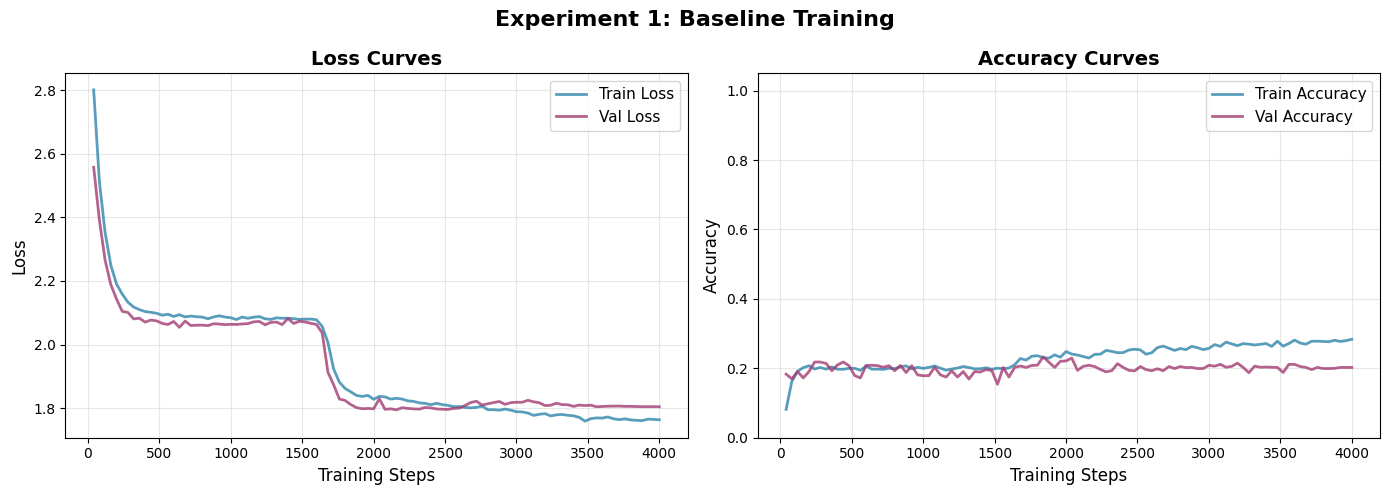


--- Part B: Summary Metrics ---

SUMMARY METRICS
Metric                              Value               
------------------------------------------------------------
Best Train Loss                     1.7592
Best Val Loss                       1.7948
Best Train Accuracy                 0.2836
Best Val Accuracy                   0.2332
Step (Best Train Loss)              3480
Step (Best Val Loss)                2160
Step (Best Train Acc)               4000
Step (Best Val Acc)                 1840
Generalization Lag (Loss)           -1320 steps
Generalization Lag (Acc)            -2160 steps


In [24]:
# Generate dataset
train_inputs, train_targets, val_inputs, val_targets, vocab = create_modular_arithmetic_dataset(p=11)

print(f"Dataset Statistics:")
print(f"  Training samples: {len(train_inputs)}")
print(f"  Validation samples: {len(val_inputs)}")
print(f"  Vocabulary size: {len(vocab['token_to_idx'])}")
print(f"  Sequence length: {train_inputs.shape[1]}")
print(f"  Total equations: {len(train_inputs) + len(val_inputs)}")

# Model configuration
config = {
    'vocab_size': len(vocab['token_to_idx']),
    'd': 128,
    'num_layers': 4,
    'num_heads': 8,
    'num_kv_groups': 4,
    'd_ff': 512,
    'dropout_prob': 0.1,
    'learning_rate': 3e-4,
    'weight_decay': 1e-4,
    'num_epochs': 100,
    'grad_clip': 1.0,
    'batch_size': 64,
}

print(f"\nModel Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Create dataloaders
batch_size = config['batch_size']
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def init_weights(module):
    """Initialize model with better weight initialization (small values)"""
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

model = ModernDecoderLM(
    vocab_size=config['vocab_size'],
    d=config['d'],
    num_layers=config['num_layers'],
    num_heads=config['num_heads'],
    num_kv_groups=config['num_kv_groups'],
    d_ff=config['d_ff'],
    dropout_prob=config['dropout_prob']
)
model.apply(init_weights)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {num_params:,}")

# Train model
print("\nTraining baseline model...")
history_baseline = train_model(model, train_loader, val_loader, vocab, config, device)

# SOLUTION: Part A - Generate plots
print("\n--- Part A: Training Curves ---")
plot_training_curves(history_baseline, "Experiment 1: Baseline Training", "exp1_baseline_curves")

# SOLUTION: Part B - Summary metrics and table
print("\n--- Part B: Summary Metrics ---")
metrics_baseline = compute_summary_metrics(history_baseline)
print_summary_table(metrics_baseline)

In [25]:
# print("\n" + "="*80)
# print("TODO: Write your interpretation in the PDF report [3 points]:")
# print("Address the following questions:")
# print("1. Does the model successfully learn the modular arithmetic task?")
# print("2. Is there evidence of overfitting or underfitting?")
# print("3. How quickly does validation performance follow training performance?")
# print("4. What do the generalization lags suggest about task difficulty?")
# print("5. Are there any unexpected behaviors in the learning curves?")
# print("="*80 + "\n")

## Section 6: Experiment 2 - Regularization and Optimization [8 points]

### Part A: Dropout Sweep [4 points]


Training with dropout=0.0


Epoch 1/100: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s, loss=2.53, acc=0.281] 


Epoch 1: Train Loss=2.7432, Train Acc=0.1031, Val Loss=2.5719, Val Acc=0.1687


Epoch 2/100: 100%|██████████| 40/40 [00:02<00:00, 15.69it/s, loss=2.42, acc=0.203] 


Epoch 2: Train Loss=2.5081, Train Acc=0.1750, Val Loss=2.3863, Val Acc=0.1812


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 15.32it/s, loss=2.36, acc=0.172] 


Epoch 3: Train Loss=2.3363, Train Acc=0.2004, Val Loss=2.2575, Val Acc=0.1879


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 15.27it/s, loss=2.14, acc=0.25]  


Epoch 4: Train Loss=2.2423, Train Acc=0.1949, Val Loss=2.1917, Val Acc=0.2181


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 16.66it/s, loss=1.97, acc=0.312]


Epoch 5: Train Loss=2.1840, Train Acc=0.2055, Val Loss=2.1569, Val Acc=0.1963


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 15.94it/s, loss=2.06, acc=0.219] 


Epoch 6: Train Loss=2.1565, Train Acc=0.1938, Val Loss=2.1274, Val Acc=0.1963


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s, loss=2.22, acc=0.141]


Epoch 7: Train Loss=2.1315, Train Acc=0.1938, Val Loss=2.1027, Val Acc=0.1999


Epoch 8/100: 100%|██████████| 40/40 [00:02<00:00, 15.73it/s, loss=2.01, acc=0.234] 


Epoch 8: Train Loss=2.1237, Train Acc=0.2008, Val Loss=2.0855, Val Acc=0.2150


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 16.24it/s, loss=2.05, acc=0.172]


Epoch 9: Train Loss=2.1150, Train Acc=0.1941, Val Loss=2.0731, Val Acc=0.1963


Epoch 10/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=2.15, acc=0.188] 


Epoch 10: Train Loss=2.0984, Train Acc=0.2066, Val Loss=2.0648, Val Acc=0.2119


Epoch 11/100: 100%|██████████| 40/40 [00:02<00:00, 16.47it/s, loss=2.11, acc=0.234]


Epoch 11: Train Loss=2.1066, Train Acc=0.1953, Val Loss=2.0765, Val Acc=0.1963


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 16.41it/s, loss=2.12, acc=0.203]


Epoch 12: Train Loss=2.0962, Train Acc=0.2012, Val Loss=2.0768, Val Acc=0.2082


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 16.49it/s, loss=2.1, acc=0.25]  


Epoch 13: Train Loss=2.0970, Train Acc=0.2012, Val Loss=2.0637, Val Acc=0.2025


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=2.12, acc=0.188] 


Epoch 14: Train Loss=2.0948, Train Acc=0.2016, Val Loss=2.0703, Val Acc=0.1812


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 16.24it/s, loss=2.23, acc=0.125] 


Epoch 15: Train Loss=2.0944, Train Acc=0.1988, Val Loss=2.0614, Val Acc=0.1854


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=2.04, acc=0.25]  


Epoch 16: Train Loss=2.0908, Train Acc=0.1945, Val Loss=2.0691, Val Acc=0.2181


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 16.49it/s, loss=2.06, acc=0.25]  


Epoch 17: Train Loss=2.0899, Train Acc=0.2020, Val Loss=2.0632, Val Acc=0.2072


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 16.01it/s, loss=2.22, acc=0.141] 


Epoch 18: Train Loss=2.0847, Train Acc=0.1949, Val Loss=2.0661, Val Acc=0.1874


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s, loss=2.07, acc=0.188]


Epoch 19: Train Loss=2.0836, Train Acc=0.2043, Val Loss=2.0582, Val Acc=0.1963


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 16.37it/s, loss=1.9, acc=0.281] 


Epoch 20: Train Loss=2.0860, Train Acc=0.1902, Val Loss=2.0604, Val Acc=0.1760


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 16.42it/s, loss=2.2, acc=0.156] 


Epoch 21: Train Loss=2.0836, Train Acc=0.2008, Val Loss=2.0706, Val Acc=0.1895


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 16.39it/s, loss=2.16, acc=0.188]


Epoch 22: Train Loss=2.0846, Train Acc=0.1973, Val Loss=2.0590, Val Acc=0.2077


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 16.30it/s, loss=2.15, acc=0.141] 


Epoch 23: Train Loss=2.0850, Train Acc=0.1895, Val Loss=2.0602, Val Acc=0.2067


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 16.61it/s, loss=2.17, acc=0.141] 


Epoch 24: Train Loss=2.0888, Train Acc=0.1988, Val Loss=2.0631, Val Acc=0.2077


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s, loss=1.89, acc=0.266]


Epoch 25: Train Loss=2.0868, Train Acc=0.1996, Val Loss=2.0688, Val Acc=0.2062


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=2.01, acc=0.219] 


Epoch 26: Train Loss=2.0875, Train Acc=0.2012, Val Loss=2.0728, Val Acc=0.2082


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 16.11it/s, loss=2.07, acc=0.156] 


Epoch 27: Train Loss=2.0862, Train Acc=0.1914, Val Loss=2.0660, Val Acc=0.1838


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s, loss=2.22, acc=0.141] 


Epoch 28: Train Loss=2.0821, Train Acc=0.2039, Val Loss=2.0733, Val Acc=0.1661


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 15.43it/s, loss=2.09, acc=0.25] 


Epoch 29: Train Loss=2.0825, Train Acc=0.2051, Val Loss=2.0671, Val Acc=0.1812


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 15.35it/s, loss=2.03, acc=0.266]


Epoch 30: Train Loss=2.0825, Train Acc=0.1969, Val Loss=2.0811, Val Acc=0.1718


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 14.84it/s, loss=2.19, acc=0.188] 


Epoch 31: Train Loss=2.0815, Train Acc=0.1977, Val Loss=2.0726, Val Acc=0.1723


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 14.76it/s, loss=2.03, acc=0.203]


Epoch 32: Train Loss=2.0552, Train Acc=0.2051, Val Loss=2.0235, Val Acc=0.1999


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 15.41it/s, loss=2.04, acc=0.203]


Epoch 33: Train Loss=1.9698, Train Acc=0.2332, Val Loss=1.9138, Val Acc=0.2244


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 15.39it/s, loss=1.76, acc=0.281]


Epoch 34: Train Loss=1.8902, Train Acc=0.2285, Val Loss=1.8192, Val Acc=0.2025


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 14.56it/s, loss=1.93, acc=0.219]


Epoch 35: Train Loss=1.8572, Train Acc=0.2398, Val Loss=1.8171, Val Acc=0.2233


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s, loss=1.86, acc=0.219]


Epoch 36: Train Loss=1.8329, Train Acc=0.2441, Val Loss=1.7955, Val Acc=0.2483


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 14.19it/s, loss=1.77, acc=0.234]


Epoch 37: Train Loss=1.8407, Train Acc=0.2313, Val Loss=1.8049, Val Acc=0.2286


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 15.22it/s, loss=1.8, acc=0.312] 


Epoch 38: Train Loss=1.8238, Train Acc=0.2398, Val Loss=1.7914, Val Acc=0.2233


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 15.77it/s, loss=1.8, acc=0.25]  


Epoch 39: Train Loss=1.8218, Train Acc=0.2320, Val Loss=1.7892, Val Acc=0.1968


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 15.94it/s, loss=1.74, acc=0.234]


Epoch 40: Train Loss=1.8136, Train Acc=0.2387, Val Loss=1.7967, Val Acc=0.2207


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 16.07it/s, loss=1.72, acc=0.281]


Epoch 41: Train Loss=1.8165, Train Acc=0.2445, Val Loss=1.7961, Val Acc=0.1848


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 16.63it/s, loss=1.64, acc=0.297]


Epoch 42: Train Loss=1.8131, Train Acc=0.2418, Val Loss=1.7881, Val Acc=0.2161


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 16.79it/s, loss=1.7, acc=0.266] 


Epoch 43: Train Loss=1.8070, Train Acc=0.2535, Val Loss=1.8006, Val Acc=0.2088


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 16.54it/s, loss=1.8, acc=0.172] 


Epoch 44: Train Loss=1.7975, Train Acc=0.2574, Val Loss=1.7972, Val Acc=0.2056


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 16.11it/s, loss=1.81, acc=0.25] 


Epoch 45: Train Loss=1.7959, Train Acc=0.2559, Val Loss=1.7996, Val Acc=0.1942


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 16.90it/s, loss=1.76, acc=0.266]


Epoch 46: Train Loss=1.7951, Train Acc=0.2520, Val Loss=1.7931, Val Acc=0.2093


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 15.43it/s, loss=1.81, acc=0.266]


Epoch 47: Train Loss=1.7759, Train Acc=0.2695, Val Loss=1.7914, Val Acc=0.2233


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 15.79it/s, loss=1.81, acc=0.281]


Epoch 48: Train Loss=1.7784, Train Acc=0.2664, Val Loss=1.7728, Val Acc=0.2249


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=1.71, acc=0.328]


Epoch 49: Train Loss=1.7679, Train Acc=0.2598, Val Loss=1.7819, Val Acc=0.2213


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s, loss=1.82, acc=0.234]


Epoch 50: Train Loss=1.7385, Train Acc=0.2793, Val Loss=1.7557, Val Acc=0.2238


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=1.62, acc=0.234]


Epoch 51: Train Loss=1.7003, Train Acc=0.2781, Val Loss=1.6929, Val Acc=0.2207


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=1.68, acc=0.281]


Epoch 52: Train Loss=1.6612, Train Acc=0.2883, Val Loss=1.6346, Val Acc=0.3149


Epoch 53/100: 100%|██████████| 40/40 [00:02<00:00, 18.40it/s, loss=1.72, acc=0.297]


Epoch 53: Train Loss=1.6297, Train Acc=0.3137, Val Loss=1.6106, Val Acc=0.3113


Epoch 54/100: 100%|██████████| 40/40 [00:02<00:00, 18.13it/s, loss=1.71, acc=0.281]


Epoch 54: Train Loss=1.5857, Train Acc=0.3398, Val Loss=1.5446, Val Acc=0.3316


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 17.18it/s, loss=1.63, acc=0.312]


Epoch 55: Train Loss=1.5107, Train Acc=0.3711, Val Loss=1.4908, Val Acc=0.3550


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 15.34it/s, loss=1.48, acc=0.422]


Epoch 56: Train Loss=1.4451, Train Acc=0.3875, Val Loss=1.4200, Val Acc=0.3373


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.92it/s, loss=1.33, acc=0.547]


Epoch 57: Train Loss=1.3757, Train Acc=0.4242, Val Loss=1.3004, Val Acc=0.4227


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s, loss=1.21, acc=0.578]


Epoch 58: Train Loss=1.2714, Train Acc=0.4680, Val Loss=1.2276, Val Acc=0.4446


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 16.48it/s, loss=1.18, acc=0.5]  


Epoch 59: Train Loss=1.2068, Train Acc=0.4910, Val Loss=1.1664, Val Acc=0.4482


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 15.35it/s, loss=0.981, acc=0.578]


Epoch 60: Train Loss=1.1556, Train Acc=0.5273, Val Loss=1.1032, Val Acc=0.5253


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 16.80it/s, loss=0.982, acc=0.578]


Epoch 61: Train Loss=1.1008, Train Acc=0.5293, Val Loss=1.0363, Val Acc=0.5919


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=0.909, acc=0.703]


Epoch 62: Train Loss=1.0614, Train Acc=0.5559, Val Loss=1.0063, Val Acc=0.5779


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 15.62it/s, loss=1.01, acc=0.531] 


Epoch 63: Train Loss=1.0344, Train Acc=0.5785, Val Loss=0.9745, Val Acc=0.6013


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 15.90it/s, loss=0.929, acc=0.625]


Epoch 64: Train Loss=0.9873, Train Acc=0.5922, Val Loss=0.9595, Val Acc=0.6013


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 15.21it/s, loss=0.893, acc=0.641]


Epoch 65: Train Loss=0.9699, Train Acc=0.6117, Val Loss=0.9363, Val Acc=0.6189


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 16.00it/s, loss=0.916, acc=0.672]


Epoch 66: Train Loss=0.9681, Train Acc=0.6035, Val Loss=0.9184, Val Acc=0.6127


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 17.13it/s, loss=0.87, acc=0.609] 


Epoch 67: Train Loss=0.9532, Train Acc=0.6172, Val Loss=0.8975, Val Acc=0.6413


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=0.882, acc=0.625]


Epoch 68: Train Loss=0.9259, Train Acc=0.6199, Val Loss=0.9057, Val Acc=0.6143


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 16.43it/s, loss=0.959, acc=0.578]


Epoch 69: Train Loss=0.9186, Train Acc=0.6293, Val Loss=0.8910, Val Acc=0.6075


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 15.83it/s, loss=0.811, acc=0.625]


Epoch 70: Train Loss=0.8984, Train Acc=0.6281, Val Loss=0.8676, Val Acc=0.6502


Epoch 71/100: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=0.895, acc=0.703]


Epoch 71: Train Loss=0.8921, Train Acc=0.6395, Val Loss=0.8547, Val Acc=0.6377


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 17.20it/s, loss=1.06, acc=0.516] 


Epoch 72: Train Loss=0.8843, Train Acc=0.6465, Val Loss=0.8509, Val Acc=0.6502


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 16.74it/s, loss=0.875, acc=0.625]


Epoch 73: Train Loss=0.8726, Train Acc=0.6453, Val Loss=0.8439, Val Acc=0.6288


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 16.53it/s, loss=0.903, acc=0.609]


Epoch 74: Train Loss=0.8566, Train Acc=0.6598, Val Loss=0.8428, Val Acc=0.6439


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 15.69it/s, loss=0.863, acc=0.641]


Epoch 75: Train Loss=0.8520, Train Acc=0.6633, Val Loss=0.8180, Val Acc=0.6439


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 15.48it/s, loss=0.883, acc=0.641]


Epoch 76: Train Loss=0.8419, Train Acc=0.6605, Val Loss=0.8298, Val Acc=0.6408


Epoch 77/100: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s, loss=0.704, acc=0.75] 


Epoch 77: Train Loss=0.8383, Train Acc=0.6645, Val Loss=0.8171, Val Acc=0.6439


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 16.98it/s, loss=0.794, acc=0.641]


Epoch 78: Train Loss=0.8235, Train Acc=0.6734, Val Loss=0.8135, Val Acc=0.6585


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 17.87it/s, loss=0.93, acc=0.672] 


Epoch 79: Train Loss=0.8117, Train Acc=0.6758, Val Loss=0.8138, Val Acc=0.6465


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s, loss=0.841, acc=0.656]


Epoch 80: Train Loss=0.8318, Train Acc=0.6586, Val Loss=0.8182, Val Acc=0.6377


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 16.07it/s, loss=0.712, acc=0.703]


Epoch 81: Train Loss=0.8023, Train Acc=0.6922, Val Loss=0.8033, Val Acc=0.6559


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 16.05it/s, loss=0.737, acc=0.734]


Epoch 82: Train Loss=0.8093, Train Acc=0.6852, Val Loss=0.7987, Val Acc=0.6590


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=0.777, acc=0.703]


Epoch 83: Train Loss=0.8000, Train Acc=0.6883, Val Loss=0.8033, Val Acc=0.6590


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 16.01it/s, loss=0.818, acc=0.656]


Epoch 84: Train Loss=0.7933, Train Acc=0.6984, Val Loss=0.7884, Val Acc=0.6590


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 16.29it/s, loss=0.736, acc=0.766]


Epoch 85: Train Loss=0.8038, Train Acc=0.6848, Val Loss=0.7868, Val Acc=0.6596


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 15.27it/s, loss=0.837, acc=0.703]


Epoch 86: Train Loss=0.7740, Train Acc=0.7086, Val Loss=0.7877, Val Acc=0.6746


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 16.23it/s, loss=0.713, acc=0.734]


Epoch 87: Train Loss=0.7919, Train Acc=0.6922, Val Loss=0.7852, Val Acc=0.6746


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 15.61it/s, loss=0.739, acc=0.672]


Epoch 88: Train Loss=0.7789, Train Acc=0.7020, Val Loss=0.7807, Val Acc=0.6778


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 16.30it/s, loss=0.836, acc=0.609]


Epoch 89: Train Loss=0.7821, Train Acc=0.6930, Val Loss=0.7774, Val Acc=0.6778


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 15.57it/s, loss=0.81, acc=0.688] 


Epoch 90: Train Loss=0.7675, Train Acc=0.7035, Val Loss=0.7745, Val Acc=0.6746


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 16.40it/s, loss=0.922, acc=0.625]


Epoch 91: Train Loss=0.7657, Train Acc=0.7074, Val Loss=0.7748, Val Acc=0.6715


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 15.53it/s, loss=0.926, acc=0.594]


Epoch 92: Train Loss=0.7714, Train Acc=0.7027, Val Loss=0.7745, Val Acc=0.6778


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 16.99it/s, loss=0.903, acc=0.609]


Epoch 93: Train Loss=0.7573, Train Acc=0.7117, Val Loss=0.7719, Val Acc=0.6778


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 15.19it/s, loss=0.83, acc=0.719] 


Epoch 94: Train Loss=0.7725, Train Acc=0.7063, Val Loss=0.7709, Val Acc=0.6778


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 17.14it/s, loss=0.733, acc=0.734]


Epoch 95: Train Loss=0.7707, Train Acc=0.7055, Val Loss=0.7721, Val Acc=0.6746


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 16.64it/s, loss=0.736, acc=0.719]


Epoch 96: Train Loss=0.7728, Train Acc=0.7031, Val Loss=0.7714, Val Acc=0.6715


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 15.46it/s, loss=0.709, acc=0.75] 


Epoch 97: Train Loss=0.7713, Train Acc=0.7020, Val Loss=0.7710, Val Acc=0.6746


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 15.24it/s, loss=0.918, acc=0.578]


Epoch 98: Train Loss=0.7530, Train Acc=0.7168, Val Loss=0.7712, Val Acc=0.6746


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 18.19it/s, loss=0.786, acc=0.781]


Epoch 99: Train Loss=0.7626, Train Acc=0.7094, Val Loss=0.7711, Val Acc=0.6746


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 17.34it/s, loss=0.734, acc=0.812]


Epoch 100: Train Loss=0.7622, Train Acc=0.7105, Val Loss=0.7711, Val Acc=0.6746

Training with dropout=0.2


Epoch 1/100: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=2.68, acc=0.141] 


Epoch 1: Train Loss=2.8060, Train Acc=0.0816, Val Loss=2.6014, Val Acc=0.1869


Epoch 2/100: 100%|██████████| 40/40 [00:02<00:00, 16.98it/s, loss=2.39, acc=0.219]


Epoch 2: Train Loss=2.5325, Train Acc=0.1730, Val Loss=2.3959, Val Acc=0.1541


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 15.89it/s, loss=2.26, acc=0.234]


Epoch 3: Train Loss=2.3776, Train Acc=0.1828, Val Loss=2.2703, Val Acc=0.1869


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 15.13it/s, loss=2.19, acc=0.25] 


Epoch 4: Train Loss=2.2633, Train Acc=0.2023, Val Loss=2.1992, Val Acc=0.1937


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 15.38it/s, loss=2.16, acc=0.156] 


Epoch 5: Train Loss=2.1952, Train Acc=0.1930, Val Loss=2.1386, Val Acc=0.1926


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 14.25it/s, loss=1.99, acc=0.234]


Epoch 6: Train Loss=2.1616, Train Acc=0.1977, Val Loss=2.1080, Val Acc=0.2176


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 15.13it/s, loss=2.32, acc=0.141]


Epoch 7: Train Loss=2.1363, Train Acc=0.1977, Val Loss=2.0860, Val Acc=0.1854


Epoch 8/100: 100%|██████████| 40/40 [00:02<00:00, 16.05it/s, loss=2.03, acc=0.234]


Epoch 8: Train Loss=2.1213, Train Acc=0.1902, Val Loss=2.0738, Val Acc=0.2072


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 15.49it/s, loss=2.16, acc=0.219] 


Epoch 9: Train Loss=2.1137, Train Acc=0.1930, Val Loss=2.0834, Val Acc=0.1843


Epoch 10/100: 100%|██████████| 40/40 [00:02<00:00, 15.55it/s, loss=2.2, acc=0.125]  


Epoch 10: Train Loss=2.1084, Train Acc=0.1883, Val Loss=2.0720, Val Acc=0.1937


Epoch 11/100: 100%|██████████| 40/40 [00:02<00:00, 16.04it/s, loss=2.13, acc=0.156] 


Epoch 11: Train Loss=2.1090, Train Acc=0.1965, Val Loss=2.0680, Val Acc=0.2113


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 15.09it/s, loss=2.15, acc=0.141] 


Epoch 12: Train Loss=2.0973, Train Acc=0.1977, Val Loss=2.0638, Val Acc=0.2077


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s, loss=2.05, acc=0.203] 


Epoch 13: Train Loss=2.1058, Train Acc=0.1941, Val Loss=2.0623, Val Acc=0.2098


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=2.07, acc=0.203]


Epoch 14: Train Loss=2.1017, Train Acc=0.1902, Val Loss=2.0576, Val Acc=0.2213


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 15.47it/s, loss=2.04, acc=0.234] 


Epoch 15: Train Loss=2.0998, Train Acc=0.1961, Val Loss=2.0563, Val Acc=0.2098


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=2.23, acc=0.156] 


Epoch 16: Train Loss=2.0951, Train Acc=0.1961, Val Loss=2.0624, Val Acc=0.1895


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s, loss=2.08, acc=0.266]


Epoch 17: Train Loss=2.0897, Train Acc=0.2020, Val Loss=2.0535, Val Acc=0.2181


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 15.46it/s, loss=2.23, acc=0.141]


Epoch 18: Train Loss=2.0876, Train Acc=0.2020, Val Loss=2.0743, Val Acc=0.2088


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 16.27it/s, loss=2.18, acc=0.172] 


Epoch 19: Train Loss=2.0920, Train Acc=0.1938, Val Loss=2.0560, Val Acc=0.1957


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=2.25, acc=0.125]


Epoch 20: Train Loss=2.0882, Train Acc=0.2016, Val Loss=2.0532, Val Acc=0.2275


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 16.56it/s, loss=2.16, acc=0.156] 


Epoch 21: Train Loss=2.0870, Train Acc=0.2047, Val Loss=2.0650, Val Acc=0.2056


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 15.94it/s, loss=2.2, acc=0.125]  


Epoch 22: Train Loss=2.0890, Train Acc=0.1988, Val Loss=2.0613, Val Acc=0.1900


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 15.55it/s, loss=2.04, acc=0.25]  


Epoch 23: Train Loss=2.0817, Train Acc=0.2105, Val Loss=2.0567, Val Acc=0.2082


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 15.21it/s, loss=2.2, acc=0.141]  


Epoch 24: Train Loss=2.0880, Train Acc=0.2062, Val Loss=2.0553, Val Acc=0.2082


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 15.38it/s, loss=2.14, acc=0.141]


Epoch 25: Train Loss=2.0883, Train Acc=0.1898, Val Loss=2.0558, Val Acc=0.2290


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s, loss=2.03, acc=0.266] 


Epoch 26: Train Loss=2.0850, Train Acc=0.1961, Val Loss=2.0606, Val Acc=0.1937


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 15.35it/s, loss=2.04, acc=0.203]


Epoch 27: Train Loss=2.0856, Train Acc=0.1992, Val Loss=2.0842, Val Acc=0.1729


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 15.67it/s, loss=2.04, acc=0.172]


Epoch 28: Train Loss=2.0856, Train Acc=0.2004, Val Loss=2.0525, Val Acc=0.2030


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 15.30it/s, loss=2.01, acc=0.234]


Epoch 29: Train Loss=2.0834, Train Acc=0.1977, Val Loss=2.0538, Val Acc=0.2051


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 14.91it/s, loss=2.01, acc=0.234] 


Epoch 30: Train Loss=2.0831, Train Acc=0.1992, Val Loss=2.0634, Val Acc=0.2072


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 15.38it/s, loss=2.06, acc=0.234]


Epoch 31: Train Loss=2.0890, Train Acc=0.1926, Val Loss=2.0581, Val Acc=0.2030


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 15.36it/s, loss=2.23, acc=0.141]


Epoch 32: Train Loss=2.0836, Train Acc=0.2012, Val Loss=2.0617, Val Acc=0.1869


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 15.11it/s, loss=2, acc=0.266]   


Epoch 33: Train Loss=2.0830, Train Acc=0.1988, Val Loss=2.0630, Val Acc=0.1874


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 15.59it/s, loss=1.99, acc=0.234] 


Epoch 34: Train Loss=2.0787, Train Acc=0.2062, Val Loss=2.0650, Val Acc=0.1937


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 15.36it/s, loss=2.07, acc=0.234]


Epoch 35: Train Loss=2.0866, Train Acc=0.2004, Val Loss=2.0567, Val Acc=0.1780


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 15.57it/s, loss=2.04, acc=0.203] 


Epoch 36: Train Loss=2.0877, Train Acc=0.1895, Val Loss=2.0609, Val Acc=0.2036


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 15.76it/s, loss=2.1, acc=0.188]  


Epoch 37: Train Loss=2.0823, Train Acc=0.2016, Val Loss=2.0634, Val Acc=0.1931


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 15.92it/s, loss=2.11, acc=0.156]


Epoch 38: Train Loss=2.0835, Train Acc=0.1996, Val Loss=2.0583, Val Acc=0.2088


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s, loss=2.15, acc=0.156]


Epoch 39: Train Loss=2.0816, Train Acc=0.1980, Val Loss=2.0695, Val Acc=0.2088


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 16.72it/s, loss=2.1, acc=0.203] 


Epoch 40: Train Loss=2.0774, Train Acc=0.2066, Val Loss=2.0620, Val Acc=0.1692


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=2.12, acc=0.188]


Epoch 41: Train Loss=2.0782, Train Acc=0.2051, Val Loss=2.0660, Val Acc=0.1692


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 15.46it/s, loss=2.15, acc=0.156]


Epoch 42: Train Loss=2.0873, Train Acc=0.1938, Val Loss=2.0624, Val Acc=0.1812


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 15.52it/s, loss=2.07, acc=0.25]  


Epoch 43: Train Loss=2.0796, Train Acc=0.1969, Val Loss=2.0760, Val Acc=0.1931


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 15.86it/s, loss=2.14, acc=0.141]


Epoch 44: Train Loss=2.0781, Train Acc=0.2016, Val Loss=2.0626, Val Acc=0.1749


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s, loss=2.11, acc=0.156]


Epoch 45: Train Loss=2.0777, Train Acc=0.2027, Val Loss=2.0706, Val Acc=0.1838


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 16.51it/s, loss=1.96, acc=0.203] 


Epoch 46: Train Loss=2.0761, Train Acc=0.2035, Val Loss=2.0736, Val Acc=0.1931


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 15.34it/s, loss=2.23, acc=0.109]


Epoch 47: Train Loss=2.0824, Train Acc=0.2062, Val Loss=2.0680, Val Acc=0.1754


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 16.24it/s, loss=2.19, acc=0.156]


Epoch 48: Train Loss=2.0768, Train Acc=0.1973, Val Loss=2.0670, Val Acc=0.1572


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 16.69it/s, loss=2.04, acc=0.25] 


Epoch 49: Train Loss=2.0788, Train Acc=0.2078, Val Loss=2.0717, Val Acc=0.1723


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=1.97, acc=0.219]


Epoch 50: Train Loss=2.0817, Train Acc=0.1965, Val Loss=2.0744, Val Acc=0.1749


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=2.11, acc=0.172] 


Epoch 51: Train Loss=2.0797, Train Acc=0.2066, Val Loss=2.0701, Val Acc=0.1692


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s, loss=2.13, acc=0.172] 


Epoch 52: Train Loss=2.0764, Train Acc=0.2035, Val Loss=2.0828, Val Acc=0.1697


Epoch 53/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=2.09, acc=0.125] 


Epoch 53: Train Loss=2.0783, Train Acc=0.1984, Val Loss=2.0699, Val Acc=0.1692


Epoch 54/100: 100%|██████████| 40/40 [00:02<00:00, 15.59it/s, loss=2.07, acc=0.188]


Epoch 54: Train Loss=2.0763, Train Acc=0.1992, Val Loss=2.0777, Val Acc=0.1655


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s, loss=2.21, acc=0.141] 


Epoch 55: Train Loss=2.0862, Train Acc=0.2062, Val Loss=2.0861, Val Acc=0.1692


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 15.16it/s, loss=2.25, acc=0.109]


Epoch 56: Train Loss=2.0760, Train Acc=0.2023, Val Loss=2.0844, Val Acc=0.1749


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.61it/s, loss=2.06, acc=0.188]


Epoch 57: Train Loss=2.0747, Train Acc=0.2074, Val Loss=2.0875, Val Acc=0.1604


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s, loss=2.19, acc=0.156]


Epoch 58: Train Loss=2.0675, Train Acc=0.2176, Val Loss=2.0757, Val Acc=0.1692


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 16.82it/s, loss=2.03, acc=0.281]


Epoch 59: Train Loss=2.0568, Train Acc=0.2203, Val Loss=2.0640, Val Acc=0.1937


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s, loss=2.02, acc=0.188] 


Epoch 60: Train Loss=2.0412, Train Acc=0.2238, Val Loss=2.0114, Val Acc=0.1937


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 15.96it/s, loss=1.86, acc=0.297]


Epoch 61: Train Loss=2.0248, Train Acc=0.2414, Val Loss=1.9872, Val Acc=0.2338


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 14.45it/s, loss=2.02, acc=0.25] 


Epoch 62: Train Loss=2.0014, Train Acc=0.2559, Val Loss=1.9303, Val Acc=0.2770


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 14.86it/s, loss=1.85, acc=0.281]


Epoch 63: Train Loss=1.9660, Train Acc=0.2652, Val Loss=1.8784, Val Acc=0.2754


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 16.80it/s, loss=1.8, acc=0.344] 


Epoch 64: Train Loss=1.9092, Train Acc=0.3035, Val Loss=1.8209, Val Acc=0.3285


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s, loss=1.88, acc=0.266]


Epoch 65: Train Loss=1.8752, Train Acc=0.3023, Val Loss=1.8180, Val Acc=0.3014


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 16.11it/s, loss=1.66, acc=0.438]


Epoch 66: Train Loss=1.8402, Train Acc=0.3246, Val Loss=1.7314, Val Acc=0.4232


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s, loss=1.69, acc=0.469]


Epoch 67: Train Loss=1.8044, Train Acc=0.3453, Val Loss=1.7050, Val Acc=0.4305


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=1.57, acc=0.453]


Epoch 68: Train Loss=1.7827, Train Acc=0.3461, Val Loss=1.6726, Val Acc=0.4680


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 16.11it/s, loss=1.73, acc=0.391]


Epoch 69: Train Loss=1.7662, Train Acc=0.3684, Val Loss=1.7130, Val Acc=0.3571


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=1.95, acc=0.344]


Epoch 70: Train Loss=1.7409, Train Acc=0.3695, Val Loss=1.6412, Val Acc=0.4550


Epoch 71/100: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=1.84, acc=0.281]


Epoch 71: Train Loss=1.7314, Train Acc=0.3750, Val Loss=1.6069, Val Acc=0.4795


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s, loss=1.8, acc=0.297] 


Epoch 72: Train Loss=1.7172, Train Acc=0.3723, Val Loss=1.6045, Val Acc=0.4706


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s, loss=1.61, acc=0.453]


Epoch 73: Train Loss=1.6906, Train Acc=0.3996, Val Loss=1.6111, Val Acc=0.4394


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 15.57it/s, loss=1.56, acc=0.453]


Epoch 74: Train Loss=1.6841, Train Acc=0.3898, Val Loss=1.5825, Val Acc=0.4613


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 16.68it/s, loss=1.49, acc=0.5]  


Epoch 75: Train Loss=1.6733, Train Acc=0.3906, Val Loss=1.5818, Val Acc=0.4451


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 16.41it/s, loss=1.71, acc=0.359]


Epoch 76: Train Loss=1.6760, Train Acc=0.3758, Val Loss=1.5769, Val Acc=0.4305


Epoch 77/100: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s, loss=1.86, acc=0.359]


Epoch 77: Train Loss=1.6494, Train Acc=0.4137, Val Loss=1.5681, Val Acc=0.4305


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 14.52it/s, loss=1.64, acc=0.469]


Epoch 78: Train Loss=1.6545, Train Acc=0.4090, Val Loss=1.5819, Val Acc=0.4123


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s, loss=1.41, acc=0.531]


Epoch 79: Train Loss=1.6412, Train Acc=0.4090, Val Loss=1.5465, Val Acc=0.4613


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 14.81it/s, loss=1.5, acc=0.516] 


Epoch 80: Train Loss=1.6342, Train Acc=0.4230, Val Loss=1.5552, Val Acc=0.4519


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s, loss=1.61, acc=0.359]


Epoch 81: Train Loss=1.6234, Train Acc=0.4301, Val Loss=1.5016, Val Acc=0.5164


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 15.64it/s, loss=1.73, acc=0.406]


Epoch 82: Train Loss=1.6313, Train Acc=0.4184, Val Loss=1.5180, Val Acc=0.4982


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 15.75it/s, loss=1.65, acc=0.453]


Epoch 83: Train Loss=1.6172, Train Acc=0.4289, Val Loss=1.5248, Val Acc=0.4743


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s, loss=1.57, acc=0.359]


Epoch 84: Train Loss=1.6203, Train Acc=0.4223, Val Loss=1.5184, Val Acc=0.4800


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 16.69it/s, loss=1.58, acc=0.484]


Epoch 85: Train Loss=1.6090, Train Acc=0.4367, Val Loss=1.5124, Val Acc=0.4863


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 15.89it/s, loss=1.64, acc=0.453]


Epoch 86: Train Loss=1.6100, Train Acc=0.4246, Val Loss=1.5028, Val Acc=0.5013


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=1.36, acc=0.547]


Epoch 87: Train Loss=1.6167, Train Acc=0.4273, Val Loss=1.5018, Val Acc=0.4831


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 16.41it/s, loss=1.46, acc=0.531]


Epoch 88: Train Loss=1.5990, Train Acc=0.4395, Val Loss=1.5065, Val Acc=0.4863


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 15.63it/s, loss=1.62, acc=0.422]


Epoch 89: Train Loss=1.6111, Train Acc=0.4277, Val Loss=1.5029, Val Acc=0.4857


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 16.53it/s, loss=1.44, acc=0.547]


Epoch 90: Train Loss=1.6046, Train Acc=0.4418, Val Loss=1.5162, Val Acc=0.4738


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 16.80it/s, loss=1.81, acc=0.25] 


Epoch 91: Train Loss=1.5944, Train Acc=0.4313, Val Loss=1.4958, Val Acc=0.4951


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 16.44it/s, loss=1.51, acc=0.453]


Epoch 92: Train Loss=1.5940, Train Acc=0.4301, Val Loss=1.5042, Val Acc=0.4831


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s, loss=1.46, acc=0.516]


Epoch 93: Train Loss=1.5994, Train Acc=0.4340, Val Loss=1.5035, Val Acc=0.4831


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 15.68it/s, loss=1.5, acc=0.469] 


Epoch 94: Train Loss=1.5890, Train Acc=0.4398, Val Loss=1.5012, Val Acc=0.4863


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 16.43it/s, loss=1.66, acc=0.484]


Epoch 95: Train Loss=1.6019, Train Acc=0.4305, Val Loss=1.4960, Val Acc=0.4863


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s, loss=1.64, acc=0.453]


Epoch 96: Train Loss=1.5967, Train Acc=0.4336, Val Loss=1.4997, Val Acc=0.4831


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 16.24it/s, loss=1.79, acc=0.312]


Epoch 97: Train Loss=1.6016, Train Acc=0.4344, Val Loss=1.4977, Val Acc=0.4863


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 15.10it/s, loss=1.7, acc=0.391] 


Epoch 98: Train Loss=1.5877, Train Acc=0.4406, Val Loss=1.4978, Val Acc=0.4863


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 15.60it/s, loss=1.57, acc=0.484]


Epoch 99: Train Loss=1.5911, Train Acc=0.4355, Val Loss=1.4977, Val Acc=0.4863


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 16.77it/s, loss=1.56, acc=0.422]


Epoch 100: Train Loss=1.5854, Train Acc=0.4484, Val Loss=1.4977, Val Acc=0.4863

Training with dropout=0.4


Epoch 1/100: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=2.73, acc=0.141] 


Epoch 1: Train Loss=2.8121, Train Acc=0.0738, Val Loss=2.5981, Val Acc=0.1869


Epoch 2/100: 100%|██████████| 40/40 [00:02<00:00, 16.37it/s, loss=2.58, acc=0.141] 


Epoch 2: Train Loss=2.6138, Train Acc=0.1652, Val Loss=2.4709, Val Acc=0.1838


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 15.30it/s, loss=2.43, acc=0.172] 


Epoch 3: Train Loss=2.4954, Train Acc=0.1648, Val Loss=2.3668, Val Acc=0.1744


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=2.43, acc=0.156]


Epoch 4: Train Loss=2.3753, Train Acc=0.1910, Val Loss=2.2477, Val Acc=0.2124


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=2.16, acc=0.25] 


Epoch 5: Train Loss=2.2586, Train Acc=0.2031, Val Loss=2.1635, Val Acc=0.2077


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s, loss=2.1, acc=0.25]  


Epoch 6: Train Loss=2.1897, Train Acc=0.2051, Val Loss=2.1193, Val Acc=0.1900


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 16.36it/s, loss=2.09, acc=0.172] 


Epoch 7: Train Loss=2.1496, Train Acc=0.1973, Val Loss=2.1036, Val Acc=0.2207


Epoch 8/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=2.24, acc=0.141]


Epoch 8: Train Loss=2.1327, Train Acc=0.1984, Val Loss=2.0929, Val Acc=0.1895


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 15.00it/s, loss=1.96, acc=0.25] 


Epoch 9: Train Loss=2.1218, Train Acc=0.2086, Val Loss=2.0690, Val Acc=0.1979


Epoch 10/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=2.06, acc=0.25]  


Epoch 10: Train Loss=2.1197, Train Acc=0.1898, Val Loss=2.0666, Val Acc=0.1905


Epoch 11/100: 100%|██████████| 40/40 [00:02<00:00, 16.00it/s, loss=2.11, acc=0.25] 


Epoch 11: Train Loss=2.1122, Train Acc=0.2039, Val Loss=2.0813, Val Acc=0.1994


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s, loss=2, acc=0.219]    


Epoch 12: Train Loss=2.1033, Train Acc=0.2016, Val Loss=2.0734, Val Acc=0.1905


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 16.04it/s, loss=2.03, acc=0.234]


Epoch 13: Train Loss=2.1016, Train Acc=0.1984, Val Loss=2.0798, Val Acc=0.2030


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 15.69it/s, loss=2.11, acc=0.188] 


Epoch 14: Train Loss=2.0971, Train Acc=0.2027, Val Loss=2.0695, Val Acc=0.1937


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 15.62it/s, loss=2.13, acc=0.234] 


Epoch 15: Train Loss=2.1005, Train Acc=0.2020, Val Loss=2.0687, Val Acc=0.1947


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 16.61it/s, loss=2.16, acc=0.125]


Epoch 16: Train Loss=2.0923, Train Acc=0.2078, Val Loss=2.0700, Val Acc=0.2036


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 15.73it/s, loss=2.04, acc=0.188]


Epoch 17: Train Loss=2.0960, Train Acc=0.2016, Val Loss=2.0763, Val Acc=0.1937


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s, loss=1.97, acc=0.219] 


Epoch 18: Train Loss=2.1005, Train Acc=0.1988, Val Loss=2.0756, Val Acc=0.2025


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 15.30it/s, loss=2.03, acc=0.25] 


Epoch 19: Train Loss=2.0933, Train Acc=0.1980, Val Loss=2.0757, Val Acc=0.1812


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 14.94it/s, loss=2.09, acc=0.203] 


Epoch 20: Train Loss=2.0927, Train Acc=0.1914, Val Loss=2.0738, Val Acc=0.2139


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 16.10it/s, loss=2.17, acc=0.141]


Epoch 21: Train Loss=2.0887, Train Acc=0.1941, Val Loss=2.0813, Val Acc=0.1973


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 16.51it/s, loss=2.11, acc=0.172]


Epoch 22: Train Loss=2.0860, Train Acc=0.2000, Val Loss=2.0800, Val Acc=0.1968


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 16.50it/s, loss=2.18, acc=0.141] 


Epoch 23: Train Loss=2.0877, Train Acc=0.1984, Val Loss=2.0948, Val Acc=0.1895


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 15.68it/s, loss=2.04, acc=0.203]


Epoch 24: Train Loss=2.0898, Train Acc=0.2000, Val Loss=2.0863, Val Acc=0.1754


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 14.89it/s, loss=2.1, acc=0.172] 


Epoch 25: Train Loss=2.0884, Train Acc=0.2055, Val Loss=2.1056, Val Acc=0.1843


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s, loss=2, acc=0.266]   


Epoch 26: Train Loss=2.0861, Train Acc=0.2039, Val Loss=2.1062, Val Acc=0.1874


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 15.61it/s, loss=2.13, acc=0.266]


Epoch 27: Train Loss=2.0854, Train Acc=0.2027, Val Loss=2.1209, Val Acc=0.1911


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s, loss=2.08, acc=0.188]


Epoch 28: Train Loss=2.0827, Train Acc=0.1988, Val Loss=2.1007, Val Acc=0.1905


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 16.50it/s, loss=2.14, acc=0.219]


Epoch 29: Train Loss=2.0887, Train Acc=0.2004, Val Loss=2.1123, Val Acc=0.1957


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s, loss=2.25, acc=0.109]


Epoch 30: Train Loss=2.0831, Train Acc=0.2047, Val Loss=2.1151, Val Acc=0.1817


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 16.47it/s, loss=2.18, acc=0.156] 


Epoch 31: Train Loss=2.0905, Train Acc=0.1949, Val Loss=2.1128, Val Acc=0.1812


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 15.00it/s, loss=2.17, acc=0.172]


Epoch 32: Train Loss=2.0828, Train Acc=0.2043, Val Loss=2.1103, Val Acc=0.1900


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 16.41it/s, loss=2.11, acc=0.219]


Epoch 33: Train Loss=2.0812, Train Acc=0.2125, Val Loss=2.1078, Val Acc=0.1874


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 16.67it/s, loss=2.24, acc=0.109] 


Epoch 34: Train Loss=2.0807, Train Acc=0.2094, Val Loss=2.1129, Val Acc=0.1968


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 15.94it/s, loss=2.13, acc=0.156]


Epoch 35: Train Loss=2.0839, Train Acc=0.2090, Val Loss=2.1222, Val Acc=0.1838


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 15.94it/s, loss=2.09, acc=0.219]


Epoch 36: Train Loss=2.0779, Train Acc=0.2047, Val Loss=2.1339, Val Acc=0.2139


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 15.64it/s, loss=2.06, acc=0.25] 


Epoch 37: Train Loss=2.0843, Train Acc=0.2070, Val Loss=2.1016, Val Acc=0.2196


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 16.29it/s, loss=1.96, acc=0.25]  


Epoch 38: Train Loss=2.0741, Train Acc=0.2160, Val Loss=2.1022, Val Acc=0.1848


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 16.45it/s, loss=2.14, acc=0.203]


Epoch 39: Train Loss=2.0657, Train Acc=0.2113, Val Loss=2.0776, Val Acc=0.2139


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s, loss=1.95, acc=0.234]


Epoch 40: Train Loss=2.0648, Train Acc=0.2152, Val Loss=2.0822, Val Acc=0.1838


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s, loss=2.15, acc=0.234]


Epoch 41: Train Loss=2.0559, Train Acc=0.2234, Val Loss=2.0713, Val Acc=0.2030


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 16.34it/s, loss=2.05, acc=0.281]


Epoch 42: Train Loss=2.0590, Train Acc=0.2250, Val Loss=2.0592, Val Acc=0.1983


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 16.22it/s, loss=2.07, acc=0.219]


Epoch 43: Train Loss=2.0474, Train Acc=0.2219, Val Loss=2.0620, Val Acc=0.1895


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=1.99, acc=0.25] 


Epoch 44: Train Loss=2.0294, Train Acc=0.2281, Val Loss=1.9933, Val Acc=0.2529


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s, loss=1.9, acc=0.281] 


Epoch 45: Train Loss=2.0053, Train Acc=0.2293, Val Loss=1.9523, Val Acc=0.2577


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 14.84it/s, loss=1.92, acc=0.266]


Epoch 46: Train Loss=1.9857, Train Acc=0.2453, Val Loss=1.8760, Val Acc=0.2847


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 16.74it/s, loss=2.03, acc=0.234]


Epoch 47: Train Loss=1.9462, Train Acc=0.2645, Val Loss=1.8371, Val Acc=0.3316


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s, loss=1.73, acc=0.328]


Epoch 48: Train Loss=1.9265, Train Acc=0.2746, Val Loss=1.7871, Val Acc=0.3503


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 16.06it/s, loss=1.85, acc=0.312]


Epoch 49: Train Loss=1.8965, Train Acc=0.2855, Val Loss=1.7516, Val Acc=0.3581


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s, loss=1.85, acc=0.328]


Epoch 50: Train Loss=1.8738, Train Acc=0.3059, Val Loss=1.7092, Val Acc=0.3857


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 14.29it/s, loss=1.84, acc=0.297]


Epoch 51: Train Loss=1.8444, Train Acc=0.3168, Val Loss=1.7078, Val Acc=0.3524


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=1.8, acc=0.375] 


Epoch 52: Train Loss=1.8338, Train Acc=0.3164, Val Loss=1.6672, Val Acc=0.3566


Epoch 53/100: 100%|██████████| 40/40 [00:02<00:00, 15.19it/s, loss=1.79, acc=0.328]


Epoch 53: Train Loss=1.7985, Train Acc=0.3352, Val Loss=1.6850, Val Acc=0.3675


Epoch 54/100: 100%|██████████| 40/40 [00:04<00:00,  9.63it/s, loss=1.77, acc=0.297]


Epoch 54: Train Loss=1.7896, Train Acc=0.3305, Val Loss=1.6389, Val Acc=0.4039


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 16.09it/s, loss=1.84, acc=0.281]


Epoch 55: Train Loss=1.7787, Train Acc=0.3383, Val Loss=1.6059, Val Acc=0.4221


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 17.35it/s, loss=1.75, acc=0.359]


Epoch 56: Train Loss=1.7581, Train Acc=0.3461, Val Loss=1.5818, Val Acc=0.4488


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.42it/s, loss=1.84, acc=0.344]


Epoch 57: Train Loss=1.7506, Train Acc=0.3516, Val Loss=1.5631, Val Acc=0.4852


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 16.37it/s, loss=1.84, acc=0.234]


Epoch 58: Train Loss=1.7389, Train Acc=0.3445, Val Loss=1.5838, Val Acc=0.4477


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 16.14it/s, loss=1.84, acc=0.312]


Epoch 59: Train Loss=1.7326, Train Acc=0.3465, Val Loss=1.5476, Val Acc=0.4821


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 15.31it/s, loss=1.77, acc=0.281]


Epoch 60: Train Loss=1.7216, Train Acc=0.3523, Val Loss=1.5541, Val Acc=0.4310


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 14.52it/s, loss=1.67, acc=0.359]


Epoch 61: Train Loss=1.7180, Train Acc=0.3605, Val Loss=1.5484, Val Acc=0.4295


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 14.66it/s, loss=1.56, acc=0.438]


Epoch 62: Train Loss=1.6977, Train Acc=0.3770, Val Loss=1.5357, Val Acc=0.4940


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 14.30it/s, loss=1.59, acc=0.344]


Epoch 63: Train Loss=1.7017, Train Acc=0.3570, Val Loss=1.5279, Val Acc=0.4826


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 15.03it/s, loss=1.46, acc=0.484]


Epoch 64: Train Loss=1.7063, Train Acc=0.3621, Val Loss=1.5293, Val Acc=0.4883


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 13.88it/s, loss=1.76, acc=0.375]


Epoch 65: Train Loss=1.6826, Train Acc=0.3777, Val Loss=1.5186, Val Acc=0.4815


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 14.59it/s, loss=1.57, acc=0.484]


Epoch 66: Train Loss=1.6873, Train Acc=0.3793, Val Loss=1.5198, Val Acc=0.4706


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 14.40it/s, loss=1.7, acc=0.328] 


Epoch 67: Train Loss=1.6760, Train Acc=0.3754, Val Loss=1.5115, Val Acc=0.4462


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 15.27it/s, loss=1.77, acc=0.297]


Epoch 68: Train Loss=1.6549, Train Acc=0.3977, Val Loss=1.4850, Val Acc=0.4997


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 14.85it/s, loss=1.64, acc=0.391]


Epoch 69: Train Loss=1.6687, Train Acc=0.3871, Val Loss=1.4729, Val Acc=0.5122


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s, loss=1.68, acc=0.328]


Epoch 70: Train Loss=1.6605, Train Acc=0.3770, Val Loss=1.4756, Val Acc=0.4946


Epoch 71/100: 100%|██████████| 40/40 [00:02<00:00, 15.14it/s, loss=1.74, acc=0.391]


Epoch 71: Train Loss=1.6589, Train Acc=0.3855, Val Loss=1.4807, Val Acc=0.5060


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 14.79it/s, loss=1.76, acc=0.312]


Epoch 72: Train Loss=1.6533, Train Acc=0.3895, Val Loss=1.4707, Val Acc=0.5034


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 16.34it/s, loss=1.65, acc=0.375]


Epoch 73: Train Loss=1.6461, Train Acc=0.3902, Val Loss=1.4664, Val Acc=0.4909


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s, loss=1.61, acc=0.359]


Epoch 74: Train Loss=1.6545, Train Acc=0.3766, Val Loss=1.4880, Val Acc=0.4649


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 14.89it/s, loss=1.76, acc=0.344]


Epoch 75: Train Loss=1.6541, Train Acc=0.3832, Val Loss=1.4891, Val Acc=0.4701


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 15.41it/s, loss=1.46, acc=0.5]  


Epoch 76: Train Loss=1.6400, Train Acc=0.4000, Val Loss=1.4781, Val Acc=0.4550


Epoch 77/100: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s, loss=1.49, acc=0.438]


Epoch 77: Train Loss=1.6334, Train Acc=0.3891, Val Loss=1.4575, Val Acc=0.5076


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 15.05it/s, loss=1.69, acc=0.375]


Epoch 78: Train Loss=1.6350, Train Acc=0.4035, Val Loss=1.4594, Val Acc=0.5071


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 17.07it/s, loss=1.72, acc=0.375]


Epoch 79: Train Loss=1.6455, Train Acc=0.3875, Val Loss=1.4535, Val Acc=0.4914


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 14.83it/s, loss=1.4, acc=0.438] 


Epoch 80: Train Loss=1.6288, Train Acc=0.4047, Val Loss=1.4491, Val Acc=0.5039


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 16.45it/s, loss=1.59, acc=0.359]


Epoch 81: Train Loss=1.6308, Train Acc=0.3973, Val Loss=1.4690, Val Acc=0.4613


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 16.97it/s, loss=1.8, acc=0.406] 


Epoch 82: Train Loss=1.6314, Train Acc=0.3980, Val Loss=1.4511, Val Acc=0.4914


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 17.21it/s, loss=1.72, acc=0.438]


Epoch 83: Train Loss=1.6233, Train Acc=0.3934, Val Loss=1.4483, Val Acc=0.5190


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 16.86it/s, loss=1.6, acc=0.438] 


Epoch 84: Train Loss=1.6168, Train Acc=0.4000, Val Loss=1.4563, Val Acc=0.4914


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 16.66it/s, loss=1.39, acc=0.469]


Epoch 85: Train Loss=1.6190, Train Acc=0.4074, Val Loss=1.4429, Val Acc=0.5102


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s, loss=1.68, acc=0.375]


Epoch 86: Train Loss=1.6306, Train Acc=0.4020, Val Loss=1.4506, Val Acc=0.5128


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 15.30it/s, loss=1.62, acc=0.391]


Epoch 87: Train Loss=1.6191, Train Acc=0.4016, Val Loss=1.4478, Val Acc=0.5170


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 13.64it/s, loss=1.73, acc=0.359]


Epoch 88: Train Loss=1.6169, Train Acc=0.4098, Val Loss=1.4418, Val Acc=0.5196


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=1.56, acc=0.375]


Epoch 89: Train Loss=1.6245, Train Acc=0.3883, Val Loss=1.4434, Val Acc=0.5221


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 14.28it/s, loss=1.54, acc=0.391]


Epoch 90: Train Loss=1.6196, Train Acc=0.4109, Val Loss=1.4412, Val Acc=0.5253


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 14.45it/s, loss=1.6, acc=0.406] 


Epoch 91: Train Loss=1.6165, Train Acc=0.3973, Val Loss=1.4391, Val Acc=0.5221


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s, loss=1.57, acc=0.469]


Epoch 92: Train Loss=1.6072, Train Acc=0.3957, Val Loss=1.4349, Val Acc=0.5315


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s, loss=1.43, acc=0.516]


Epoch 93: Train Loss=1.6148, Train Acc=0.4031, Val Loss=1.4375, Val Acc=0.5221


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 14.30it/s, loss=1.69, acc=0.359]


Epoch 94: Train Loss=1.6089, Train Acc=0.4121, Val Loss=1.4397, Val Acc=0.5221


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s, loss=1.58, acc=0.422]


Epoch 95: Train Loss=1.6083, Train Acc=0.4250, Val Loss=1.4360, Val Acc=0.5190


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 14.65it/s, loss=1.6, acc=0.484] 


Epoch 96: Train Loss=1.6235, Train Acc=0.4086, Val Loss=1.4376, Val Acc=0.5159


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 15.05it/s, loss=1.49, acc=0.406]


Epoch 97: Train Loss=1.6114, Train Acc=0.4070, Val Loss=1.4372, Val Acc=0.5221


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 15.90it/s, loss=1.69, acc=0.391]


Epoch 98: Train Loss=1.6046, Train Acc=0.4121, Val Loss=1.4373, Val Acc=0.5221


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 14.75it/s, loss=1.53, acc=0.453]


Epoch 99: Train Loss=1.6190, Train Acc=0.4059, Val Loss=1.4375, Val Acc=0.5221


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 15.51it/s, loss=1.63, acc=0.422]


Epoch 100: Train Loss=1.6065, Train Acc=0.4109, Val Loss=1.4375, Val Acc=0.5221

Plotting dropout comparison...


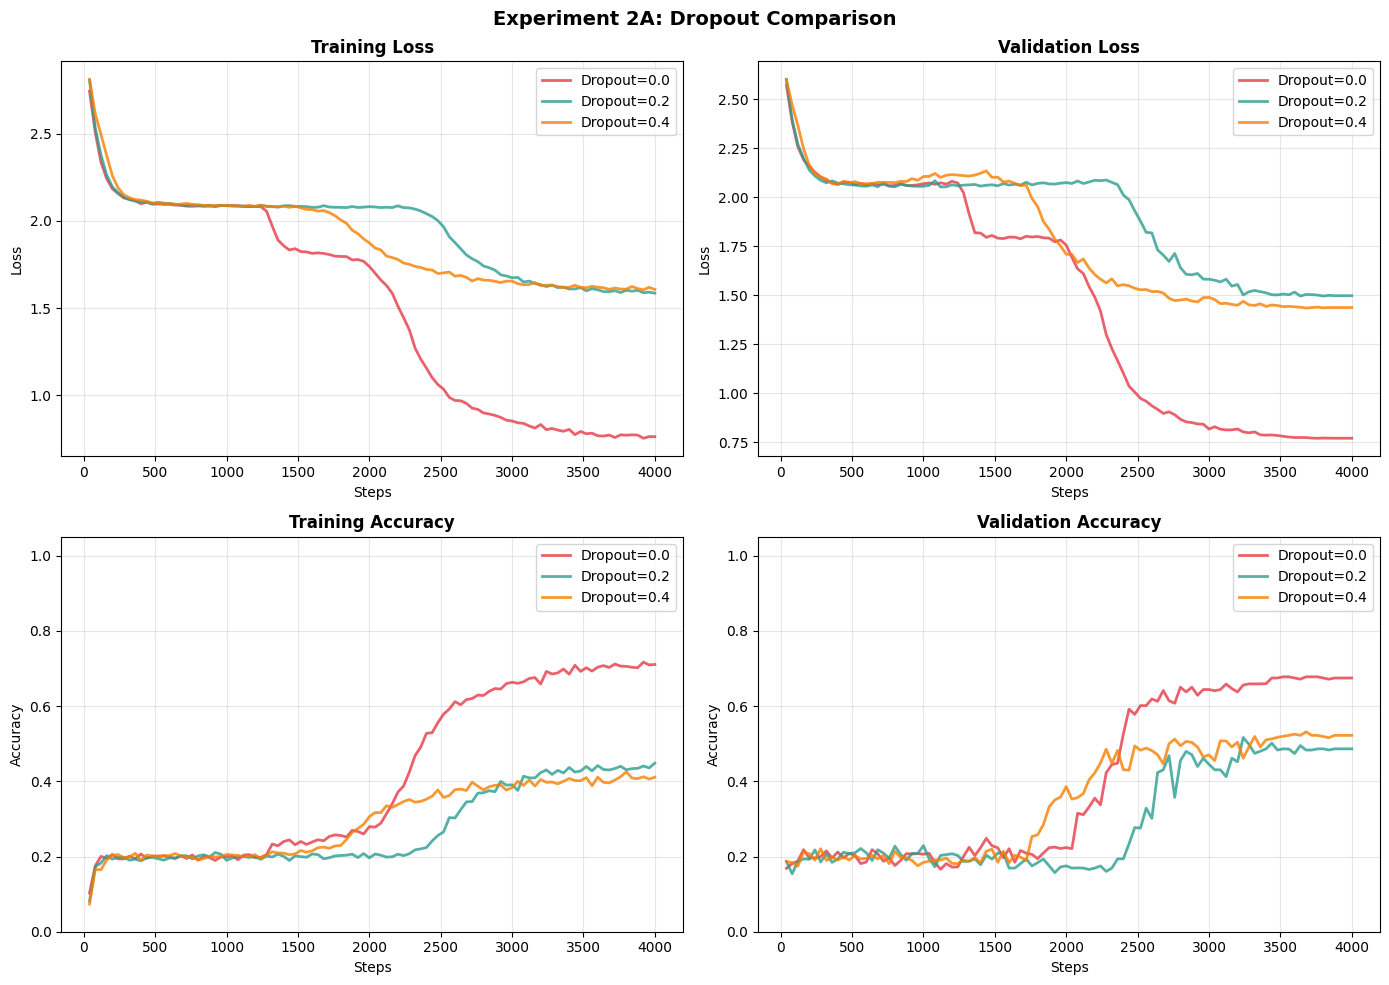


DROPOUT SWEEP SUMMARY
Dropout      Best Val Loss    Best Val Acc     Lag (Acc)      
------------------------------------------------------------
0.0          0.7709           0.6778           -400           
0.2          1.4958           0.5164           -760           
0.4          1.4349           0.5315           -120           


In [26]:
dropout_values = [0.0, 0.2, 0.4]
dropout_histories = {}

for dropout_prob in dropout_values:
    print(f"\nTraining with dropout={dropout_prob}")

    config_dropout = config.copy()
    config_dropout['dropout_prob'] = dropout_prob
    config_dropout['num_epochs'] = 100

    model_dropout = ModernDecoderLM(
        vocab_size=config_dropout['vocab_size'],
        d=config_dropout['d'],
        num_layers=config_dropout['num_layers'],
        num_heads=config_dropout['num_heads'],
        num_kv_groups=config_dropout['num_kv_groups'],
        d_ff=config_dropout['d_ff'],
        dropout_prob=config_dropout['dropout_prob']
    )
    model_dropout.apply(init_weights)

    history_dropout = train_model(model_dropout, train_loader, val_loader,
                                   vocab, config_dropout, device)
    dropout_histories[dropout_prob] = history_dropout

# Plot comparison of dropout values
print("\nPlotting dropout comparison...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'0.0': '#E63946', '0.2': '#2A9D8F', '0.4': '#F77F00'}

for dropout_prob, history in dropout_histories.items():
    color = colors[str(dropout_prob)]
    label = f'Dropout={dropout_prob}'

    axes[0, 0].plot(history['steps'], history['train_loss'],
                    label=label, alpha=0.8, linewidth=2, color=color)
    axes[0, 1].plot(history['steps'], history['val_loss'],
                    label=label, alpha=0.8, linewidth=2, color=color)
    axes[1, 0].plot(history['steps'], history['train_acc'],
                    label=label, alpha=0.8, linewidth=2, color=color)
    axes[1, 1].plot(history['steps'], history['val_acc'],
                    label=label, alpha=0.8, linewidth=2, color=color)

titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']
for ax, title in zip(axes.flat, titles):
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Steps', fontsize=10)
    ax.set_ylabel(title.split()[-1], fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    if 'Accuracy' in title:
        ax.set_ylim([0, 1.05])

plt.suptitle('Experiment 2A: Dropout Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('exp2a_dropout_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# SOLUTION: Summary table
print("\n" + "="*60)
print("DROPOUT SWEEP SUMMARY")
print("="*60)
print(f"{'Dropout':<12} {'Best Val Loss':<16} {'Best Val Acc':<16} {'Lag (Acc)':<15}")
print("-" * 60)
for dropout_prob, history in dropout_histories.items():
    metrics_drop = compute_summary_metrics(history)
    print(f"{dropout_prob:<12} {metrics_drop['best_val_loss']:<16.4f} "
          f"{metrics_drop['best_val_acc']:<16.4f} {metrics_drop['lag_acc']:<15}")
print("="*60)

In [27]:
print("\n" + "="*60)
print("DROPOUT SWEEP SUMMARY")
print("="*60)
print(f"{'Dropout':<12} {'Best Val Loss':<16} {'Best Val Acc':<16} {'Lag (Acc)':<15}")
print("-" * 60)
for dropout_prob, history in dropout_histories.items():
    metrics_drop = compute_summary_metrics(history)
    print(f"{dropout_prob:<12} {metrics_drop['best_val_loss']:<16.4f} "
          f"{metrics_drop['best_val_acc']:<16.4f} {metrics_drop['lag_acc']:<15}")
print("="*60)


DROPOUT SWEEP SUMMARY
Dropout      Best Val Loss    Best Val Acc     Lag (Acc)      
------------------------------------------------------------
0.0          0.7709           0.6778           -400           
0.2          1.4958           0.5164           -760           
0.4          1.4349           0.5315           -120           


In [28]:
# print("\n" + "="*80)
# print("TODO: Write your analysis in the PDF report [2 points]:")
# print("Address the following questions:")
# print("1. Which dropout value yields the best validation performance? Why?")
# print("2. Explain the trade-off between underfitting (too much dropout)")
# print("   and overfitting (too little dropout).")
# print("3. How does dropout affect the generalization lag?")
# print("4. Is there a clear optimal dropout rate for this task?")
# print("="*80 + "\n")

### Part B: Weight Decay Analysis [4 points]


Training with weight_decay=0.00025


Epoch 1/100: 100%|██████████| 40/40 [00:02<00:00, 15.24it/s, loss=2.67, acc=0.141] 


Epoch 1: Train Loss=2.7867, Train Acc=0.1027, Val Loss=2.5505, Val Acc=0.1900


Epoch 2/100: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s, loss=2.44, acc=0.156] 


Epoch 2: Train Loss=2.5263, Train Acc=0.1609, Val Loss=2.3772, Val Acc=0.1624


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=2.37, acc=0.172]


Epoch 3: Train Loss=2.3565, Train Acc=0.1887, Val Loss=2.2615, Val Acc=0.1942


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 16.96it/s, loss=2.22, acc=0.188]


Epoch 4: Train Loss=2.2519, Train Acc=0.1961, Val Loss=2.1987, Val Acc=0.1994


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 16.97it/s, loss=2.18, acc=0.188]


Epoch 5: Train Loss=2.1887, Train Acc=0.1910, Val Loss=2.1380, Val Acc=0.2025


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s, loss=2.24, acc=0.109] 


Epoch 6: Train Loss=2.1575, Train Acc=0.1867, Val Loss=2.1009, Val Acc=0.2062


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 16.51it/s, loss=2.09, acc=0.172] 


Epoch 7: Train Loss=2.1280, Train Acc=0.2020, Val Loss=2.0899, Val Acc=0.2082


Epoch 8/100: 100%|██████████| 40/40 [00:02<00:00, 15.73it/s, loss=2, acc=0.234]    


Epoch 8: Train Loss=2.1172, Train Acc=0.2012, Val Loss=2.0760, Val Acc=0.2113


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s, loss=2.1, acc=0.297] 


Epoch 9: Train Loss=2.1070, Train Acc=0.1973, Val Loss=2.0844, Val Acc=0.1911


Epoch 10/100: 100%|██████████| 40/40 [00:02<00:00, 15.03it/s, loss=2.26, acc=0.172]


Epoch 10: Train Loss=2.1025, Train Acc=0.1969, Val Loss=2.0640, Val Acc=0.2108


Epoch 11/100: 100%|██████████| 40/40 [00:02<00:00, 14.89it/s, loss=2.22, acc=0.172]


Epoch 11: Train Loss=2.1079, Train Acc=0.1988, Val Loss=2.0866, Val Acc=0.1963


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 14.73it/s, loss=2.01, acc=0.188]


Epoch 12: Train Loss=2.1016, Train Acc=0.1934, Val Loss=2.0679, Val Acc=0.2244


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 15.60it/s, loss=1.95, acc=0.266] 


Epoch 13: Train Loss=2.0941, Train Acc=0.2035, Val Loss=2.0752, Val Acc=0.1963


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 15.05it/s, loss=2.09, acc=0.203] 


Epoch 14: Train Loss=2.0956, Train Acc=0.1969, Val Loss=2.0662, Val Acc=0.1874


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 14.74it/s, loss=2.05, acc=0.25]  


Epoch 15: Train Loss=2.0903, Train Acc=0.1949, Val Loss=2.0734, Val Acc=0.2165


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 13.89it/s, loss=2.18, acc=0.141]


Epoch 16: Train Loss=2.0964, Train Acc=0.1941, Val Loss=2.0542, Val Acc=0.2176


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 15.06it/s, loss=2.18, acc=0.203]


Epoch 17: Train Loss=2.0918, Train Acc=0.1992, Val Loss=2.0573, Val Acc=0.2082


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s, loss=2.03, acc=0.188] 


Epoch 18: Train Loss=2.0901, Train Acc=0.1969, Val Loss=2.0577, Val Acc=0.2088


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 15.33it/s, loss=2.04, acc=0.234] 


Epoch 19: Train Loss=2.0836, Train Acc=0.2000, Val Loss=2.0613, Val Acc=0.2238


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 16.34it/s, loss=2.11, acc=0.156]


Epoch 20: Train Loss=2.0821, Train Acc=0.2000, Val Loss=2.0571, Val Acc=0.2051


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 14.55it/s, loss=2.13, acc=0.141]


Epoch 21: Train Loss=2.0880, Train Acc=0.1996, Val Loss=2.0653, Val Acc=0.1942


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 16.42it/s, loss=2.19, acc=0.141]


Epoch 22: Train Loss=2.0877, Train Acc=0.1953, Val Loss=2.0556, Val Acc=0.2181


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 15.51it/s, loss=2.22, acc=0.172]


Epoch 23: Train Loss=2.0862, Train Acc=0.1992, Val Loss=2.0581, Val Acc=0.1786


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 15.39it/s, loss=2.15, acc=0.156]


Epoch 24: Train Loss=2.0849, Train Acc=0.2000, Val Loss=2.0579, Val Acc=0.2238


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 15.46it/s, loss=1.94, acc=0.25]  


Epoch 25: Train Loss=2.0879, Train Acc=0.1969, Val Loss=2.0656, Val Acc=0.1905


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 15.78it/s, loss=2.14, acc=0.141]


Epoch 26: Train Loss=2.0865, Train Acc=0.2016, Val Loss=2.0562, Val Acc=0.2171


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=2.04, acc=0.156] 


Epoch 27: Train Loss=2.0877, Train Acc=0.1934, Val Loss=2.0577, Val Acc=0.1817


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 15.54it/s, loss=2.06, acc=0.219]


Epoch 28: Train Loss=2.0793, Train Acc=0.2055, Val Loss=2.0661, Val Acc=0.2067


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 15.93it/s, loss=2.09, acc=0.188] 


Epoch 29: Train Loss=2.0855, Train Acc=0.1910, Val Loss=2.0616, Val Acc=0.1942


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 17.18it/s, loss=2.15, acc=0.203]


Epoch 30: Train Loss=2.0874, Train Acc=0.2008, Val Loss=2.0609, Val Acc=0.2020


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 15.41it/s, loss=2.04, acc=0.203]


Epoch 31: Train Loss=2.0814, Train Acc=0.2016, Val Loss=2.0647, Val Acc=0.1843


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 15.89it/s, loss=2.02, acc=0.219] 


Epoch 32: Train Loss=2.0808, Train Acc=0.1918, Val Loss=2.0618, Val Acc=0.1926


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 16.90it/s, loss=2, acc=0.281]   


Epoch 33: Train Loss=2.0785, Train Acc=0.2016, Val Loss=2.0662, Val Acc=0.2046


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 15.68it/s, loss=2.09, acc=0.234] 


Epoch 34: Train Loss=2.0853, Train Acc=0.2027, Val Loss=2.0726, Val Acc=0.1869


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 16.58it/s, loss=2.22, acc=0.172] 


Epoch 35: Train Loss=2.0838, Train Acc=0.1953, Val Loss=2.0696, Val Acc=0.1843


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s, loss=2.1, acc=0.234]  


Epoch 36: Train Loss=2.0872, Train Acc=0.1949, Val Loss=2.0684, Val Acc=0.2082


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 16.69it/s, loss=1.99, acc=0.234]


Epoch 37: Train Loss=2.0783, Train Acc=0.1973, Val Loss=2.0637, Val Acc=0.1869


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 16.24it/s, loss=2.36, acc=0.219]


Epoch 38: Train Loss=2.0924, Train Acc=0.2008, Val Loss=2.1368, Val Acc=0.1754


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 15.79it/s, loss=2.07, acc=0.188]


Epoch 39: Train Loss=2.0881, Train Acc=0.1918, Val Loss=2.0611, Val Acc=0.1754


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 15.37it/s, loss=1.88, acc=0.312]


Epoch 40: Train Loss=2.0805, Train Acc=0.2059, Val Loss=2.0644, Val Acc=0.1817


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s, loss=2.25, acc=0.0938]


Epoch 41: Train Loss=2.0817, Train Acc=0.2004, Val Loss=2.0678, Val Acc=0.1786


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 15.11it/s, loss=1.98, acc=0.25] 


Epoch 42: Train Loss=2.0812, Train Acc=0.2055, Val Loss=2.0727, Val Acc=0.1812


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 16.91it/s, loss=2.11, acc=0.188]


Epoch 43: Train Loss=2.0834, Train Acc=0.2027, Val Loss=2.0746, Val Acc=0.1661


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=2.05, acc=0.266]


Epoch 44: Train Loss=2.0777, Train Acc=0.2008, Val Loss=2.0794, Val Acc=0.1869


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 16.94it/s, loss=2.16, acc=0.203]


Epoch 45: Train Loss=2.0788, Train Acc=0.2027, Val Loss=2.0838, Val Acc=0.1541


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 15.53it/s, loss=1.99, acc=0.203] 


Epoch 46: Train Loss=2.0803, Train Acc=0.1984, Val Loss=2.0790, Val Acc=0.1806


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 15.50it/s, loss=2.13, acc=0.172] 


Epoch 47: Train Loss=2.0831, Train Acc=0.2059, Val Loss=2.0875, Val Acc=0.1661


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 14.75it/s, loss=1.97, acc=0.266]


Epoch 48: Train Loss=2.0825, Train Acc=0.1922, Val Loss=2.0973, Val Acc=0.1687


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s, loss=1.98, acc=0.25] 


Epoch 49: Train Loss=2.0743, Train Acc=0.2117, Val Loss=2.1041, Val Acc=0.1655


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s, loss=2.19, acc=0.141]


Epoch 50: Train Loss=2.0765, Train Acc=0.2070, Val Loss=2.1027, Val Acc=0.1911


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 17.81it/s, loss=2.12, acc=0.188]


Epoch 51: Train Loss=2.0617, Train Acc=0.2238, Val Loss=2.0755, Val Acc=0.2093


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 17.48it/s, loss=1.92, acc=0.297]


Epoch 52: Train Loss=2.0156, Train Acc=0.2480, Val Loss=2.0050, Val Acc=0.2671


Epoch 53/100: 100%|██████████| 40/40 [00:02<00:00, 16.20it/s, loss=1.85, acc=0.312]


Epoch 53: Train Loss=1.9576, Train Acc=0.2727, Val Loss=1.9024, Val Acc=0.3180


Epoch 54/100: 100%|██████████| 40/40 [00:02<00:00, 15.78it/s, loss=1.95, acc=0.312]


Epoch 54: Train Loss=1.8843, Train Acc=0.3418, Val Loss=1.8080, Val Acc=0.3691


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 15.73it/s, loss=1.73, acc=0.469]


Epoch 55: Train Loss=1.7789, Train Acc=0.3867, Val Loss=1.6956, Val Acc=0.4274


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 15.22it/s, loss=1.67, acc=0.469]


Epoch 56: Train Loss=1.6866, Train Acc=0.4336, Val Loss=1.5819, Val Acc=0.4727


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.32it/s, loss=1.29, acc=0.578]


Epoch 57: Train Loss=1.6263, Train Acc=0.4371, Val Loss=1.5303, Val Acc=0.4664


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 16.73it/s, loss=1.5, acc=0.469] 


Epoch 58: Train Loss=1.5851, Train Acc=0.4598, Val Loss=1.4463, Val Acc=0.5404


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 15.13it/s, loss=1.59, acc=0.453]


Epoch 59: Train Loss=1.5188, Train Acc=0.4883, Val Loss=1.3886, Val Acc=0.5477


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 15.34it/s, loss=1.41, acc=0.516]


Epoch 60: Train Loss=1.4828, Train Acc=0.4852, Val Loss=1.3279, Val Acc=0.5497


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 16.63it/s, loss=1.29, acc=0.547]


Epoch 61: Train Loss=1.4070, Train Acc=0.5227, Val Loss=1.2718, Val Acc=0.5607


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s, loss=1.5, acc=0.469] 


Epoch 62: Train Loss=1.3848, Train Acc=0.5270, Val Loss=1.1856, Val Acc=0.6320


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 14.39it/s, loss=1.29, acc=0.516]


Epoch 63: Train Loss=1.3277, Train Acc=0.5402, Val Loss=1.1707, Val Acc=0.5966


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 16.63it/s, loss=1.21, acc=0.531]


Epoch 64: Train Loss=1.2636, Train Acc=0.5652, Val Loss=1.0910, Val Acc=0.6351


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 16.76it/s, loss=1.2, acc=0.562]  


Epoch 65: Train Loss=1.1936, Train Acc=0.5984, Val Loss=1.0582, Val Acc=0.6513


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 15.83it/s, loss=1.28, acc=0.578]


Epoch 66: Train Loss=1.1717, Train Acc=0.5863, Val Loss=0.9833, Val Acc=0.6820


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s, loss=1.04, acc=0.625] 


Epoch 67: Train Loss=1.1135, Train Acc=0.6086, Val Loss=0.9463, Val Acc=0.6971


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 14.86it/s, loss=0.941, acc=0.719]


Epoch 68: Train Loss=1.0662, Train Acc=0.6230, Val Loss=0.8843, Val Acc=0.6794


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 15.37it/s, loss=0.992, acc=0.641]


Epoch 69: Train Loss=1.0120, Train Acc=0.6602, Val Loss=0.8423, Val Acc=0.6976


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 15.58it/s, loss=0.809, acc=0.797]


Epoch 70: Train Loss=0.9706, Train Acc=0.6758, Val Loss=0.7928, Val Acc=0.7132


Epoch 71/100: 100%|██████████| 40/40 [00:02<00:00, 15.96it/s, loss=0.913, acc=0.703]


Epoch 71: Train Loss=0.9405, Train Acc=0.6844, Val Loss=0.7562, Val Acc=0.7351


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 15.59it/s, loss=0.824, acc=0.719]


Epoch 72: Train Loss=0.9209, Train Acc=0.6836, Val Loss=0.7091, Val Acc=0.7351


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=0.938, acc=0.703]


Epoch 73: Train Loss=0.8926, Train Acc=0.7063, Val Loss=0.6758, Val Acc=0.7804


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 15.06it/s, loss=0.859, acc=0.734]


Epoch 74: Train Loss=0.8631, Train Acc=0.7234, Val Loss=0.6743, Val Acc=0.7907


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=0.731, acc=0.828]


Epoch 75: Train Loss=0.8416, Train Acc=0.7277, Val Loss=0.6159, Val Acc=0.7892


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 15.52it/s, loss=0.924, acc=0.672]


Epoch 76: Train Loss=0.8171, Train Acc=0.7332, Val Loss=0.5829, Val Acc=0.8527


Epoch 77/100: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=0.819, acc=0.781]


Epoch 77: Train Loss=0.8055, Train Acc=0.7391, Val Loss=0.5817, Val Acc=0.8433


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 16.92it/s, loss=0.702, acc=0.766]


Epoch 78: Train Loss=0.7862, Train Acc=0.7512, Val Loss=0.6087, Val Acc=0.8251


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 14.32it/s, loss=0.786, acc=0.766]


Epoch 79: Train Loss=0.7910, Train Acc=0.7465, Val Loss=0.5692, Val Acc=0.8131


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 13.57it/s, loss=0.636, acc=0.828]


Epoch 80: Train Loss=0.7541, Train Acc=0.7707, Val Loss=0.5433, Val Acc=0.8470


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 16.98it/s, loss=0.851, acc=0.734]


Epoch 81: Train Loss=0.7390, Train Acc=0.7672, Val Loss=0.5289, Val Acc=0.8470


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 15.93it/s, loss=0.715, acc=0.688]


Epoch 82: Train Loss=0.7199, Train Acc=0.7738, Val Loss=0.5127, Val Acc=0.8683


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 16.84it/s, loss=0.568, acc=0.828]


Epoch 83: Train Loss=0.7142, Train Acc=0.7723, Val Loss=0.5117, Val Acc=0.8829


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 15.98it/s, loss=0.638, acc=0.766]


Epoch 84: Train Loss=0.7181, Train Acc=0.7789, Val Loss=0.4952, Val Acc=0.8865


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 17.30it/s, loss=0.736, acc=0.781]


Epoch 85: Train Loss=0.6906, Train Acc=0.7953, Val Loss=0.4873, Val Acc=0.8876


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 17.04it/s, loss=0.747, acc=0.797]


Epoch 86: Train Loss=0.7041, Train Acc=0.7758, Val Loss=0.4861, Val Acc=0.8746


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 17.17it/s, loss=0.671, acc=0.797]


Epoch 87: Train Loss=0.6904, Train Acc=0.7863, Val Loss=0.4759, Val Acc=0.8990


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=0.715, acc=0.781]


Epoch 88: Train Loss=0.6870, Train Acc=0.7902, Val Loss=0.4748, Val Acc=0.8990


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 16.70it/s, loss=0.631, acc=0.797]


Epoch 89: Train Loss=0.6773, Train Acc=0.7891, Val Loss=0.4719, Val Acc=0.9021


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s, loss=0.632, acc=0.781]


Epoch 90: Train Loss=0.6755, Train Acc=0.7875, Val Loss=0.4679, Val Acc=0.8959


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=0.749, acc=0.766]


Epoch 91: Train Loss=0.6816, Train Acc=0.7848, Val Loss=0.4629, Val Acc=0.9021


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 16.00it/s, loss=0.625, acc=0.766]


Epoch 92: Train Loss=0.6749, Train Acc=0.7922, Val Loss=0.4614, Val Acc=0.9079


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=0.607, acc=0.828]


Epoch 93: Train Loss=0.6682, Train Acc=0.7934, Val Loss=0.4605, Val Acc=0.9047


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 16.11it/s, loss=0.651, acc=0.766]


Epoch 94: Train Loss=0.6714, Train Acc=0.7820, Val Loss=0.4574, Val Acc=0.9016


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s, loss=0.581, acc=0.828]


Epoch 95: Train Loss=0.6787, Train Acc=0.7867, Val Loss=0.4584, Val Acc=0.9047


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 15.23it/s, loss=0.777, acc=0.672]


Epoch 96: Train Loss=0.6787, Train Acc=0.7898, Val Loss=0.4576, Val Acc=0.9079


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s, loss=0.616, acc=0.828]


Epoch 97: Train Loss=0.6679, Train Acc=0.7945, Val Loss=0.4556, Val Acc=0.9079


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s, loss=0.607, acc=0.844]


Epoch 98: Train Loss=0.6729, Train Acc=0.7980, Val Loss=0.4554, Val Acc=0.9110


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 14.72it/s, loss=0.633, acc=0.812]


Epoch 99: Train Loss=0.6766, Train Acc=0.7984, Val Loss=0.4552, Val Acc=0.9110


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 16.56it/s, loss=0.626, acc=0.812]


Epoch 100: Train Loss=0.6584, Train Acc=0.8000, Val Loss=0.4552, Val Acc=0.9110

Training with weight_decay=0.0005


Epoch 1/100: 100%|██████████| 40/40 [00:02<00:00, 16.06it/s, loss=2.63, acc=0.172] 


Epoch 1: Train Loss=2.7830, Train Acc=0.0801, Val Loss=2.5602, Val Acc=0.1869


Epoch 2/100: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=2.53, acc=0.0938]


Epoch 2: Train Loss=2.5342, Train Acc=0.1605, Val Loss=2.4117, Val Acc=0.1780


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 15.55it/s, loss=2.36, acc=0.219] 


Epoch 3: Train Loss=2.3866, Train Acc=0.1887, Val Loss=2.2908, Val Acc=0.1963


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 17.92it/s, loss=2.27, acc=0.156] 


Epoch 4: Train Loss=2.2686, Train Acc=0.2059, Val Loss=2.1981, Val Acc=0.1572


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 17.76it/s, loss=2.07, acc=0.25] 


Epoch 5: Train Loss=2.2039, Train Acc=0.1980, Val Loss=2.1506, Val Acc=0.2124


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 16.98it/s, loss=2.06, acc=0.266] 


Epoch 6: Train Loss=2.1639, Train Acc=0.1984, Val Loss=2.1095, Val Acc=0.1723


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 16.56it/s, loss=2.14, acc=0.172] 


Epoch 7: Train Loss=2.1321, Train Acc=0.2012, Val Loss=2.0905, Val Acc=0.2238


Epoch 8/100: 100%|██████████| 40/40 [00:02<00:00, 17.24it/s, loss=2.06, acc=0.25] 


Epoch 8: Train Loss=2.1247, Train Acc=0.1969, Val Loss=2.0884, Val Acc=0.1874


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 14.78it/s, loss=2.14, acc=0.156] 


Epoch 9: Train Loss=2.1137, Train Acc=0.1961, Val Loss=2.0771, Val Acc=0.1812


Epoch 10/100: 100%|██████████| 40/40 [00:02<00:00, 14.57it/s, loss=2.06, acc=0.219] 


Epoch 10: Train Loss=2.1046, Train Acc=0.2047, Val Loss=2.0782, Val Acc=0.1822


Epoch 11/100: 100%|██████████| 40/40 [00:03<00:00, 13.19it/s, loss=2.16, acc=0.203]


Epoch 11: Train Loss=2.0991, Train Acc=0.2055, Val Loss=2.0674, Val Acc=0.1931


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 14.03it/s, loss=2.13, acc=0.172]


Epoch 12: Train Loss=2.1027, Train Acc=0.2000, Val Loss=2.0630, Val Acc=0.2290


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 14.27it/s, loss=1.96, acc=0.25] 


Epoch 13: Train Loss=2.0939, Train Acc=0.2000, Val Loss=2.0619, Val Acc=0.1895


Epoch 14/100: 100%|██████████| 40/40 [00:03<00:00, 12.78it/s, loss=1.92, acc=0.328] 


Epoch 14: Train Loss=2.0957, Train Acc=0.2000, Val Loss=2.0647, Val Acc=0.2238


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 15.39it/s, loss=2.19, acc=0.172]


Epoch 15: Train Loss=2.0960, Train Acc=0.1934, Val Loss=2.0590, Val Acc=0.2108


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 14.09it/s, loss=2.14, acc=0.156] 


Epoch 16: Train Loss=2.0913, Train Acc=0.1941, Val Loss=2.0607, Val Acc=0.2181


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 14.31it/s, loss=2.2, acc=0.125] 


Epoch 17: Train Loss=2.0921, Train Acc=0.2020, Val Loss=2.0661, Val Acc=0.1942


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 14.04it/s, loss=2, acc=0.297]    


Epoch 18: Train Loss=2.0881, Train Acc=0.2066, Val Loss=2.0715, Val Acc=0.2077


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 16.04it/s, loss=2.07, acc=0.219]


Epoch 19: Train Loss=2.0961, Train Acc=0.1941, Val Loss=2.0634, Val Acc=0.1937


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 16.00it/s, loss=2.22, acc=0.141] 


Epoch 20: Train Loss=2.0841, Train Acc=0.1926, Val Loss=2.0681, Val Acc=0.2098


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 14.60it/s, loss=2.18, acc=0.141]


Epoch 21: Train Loss=2.0895, Train Acc=0.2020, Val Loss=2.0550, Val Acc=0.2082


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 17.34it/s, loss=1.87, acc=0.266] 


Epoch 22: Train Loss=2.0880, Train Acc=0.1910, Val Loss=2.0723, Val Acc=0.1963


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 16.58it/s, loss=1.96, acc=0.25] 


Epoch 23: Train Loss=2.0819, Train Acc=0.1988, Val Loss=2.0560, Val Acc=0.2088


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 15.48it/s, loss=2.13, acc=0.188]


Epoch 24: Train Loss=2.0836, Train Acc=0.2004, Val Loss=2.0742, Val Acc=0.1963


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 16.05it/s, loss=2.24, acc=0.0938]


Epoch 25: Train Loss=2.0846, Train Acc=0.1953, Val Loss=2.0629, Val Acc=0.2108


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 16.23it/s, loss=2.14, acc=0.172]


Epoch 26: Train Loss=2.0903, Train Acc=0.1996, Val Loss=2.0570, Val Acc=0.1854


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 15.86it/s, loss=2.05, acc=0.219] 


Epoch 27: Train Loss=2.0804, Train Acc=0.2051, Val Loss=2.0550, Val Acc=0.1848


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=2.02, acc=0.234] 


Epoch 28: Train Loss=2.0780, Train Acc=0.2023, Val Loss=2.0656, Val Acc=0.2072


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 15.86it/s, loss=2.04, acc=0.188]


Epoch 29: Train Loss=2.0853, Train Acc=0.2004, Val Loss=2.0722, Val Acc=0.1786


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 16.39it/s, loss=2.11, acc=0.203]


Epoch 30: Train Loss=2.0796, Train Acc=0.2074, Val Loss=2.0660, Val Acc=0.1723


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=1.97, acc=0.234]


Epoch 31: Train Loss=2.0830, Train Acc=0.1980, Val Loss=2.0734, Val Acc=0.1895


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 16.56it/s, loss=2.01, acc=0.188]


Epoch 32: Train Loss=2.0869, Train Acc=0.1988, Val Loss=2.0649, Val Acc=0.2051


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 15.89it/s, loss=2.24, acc=0.0938]


Epoch 33: Train Loss=2.0839, Train Acc=0.2039, Val Loss=2.0764, Val Acc=0.2082


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 16.63it/s, loss=2.04, acc=0.25] 


Epoch 34: Train Loss=2.0851, Train Acc=0.1992, Val Loss=2.0782, Val Acc=0.1629


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 16.57it/s, loss=2.16, acc=0.172] 


Epoch 35: Train Loss=2.0780, Train Acc=0.2027, Val Loss=2.0637, Val Acc=0.1718


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 15.39it/s, loss=2.26, acc=0.0625]


Epoch 36: Train Loss=2.0710, Train Acc=0.2012, Val Loss=2.0947, Val Acc=0.1957


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=2.15, acc=0.203]


Epoch 37: Train Loss=2.0589, Train Acc=0.2223, Val Loss=2.0728, Val Acc=0.1931


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 14.73it/s, loss=2.08, acc=0.219]


Epoch 38: Train Loss=2.0420, Train Acc=0.2281, Val Loss=2.0296, Val Acc=0.2113


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 14.71it/s, loss=1.83, acc=0.344]


Epoch 39: Train Loss=2.0026, Train Acc=0.2512, Val Loss=1.9815, Val Acc=0.2213


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 15.04it/s, loss=1.91, acc=0.234]


Epoch 40: Train Loss=1.9032, Train Acc=0.2629, Val Loss=1.8480, Val Acc=0.2389


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 14.29it/s, loss=1.87, acc=0.25] 


Epoch 41: Train Loss=1.8073, Train Acc=0.2930, Val Loss=1.8051, Val Acc=0.2577


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 13.53it/s, loss=1.65, acc=0.422]


Epoch 42: Train Loss=1.7505, Train Acc=0.3094, Val Loss=1.7361, Val Acc=0.2520


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 14.11it/s, loss=1.58, acc=0.359]


Epoch 43: Train Loss=1.6600, Train Acc=0.3477, Val Loss=1.5915, Val Acc=0.3357


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 14.36it/s, loss=1.69, acc=0.375]


Epoch 44: Train Loss=1.6231, Train Acc=0.3461, Val Loss=1.5247, Val Acc=0.3664


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 14.84it/s, loss=1.68, acc=0.344]


Epoch 45: Train Loss=1.5488, Train Acc=0.3730, Val Loss=1.4896, Val Acc=0.3467


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 14.23it/s, loss=1.5, acc=0.359] 


Epoch 46: Train Loss=1.4963, Train Acc=0.3953, Val Loss=1.4589, Val Acc=0.3191


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 15.19it/s, loss=1.46, acc=0.359]


Epoch 47: Train Loss=1.4425, Train Acc=0.4090, Val Loss=1.3442, Val Acc=0.4336


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 14.00it/s, loss=1.53, acc=0.453]


Epoch 48: Train Loss=1.3893, Train Acc=0.4355, Val Loss=1.3387, Val Acc=0.4398


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 15.45it/s, loss=1.41, acc=0.375]


Epoch 49: Train Loss=1.3505, Train Acc=0.4430, Val Loss=1.2590, Val Acc=0.4685


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 15.83it/s, loss=1.42, acc=0.375]


Epoch 50: Train Loss=1.3285, Train Acc=0.4539, Val Loss=1.3048, Val Acc=0.3852


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=1.29, acc=0.531]


Epoch 51: Train Loss=1.2788, Train Acc=0.4754, Val Loss=1.1969, Val Acc=0.4737


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s, loss=1.25, acc=0.438]


Epoch 52: Train Loss=1.2660, Train Acc=0.4910, Val Loss=1.1495, Val Acc=0.5237


Epoch 53/100: 100%|██████████| 40/40 [00:02<00:00, 14.63it/s, loss=1.26, acc=0.438]


Epoch 53: Train Loss=1.2206, Train Acc=0.4863, Val Loss=1.1341, Val Acc=0.5127


Epoch 54/100: 100%|██████████| 40/40 [00:02<00:00, 16.12it/s, loss=1.25, acc=0.453]


Epoch 54: Train Loss=1.2340, Train Acc=0.4887, Val Loss=1.1178, Val Acc=0.5621


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 15.67it/s, loss=1.16, acc=0.594]


Epoch 55: Train Loss=1.1850, Train Acc=0.5043, Val Loss=1.1288, Val Acc=0.5013


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=1.11, acc=0.531] 


Epoch 56: Train Loss=1.1525, Train Acc=0.5230, Val Loss=1.1601, Val Acc=0.4580


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.53it/s, loss=1.24, acc=0.484]


Epoch 57: Train Loss=1.1692, Train Acc=0.5105, Val Loss=1.0612, Val Acc=0.5549


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 15.80it/s, loss=0.964, acc=0.625]


Epoch 58: Train Loss=1.1185, Train Acc=0.5410, Val Loss=1.0369, Val Acc=0.5695


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 15.35it/s, loss=0.999, acc=0.641]


Epoch 59: Train Loss=1.1249, Train Acc=0.5465, Val Loss=1.0052, Val Acc=0.5971


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 15.61it/s, loss=0.948, acc=0.609]


Epoch 60: Train Loss=1.0852, Train Acc=0.5504, Val Loss=0.9911, Val Acc=0.6085


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 17.49it/s, loss=0.966, acc=0.656]


Epoch 61: Train Loss=1.0424, Train Acc=0.5957, Val Loss=1.0221, Val Acc=0.5533


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 16.09it/s, loss=0.96, acc=0.641] 


Epoch 62: Train Loss=1.0432, Train Acc=0.5820, Val Loss=0.9924, Val Acc=0.5861


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 16.81it/s, loss=0.924, acc=0.641]


Epoch 63: Train Loss=1.0239, Train Acc=0.5965, Val Loss=0.9378, Val Acc=0.6204


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 15.49it/s, loss=0.86, acc=0.672] 


Epoch 64: Train Loss=1.0214, Train Acc=0.5969, Val Loss=0.8978, Val Acc=0.6736


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 15.94it/s, loss=0.991, acc=0.578]


Epoch 65: Train Loss=0.9955, Train Acc=0.5969, Val Loss=0.9047, Val Acc=0.6449


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 15.75it/s, loss=1.04, acc=0.578] 


Epoch 66: Train Loss=0.9755, Train Acc=0.6141, Val Loss=0.8454, Val Acc=0.6522


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 16.69it/s, loss=0.976, acc=0.641]


Epoch 67: Train Loss=0.9575, Train Acc=0.6188, Val Loss=0.8663, Val Acc=0.6736


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s, loss=0.995, acc=0.594]


Epoch 68: Train Loss=0.9371, Train Acc=0.6340, Val Loss=0.8348, Val Acc=0.6679


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s, loss=0.966, acc=0.625]


Epoch 69: Train Loss=0.9248, Train Acc=0.6398, Val Loss=0.8486, Val Acc=0.6819


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 15.79it/s, loss=0.957, acc=0.672]


Epoch 70: Train Loss=0.9049, Train Acc=0.6520, Val Loss=0.8170, Val Acc=0.6756


Epoch 71/100: 100%|██████████| 40/40 [00:02<00:00, 15.60it/s, loss=0.934, acc=0.672]


Epoch 71: Train Loss=0.8947, Train Acc=0.6551, Val Loss=0.7848, Val Acc=0.7168


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 15.49it/s, loss=0.734, acc=0.781]


Epoch 72: Train Loss=0.8658, Train Acc=0.6641, Val Loss=0.7732, Val Acc=0.7157


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 15.51it/s, loss=0.804, acc=0.688]


Epoch 73: Train Loss=0.8610, Train Acc=0.6805, Val Loss=0.7456, Val Acc=0.7225


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 15.92it/s, loss=0.919, acc=0.609]


Epoch 74: Train Loss=0.8394, Train Acc=0.6973, Val Loss=0.7632, Val Acc=0.6954


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s, loss=0.77, acc=0.75]  


Epoch 75: Train Loss=0.8148, Train Acc=0.6996, Val Loss=0.7367, Val Acc=0.7277


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 16.56it/s, loss=0.803, acc=0.719]


Epoch 76: Train Loss=0.7942, Train Acc=0.7125, Val Loss=0.7052, Val Acc=0.7553


Epoch 77/100: 100%|██████████| 40/40 [00:02<00:00, 16.40it/s, loss=0.865, acc=0.703]


Epoch 77: Train Loss=0.7856, Train Acc=0.7223, Val Loss=0.6971, Val Acc=0.7527


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 16.04it/s, loss=0.651, acc=0.734]


Epoch 78: Train Loss=0.7918, Train Acc=0.7148, Val Loss=0.6755, Val Acc=0.7646


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 15.39it/s, loss=0.686, acc=0.75] 


Epoch 79: Train Loss=0.7874, Train Acc=0.7145, Val Loss=0.6578, Val Acc=0.7709


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 14.34it/s, loss=0.834, acc=0.656]


Epoch 80: Train Loss=0.7680, Train Acc=0.7172, Val Loss=0.6563, Val Acc=0.7683


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s, loss=0.768, acc=0.766]


Epoch 81: Train Loss=0.7431, Train Acc=0.7383, Val Loss=0.6343, Val Acc=0.7922


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 14.48it/s, loss=0.697, acc=0.844]


Epoch 82: Train Loss=0.7396, Train Acc=0.7418, Val Loss=0.6357, Val Acc=0.7865


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 13.38it/s, loss=0.82, acc=0.703] 


Epoch 83: Train Loss=0.7291, Train Acc=0.7395, Val Loss=0.6191, Val Acc=0.7959


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 14.31it/s, loss=0.78, acc=0.672] 


Epoch 84: Train Loss=0.7162, Train Acc=0.7559, Val Loss=0.6174, Val Acc=0.7959


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 14.77it/s, loss=0.608, acc=0.797]


Epoch 85: Train Loss=0.7245, Train Acc=0.7438, Val Loss=0.6051, Val Acc=0.8053


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 14.84it/s, loss=0.514, acc=0.891]


Epoch 86: Train Loss=0.6968, Train Acc=0.7629, Val Loss=0.5895, Val Acc=0.8053


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 14.43it/s, loss=0.631, acc=0.797]


Epoch 87: Train Loss=0.6970, Train Acc=0.7668, Val Loss=0.5723, Val Acc=0.8204


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 14.32it/s, loss=0.691, acc=0.844]


Epoch 88: Train Loss=0.6954, Train Acc=0.7629, Val Loss=0.5791, Val Acc=0.8079


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 13.73it/s, loss=0.72, acc=0.734] 


Epoch 89: Train Loss=0.6886, Train Acc=0.7672, Val Loss=0.5743, Val Acc=0.8141


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s, loss=0.753, acc=0.703]


Epoch 90: Train Loss=0.6946, Train Acc=0.7668, Val Loss=0.5802, Val Acc=0.8079


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 14.79it/s, loss=0.644, acc=0.781]


Epoch 91: Train Loss=0.6801, Train Acc=0.7691, Val Loss=0.5669, Val Acc=0.8053


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 15.89it/s, loss=0.764, acc=0.734]


Epoch 92: Train Loss=0.6890, Train Acc=0.7574, Val Loss=0.5689, Val Acc=0.7990


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 16.03it/s, loss=0.707, acc=0.734]


Epoch 93: Train Loss=0.6918, Train Acc=0.7680, Val Loss=0.5770, Val Acc=0.8021


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=0.737, acc=0.734]


Epoch 94: Train Loss=0.6717, Train Acc=0.7730, Val Loss=0.5687, Val Acc=0.8053


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s, loss=0.584, acc=0.859]


Epoch 95: Train Loss=0.6608, Train Acc=0.7773, Val Loss=0.5674, Val Acc=0.8084


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 16.51it/s, loss=0.783, acc=0.75] 


Epoch 96: Train Loss=0.6600, Train Acc=0.7766, Val Loss=0.5646, Val Acc=0.8021


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 16.05it/s, loss=0.693, acc=0.766]


Epoch 97: Train Loss=0.6657, Train Acc=0.7762, Val Loss=0.5637, Val Acc=0.8084


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 16.68it/s, loss=0.673, acc=0.719]


Epoch 98: Train Loss=0.6771, Train Acc=0.7543, Val Loss=0.5642, Val Acc=0.8141


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 16.58it/s, loss=0.515, acc=0.906]


Epoch 99: Train Loss=0.6606, Train Acc=0.7730, Val Loss=0.5646, Val Acc=0.8141


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 16.26it/s, loss=0.549, acc=0.844]


Epoch 100: Train Loss=0.6701, Train Acc=0.7730, Val Loss=0.5646, Val Acc=0.8141

Training with weight_decay=0.001


Epoch 1/100: 100%|██████████| 40/40 [00:02<00:00, 16.07it/s, loss=2.62, acc=0.156] 


Epoch 1: Train Loss=2.8203, Train Acc=0.0664, Val Loss=2.5746, Val Acc=0.1900


Epoch 2/100: 100%|██████████| 40/40 [00:02<00:00, 15.49it/s, loss=2.39, acc=0.25]  


Epoch 2: Train Loss=2.4998, Train Acc=0.1727, Val Loss=2.3758, Val Acc=0.1973


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 15.71it/s, loss=2.3, acc=0.188]  


Epoch 3: Train Loss=2.3477, Train Acc=0.1871, Val Loss=2.2478, Val Acc=0.1911


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 16.79it/s, loss=2.23, acc=0.172]


Epoch 4: Train Loss=2.2402, Train Acc=0.1996, Val Loss=2.1799, Val Acc=0.1874


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=2.03, acc=0.281] 


Epoch 5: Train Loss=2.1819, Train Acc=0.1914, Val Loss=2.1390, Val Acc=0.1838


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 15.97it/s, loss=2.23, acc=0.188]


Epoch 6: Train Loss=2.1531, Train Acc=0.1938, Val Loss=2.0922, Val Acc=0.2155


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s, loss=2.13, acc=0.266] 


Epoch 7: Train Loss=2.1284, Train Acc=0.1984, Val Loss=2.1090, Val Acc=0.1926


Epoch 8/100: 100%|██████████| 40/40 [00:02<00:00, 14.79it/s, loss=2.09, acc=0.219]


Epoch 8: Train Loss=2.1178, Train Acc=0.1977, Val Loss=2.0786, Val Acc=0.1994


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 13.87it/s, loss=2.14, acc=0.172]


Epoch 9: Train Loss=2.1158, Train Acc=0.1980, Val Loss=2.0862, Val Acc=0.2077


Epoch 10/100: 100%|██████████| 40/40 [00:02<00:00, 14.16it/s, loss=2.27, acc=0.141]


Epoch 10: Train Loss=2.1049, Train Acc=0.2035, Val Loss=2.0699, Val Acc=0.2108


Epoch 11/100: 100%|██████████| 40/40 [00:02<00:00, 13.69it/s, loss=2.09, acc=0.203]


Epoch 11: Train Loss=2.1037, Train Acc=0.1887, Val Loss=2.0817, Val Acc=0.1848


Epoch 12/100: 100%|██████████| 40/40 [00:03<00:00, 12.87it/s, loss=2.1, acc=0.172] 


Epoch 12: Train Loss=2.1034, Train Acc=0.1977, Val Loss=2.0753, Val Acc=0.2244


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=2.12, acc=0.172]


Epoch 13: Train Loss=2.0946, Train Acc=0.1988, Val Loss=2.0661, Val Acc=0.2270


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 13.48it/s, loss=2.12, acc=0.156] 


Epoch 14: Train Loss=2.0950, Train Acc=0.1941, Val Loss=2.0737, Val Acc=0.1963


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 14.77it/s, loss=2.01, acc=0.203]


Epoch 15: Train Loss=2.0974, Train Acc=0.1941, Val Loss=2.0647, Val Acc=0.2108


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 14.80it/s, loss=2.04, acc=0.25] 


Epoch 16: Train Loss=2.0913, Train Acc=0.2031, Val Loss=2.0763, Val Acc=0.1963


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 14.88it/s, loss=1.9, acc=0.266] 


Epoch 17: Train Loss=2.0904, Train Acc=0.2078, Val Loss=2.0513, Val Acc=0.2301


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 14.40it/s, loss=2.21, acc=0.172]


Epoch 18: Train Loss=2.0899, Train Acc=0.1949, Val Loss=2.0548, Val Acc=0.2244


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s, loss=1.9, acc=0.297]  


Epoch 19: Train Loss=2.0904, Train Acc=0.2008, Val Loss=2.0765, Val Acc=0.2077


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 16.85it/s, loss=2.12, acc=0.156] 


Epoch 20: Train Loss=2.0875, Train Acc=0.2016, Val Loss=2.0586, Val Acc=0.2108


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 17.57it/s, loss=2.19, acc=0.156]


Epoch 21: Train Loss=2.0893, Train Acc=0.2008, Val Loss=2.0706, Val Acc=0.1931


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 16.89it/s, loss=2.21, acc=0.125]


Epoch 22: Train Loss=2.0830, Train Acc=0.1980, Val Loss=2.0571, Val Acc=0.1812


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 17.07it/s, loss=2.07, acc=0.219] 


Epoch 23: Train Loss=2.0859, Train Acc=0.1973, Val Loss=2.0642, Val Acc=0.2218


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 16.27it/s, loss=2, acc=0.203]    


Epoch 24: Train Loss=2.0889, Train Acc=0.1930, Val Loss=2.0626, Val Acc=0.1879


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s, loss=2.23, acc=0.141]


Epoch 25: Train Loss=2.0897, Train Acc=0.1961, Val Loss=2.0627, Val Acc=0.1812


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 16.92it/s, loss=2.12, acc=0.188] 


Epoch 26: Train Loss=2.0851, Train Acc=0.1977, Val Loss=2.0751, Val Acc=0.1937


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 15.77it/s, loss=2.15, acc=0.156] 


Epoch 27: Train Loss=2.0830, Train Acc=0.2031, Val Loss=2.0754, Val Acc=0.1869


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 16.04it/s, loss=1.94, acc=0.281]


Epoch 28: Train Loss=2.0848, Train Acc=0.1988, Val Loss=2.0694, Val Acc=0.1869


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 16.72it/s, loss=2.02, acc=0.219] 


Epoch 29: Train Loss=2.0868, Train Acc=0.2012, Val Loss=2.0628, Val Acc=0.1812


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s, loss=1.9, acc=0.25]  


Epoch 30: Train Loss=2.0890, Train Acc=0.1961, Val Loss=2.0627, Val Acc=0.1895


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 15.62it/s, loss=1.97, acc=0.219]


Epoch 31: Train Loss=2.0818, Train Acc=0.2035, Val Loss=2.0771, Val Acc=0.1885


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 15.22it/s, loss=2.05, acc=0.188] 


Epoch 32: Train Loss=2.0777, Train Acc=0.2059, Val Loss=2.0609, Val Acc=0.1812


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s, loss=2.17, acc=0.125]


Epoch 33: Train Loss=2.0828, Train Acc=0.2031, Val Loss=2.0705, Val Acc=0.1957


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 15.03it/s, loss=2.01, acc=0.234]


Epoch 34: Train Loss=2.0818, Train Acc=0.2043, Val Loss=2.0697, Val Acc=0.1723


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 16.22it/s, loss=2.11, acc=0.203]


Epoch 35: Train Loss=2.0805, Train Acc=0.1984, Val Loss=2.0732, Val Acc=0.1900


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 15.74it/s, loss=2.01, acc=0.219] 


Epoch 36: Train Loss=2.0829, Train Acc=0.1992, Val Loss=2.0622, Val Acc=0.1655


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s, loss=2.07, acc=0.234]


Epoch 37: Train Loss=2.0815, Train Acc=0.1996, Val Loss=2.0660, Val Acc=0.1723


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 16.27it/s, loss=2.12, acc=0.219]


Epoch 38: Train Loss=2.0808, Train Acc=0.2055, Val Loss=2.0690, Val Acc=0.1879


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 15.54it/s, loss=1.91, acc=0.219]


Epoch 39: Train Loss=2.0794, Train Acc=0.1988, Val Loss=2.0703, Val Acc=0.1968


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 15.42it/s, loss=2.07, acc=0.203] 


Epoch 40: Train Loss=2.0848, Train Acc=0.1938, Val Loss=2.0794, Val Acc=0.1843


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s, loss=2.01, acc=0.188] 


Epoch 41: Train Loss=2.0831, Train Acc=0.1996, Val Loss=2.0774, Val Acc=0.1817


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 16.33it/s, loss=2.04, acc=0.188] 


Epoch 42: Train Loss=2.0776, Train Acc=0.2133, Val Loss=2.0759, Val Acc=0.1780


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 15.49it/s, loss=2.11, acc=0.219] 


Epoch 43: Train Loss=2.0780, Train Acc=0.2043, Val Loss=2.0823, Val Acc=0.2036


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=2.01, acc=0.219]


Epoch 44: Train Loss=2.0767, Train Acc=0.2094, Val Loss=2.0905, Val Acc=0.1598


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 14.95it/s, loss=2.26, acc=0.156]


Epoch 45: Train Loss=2.0796, Train Acc=0.1988, Val Loss=2.0852, Val Acc=0.1775


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 14.88it/s, loss=2.15, acc=0.141]


Epoch 46: Train Loss=2.0817, Train Acc=0.2066, Val Loss=2.0865, Val Acc=0.1661


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 14.46it/s, loss=2.14, acc=0.141]


Epoch 47: Train Loss=2.0737, Train Acc=0.2074, Val Loss=2.0962, Val Acc=0.1598


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 14.74it/s, loss=2.01, acc=0.234]


Epoch 48: Train Loss=2.0624, Train Acc=0.2086, Val Loss=2.0833, Val Acc=0.1874


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=2.03, acc=0.281]


Epoch 49: Train Loss=2.0325, Train Acc=0.2301, Val Loss=2.0172, Val Acc=0.2056


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 14.52it/s, loss=2.01, acc=0.172]


Epoch 50: Train Loss=1.9734, Train Acc=0.2520, Val Loss=1.9055, Val Acc=0.2832


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s, loss=1.68, acc=0.438]


Epoch 51: Train Loss=1.8892, Train Acc=0.3023, Val Loss=1.7763, Val Acc=0.3722


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=1.8, acc=0.297] 


Epoch 52: Train Loss=1.8180, Train Acc=0.3148, Val Loss=1.7009, Val Acc=0.4081


Epoch 53/100: 100%|██████████| 40/40 [00:03<00:00, 13.23it/s, loss=1.71, acc=0.391]


Epoch 53: Train Loss=1.7715, Train Acc=0.3453, Val Loss=1.6473, Val Acc=0.4331


Epoch 54/100: 100%|██████████| 40/40 [00:02<00:00, 15.64it/s, loss=1.69, acc=0.328]


Epoch 54: Train Loss=1.7324, Train Acc=0.3563, Val Loss=1.6334, Val Acc=0.4092


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 13.72it/s, loss=1.53, acc=0.453]


Epoch 55: Train Loss=1.7094, Train Acc=0.3621, Val Loss=1.5767, Val Acc=0.4738


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=1.56, acc=0.453]


Epoch 56: Train Loss=1.6872, Train Acc=0.3926, Val Loss=1.5855, Val Acc=0.4337


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.58it/s, loss=1.79, acc=0.344]


Epoch 57: Train Loss=1.6704, Train Acc=0.3711, Val Loss=1.5764, Val Acc=0.3847


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 15.03it/s, loss=1.59, acc=0.438]


Epoch 58: Train Loss=1.6379, Train Acc=0.4074, Val Loss=1.5230, Val Acc=0.4800


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 14.92it/s, loss=1.72, acc=0.375]


Epoch 59: Train Loss=1.6389, Train Acc=0.3848, Val Loss=1.5751, Val Acc=0.3347


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=1.66, acc=0.328]


Epoch 60: Train Loss=1.6004, Train Acc=0.4141, Val Loss=1.5094, Val Acc=0.4618


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 14.83it/s, loss=1.63, acc=0.391]


Epoch 61: Train Loss=1.5843, Train Acc=0.4211, Val Loss=1.4534, Val Acc=0.5175


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 15.47it/s, loss=1.44, acc=0.5]  


Epoch 62: Train Loss=1.5694, Train Acc=0.4273, Val Loss=1.4461, Val Acc=0.5201


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 14.10it/s, loss=1.58, acc=0.422]


Epoch 63: Train Loss=1.5541, Train Acc=0.4348, Val Loss=1.4349, Val Acc=0.5170


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s, loss=1.53, acc=0.438]


Epoch 64: Train Loss=1.5437, Train Acc=0.4449, Val Loss=1.4372, Val Acc=0.4977


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 15.06it/s, loss=1.52, acc=0.469]


Epoch 65: Train Loss=1.5388, Train Acc=0.4422, Val Loss=1.4157, Val Acc=0.5440


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 15.53it/s, loss=1.57, acc=0.469]


Epoch 66: Train Loss=1.5232, Train Acc=0.4508, Val Loss=1.4196, Val Acc=0.5107


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 14.04it/s, loss=1.38, acc=0.5]  


Epoch 67: Train Loss=1.5052, Train Acc=0.4605, Val Loss=1.4115, Val Acc=0.5144


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 15.90it/s, loss=1.44, acc=0.516]


Epoch 68: Train Loss=1.4949, Train Acc=0.4676, Val Loss=1.3834, Val Acc=0.5357


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 14.82it/s, loss=1.46, acc=0.422]


Epoch 69: Train Loss=1.4865, Train Acc=0.4633, Val Loss=1.4060, Val Acc=0.5201


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 15.91it/s, loss=1.36, acc=0.531]


Epoch 70: Train Loss=1.4834, Train Acc=0.4777, Val Loss=1.4001, Val Acc=0.5227


Epoch 71/100: 100%|██████████| 40/40 [00:02<00:00, 14.69it/s, loss=1.44, acc=0.531]


Epoch 71: Train Loss=1.4598, Train Acc=0.4797, Val Loss=1.3866, Val Acc=0.5175


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 15.85it/s, loss=1.63, acc=0.422]


Epoch 72: Train Loss=1.4464, Train Acc=0.4809, Val Loss=1.3788, Val Acc=0.5321


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s, loss=1.58, acc=0.422]


Epoch 73: Train Loss=1.4550, Train Acc=0.4742, Val Loss=1.3559, Val Acc=0.5503


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s, loss=1.36, acc=0.578]


Epoch 74: Train Loss=1.4292, Train Acc=0.4871, Val Loss=1.3406, Val Acc=0.5471


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 16.22it/s, loss=1.25, acc=0.594]


Epoch 75: Train Loss=1.4296, Train Acc=0.4887, Val Loss=1.3415, Val Acc=0.5679


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 15.53it/s, loss=1.51, acc=0.453]


Epoch 76: Train Loss=1.4081, Train Acc=0.5129, Val Loss=1.3228, Val Acc=0.5383


Epoch 77/100: 100%|██████████| 40/40 [00:02<00:00, 16.59it/s, loss=1.28, acc=0.547]


Epoch 77: Train Loss=1.4058, Train Acc=0.5090, Val Loss=1.3157, Val Acc=0.5471


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 16.37it/s, loss=1.2, acc=0.625] 


Epoch 78: Train Loss=1.4101, Train Acc=0.5000, Val Loss=1.3127, Val Acc=0.5580


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s, loss=1.56, acc=0.422]


Epoch 79: Train Loss=1.3947, Train Acc=0.5020, Val Loss=1.2999, Val Acc=0.5768


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 16.24it/s, loss=1.36, acc=0.5]  


Epoch 80: Train Loss=1.3947, Train Acc=0.5141, Val Loss=1.2797, Val Acc=0.5643


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 15.18it/s, loss=1.23, acc=0.609]


Epoch 81: Train Loss=1.3794, Train Acc=0.5227, Val Loss=1.2825, Val Acc=0.5679


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s, loss=1.52, acc=0.469]


Epoch 82: Train Loss=1.3871, Train Acc=0.5070, Val Loss=1.2685, Val Acc=0.5648


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 16.90it/s, loss=1.58, acc=0.453]


Epoch 83: Train Loss=1.3636, Train Acc=0.5234, Val Loss=1.2798, Val Acc=0.5617


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=1.2, acc=0.562] 


Epoch 84: Train Loss=1.3679, Train Acc=0.5238, Val Loss=1.2681, Val Acc=0.5742


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 15.12it/s, loss=1.25, acc=0.594]


Epoch 85: Train Loss=1.3529, Train Acc=0.5293, Val Loss=1.2773, Val Acc=0.5851


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 14.38it/s, loss=1.28, acc=0.609]


Epoch 86: Train Loss=1.3543, Train Acc=0.5223, Val Loss=1.2688, Val Acc=0.5737


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 15.55it/s, loss=1.46, acc=0.484]


Epoch 87: Train Loss=1.3540, Train Acc=0.5242, Val Loss=1.2583, Val Acc=0.5763


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 15.63it/s, loss=1.22, acc=0.609]


Epoch 88: Train Loss=1.3467, Train Acc=0.5254, Val Loss=1.2568, Val Acc=0.5679


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 14.31it/s, loss=1.32, acc=0.531]


Epoch 89: Train Loss=1.3394, Train Acc=0.5324, Val Loss=1.2524, Val Acc=0.5794


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 15.53it/s, loss=1.39, acc=0.484]


Epoch 90: Train Loss=1.3523, Train Acc=0.5227, Val Loss=1.2556, Val Acc=0.5856


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s, loss=1.23, acc=0.531]


Epoch 91: Train Loss=1.3311, Train Acc=0.5391, Val Loss=1.2537, Val Acc=0.5705


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 15.76it/s, loss=0.928, acc=0.688]


Epoch 92: Train Loss=1.3375, Train Acc=0.5293, Val Loss=1.2505, Val Acc=0.5768


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 14.66it/s, loss=1.56, acc=0.453]


Epoch 93: Train Loss=1.3432, Train Acc=0.5285, Val Loss=1.2488, Val Acc=0.5768


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 14.37it/s, loss=1.31, acc=0.547]


Epoch 94: Train Loss=1.3305, Train Acc=0.5332, Val Loss=1.2529, Val Acc=0.5825


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 15.95it/s, loss=1.51, acc=0.469]


Epoch 95: Train Loss=1.3408, Train Acc=0.5332, Val Loss=1.2519, Val Acc=0.5794


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s, loss=1.38, acc=0.531]


Epoch 96: Train Loss=1.3337, Train Acc=0.5430, Val Loss=1.2514, Val Acc=0.5825


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 16.17it/s, loss=1.59, acc=0.422]


Epoch 97: Train Loss=1.3302, Train Acc=0.5312, Val Loss=1.2507, Val Acc=0.5794


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 15.70it/s, loss=1.38, acc=0.5]  


Epoch 98: Train Loss=1.3253, Train Acc=0.5395, Val Loss=1.2495, Val Acc=0.5794


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 15.71it/s, loss=1.24, acc=0.609]


Epoch 99: Train Loss=1.3322, Train Acc=0.5332, Val Loss=1.2490, Val Acc=0.5794


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=1.21, acc=0.562]


Epoch 100: Train Loss=1.3366, Train Acc=0.5426, Val Loss=1.2490, Val Acc=0.5794

Plotting parameter norms...


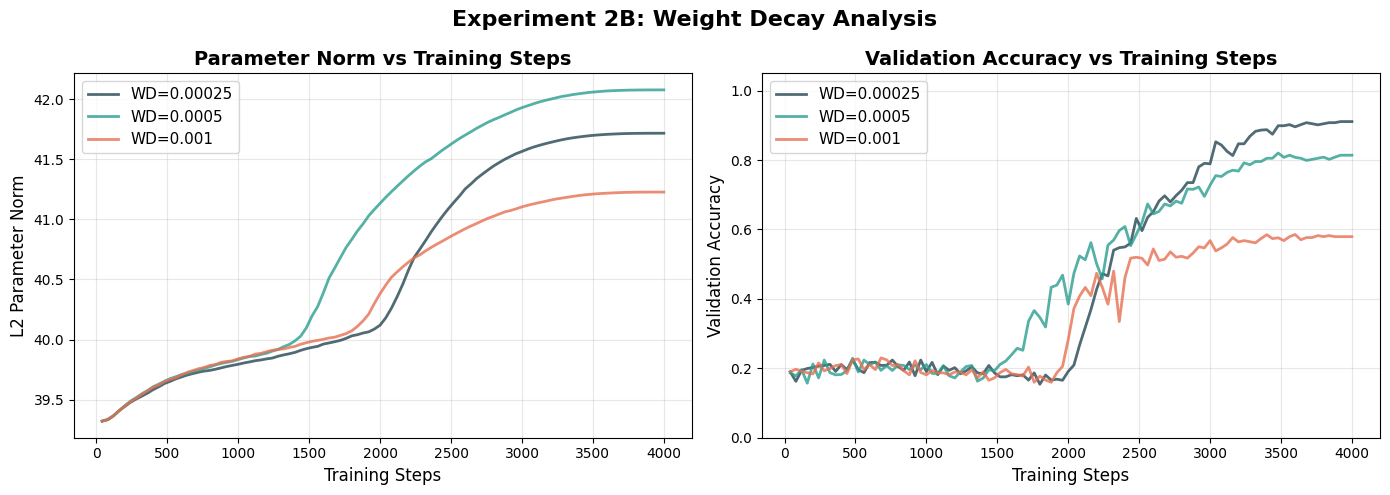


WEIGHT DECAY SUMMARY
Weight Decay       Best Val Acc       Final Param Norm    
------------------------------------------------------------
0.00025            0.9110             41.72               
0.0005             0.8204             42.08               
0.001              0.5856             41.23               


In [29]:
weight_decay_values = [2.5e-4, 5e-4, 1e-3]
weight_decay_histories = {}

for wd in weight_decay_values:
    print(f"\nTraining with weight_decay={wd}")

    config_wd = config.copy()
    config_wd['weight_decay'] = wd
    config_wd['num_epochs'] = 100
    config_wd['track_param_norm'] = True

    model_wd = ModernDecoderLM(
        vocab_size=config_wd['vocab_size'],
        d=config_wd['d'],
        num_layers=config_wd['num_layers'],
        num_heads=config_wd['num_heads'],
        num_kv_groups=config_wd['num_kv_groups'],
        d_ff=config_wd['d_ff'],
        dropout_prob=config_wd['dropout_prob']
    )
    model_wd.apply(init_weights)

    history_wd = train_model(model_wd, train_loader, val_loader, vocab, config_wd, device)
    weight_decay_histories[wd] = history_wd

# Plot parameter norms
print("\nPlotting parameter norms...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors_wd = {2.5e-4: '#264653', 5e-4: '#2A9D8F', 1e-3: '#E76F51'}

# Parameter norms
for wd, history in weight_decay_histories.items():
    if 'param_norms' in history:
        color = colors_wd[wd]
        ax1.plot(history['steps'], history['param_norms'],
                 label=f'WD={wd}', alpha=0.8, linewidth=2, color=color)

ax1.set_xlabel('Training Steps', fontsize=12)
ax1.set_ylabel('L2 Parameter Norm', fontsize=12)
ax1.set_title('Parameter Norm vs Training Steps', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation accuracy
for wd, history in weight_decay_histories.items():
    color = colors_wd[wd]
    ax2.plot(history['steps'], history['val_acc'],
             label=f'WD={wd}', alpha=0.8, linewidth=2, color=color)

ax2.set_xlabel('Training Steps', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy vs Training Steps', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])

plt.suptitle('Experiment 2B: Weight Decay Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('exp2b_weight_decay_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# SOLUTION: Summary table
print("\n" + "="*60)
print("WEIGHT DECAY SUMMARY")
print("="*60)
print(f"{'Weight Decay':<18} {'Best Val Acc':<18} {'Final Param Norm':<20}")
print("-" * 60)
for wd, history in weight_decay_histories.items():
    best_val_acc = max(history['val_acc'])
    final_norm = history['param_norms'][-1] if 'param_norms' in history else 0.0
    print(f"{wd:<18} {best_val_acc:<18.4f} {final_norm:<20.2f}")
print("="*60)

In [30]:
# SOLUTION: Summary table
print("\n" + "="*60)
print("WEIGHT DECAY SUMMARY")
print("="*60)
print(f"{'Weight Decay':<18} {'Best Val Acc':<18} {'Final Param Norm':<20}")
print("-" * 60)
for wd, history in weight_decay_histories.items():
    best_val_acc = max(history['val_acc'])
    final_norm = history['param_norms'][-1] if 'param_norms' in history else 0.0
    print(f"{wd:<18} {best_val_acc:<18.4f} {final_norm:<20.2f}")
print("="*60)


WEIGHT DECAY SUMMARY
Weight Decay       Best Val Acc       Final Param Norm    
------------------------------------------------------------
0.00025            0.9110             41.72               
0.0005             0.8204             42.08               
0.001              0.5856             41.23               


In [31]:
# print("\n" + "="*80)
# print("TODO: Write your discussion in the PDF report [2 points]:")
# print("Address the following questions:")
# print("1. How does weight decay affect parameter norms over training?")
# print("2. Is there a correlation between norm magnitude and validation performance?")
# print("3. What does this suggest about weight decay's role in preventing overfitting?")
# print("4. Which weight decay value provides the best balance?")
# print("="*80 + "\n")

### Section 7: Experiment 3 - Attention Pattern Visualization [6 points]

Loaded best baseline model checkpoint

Generating attention visualizations for all 5 standardized examples...
Note: Using constructed example for binary_add_small


C:\Users\sidne\AppData\Local\Temp\ipykernel_15392\1660490760.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Saved: attention_binary_add_small.png


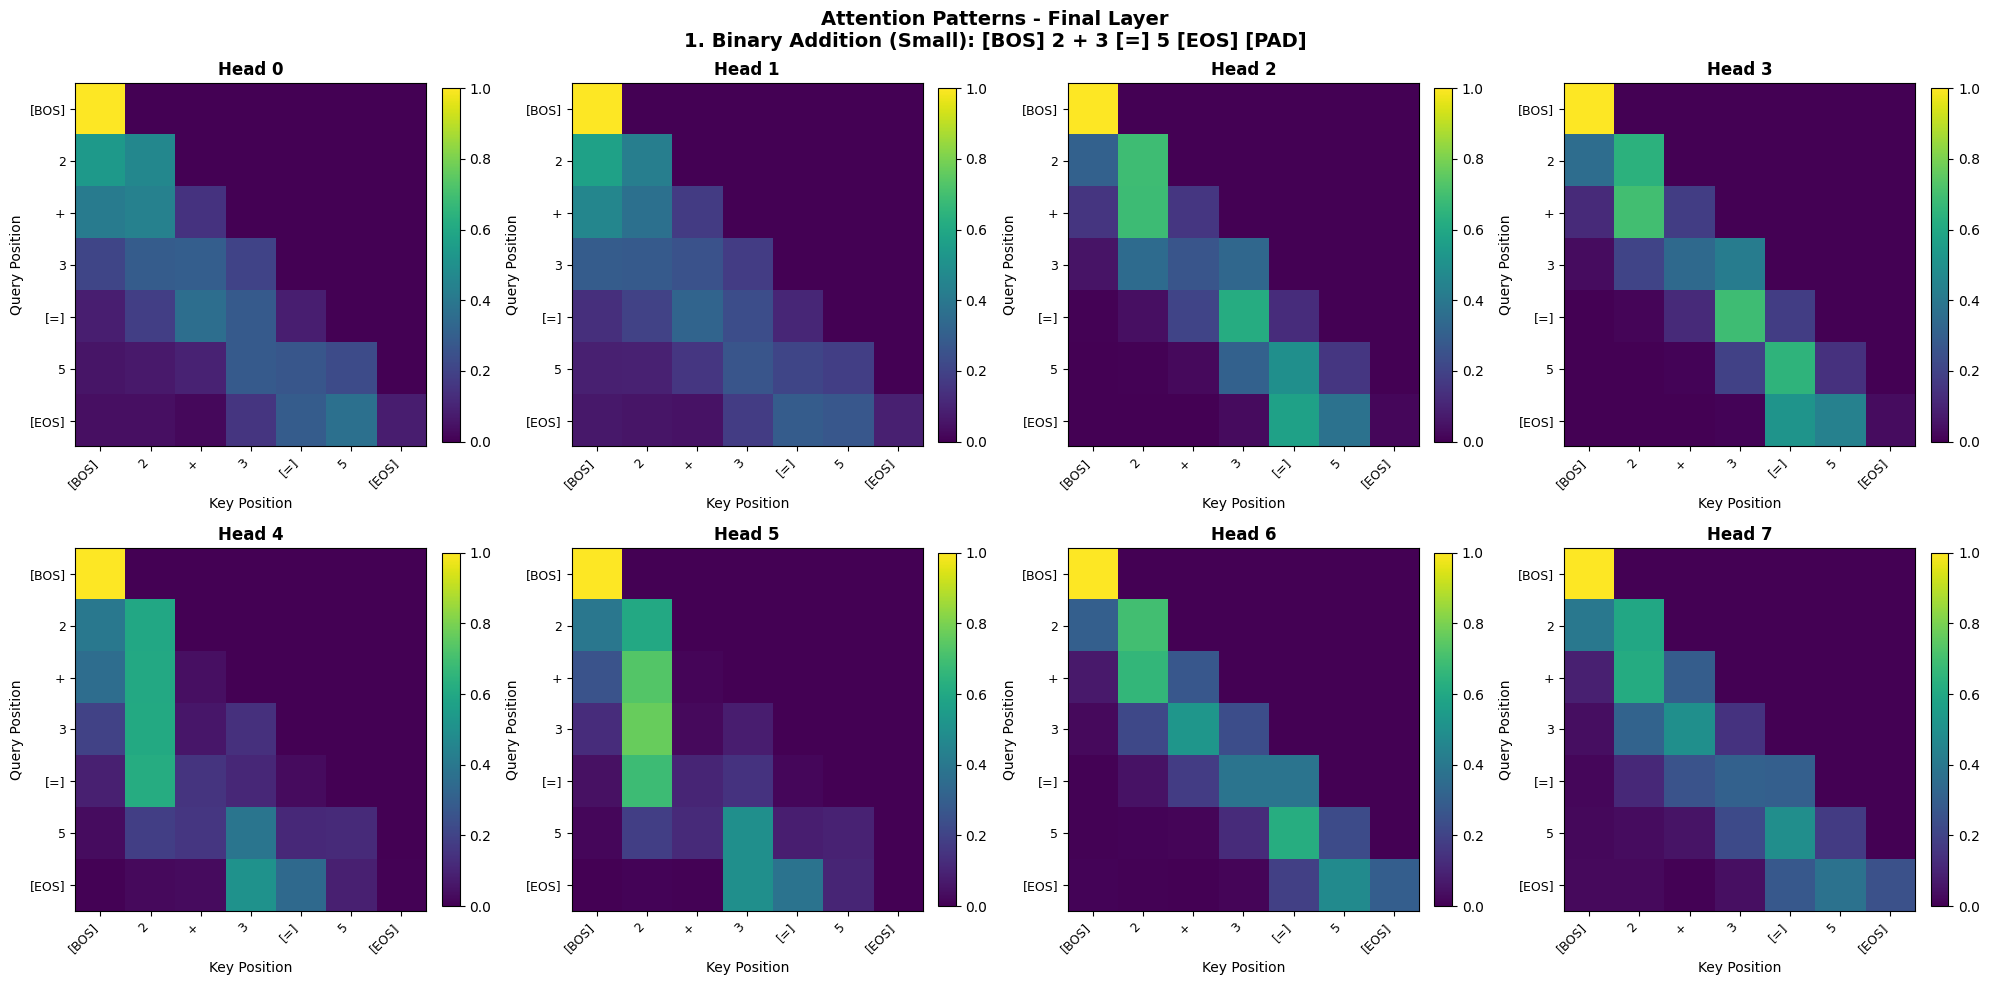


Note: Using constructed example for binary_add_carry
Saved: attention_binary_add_carry.png


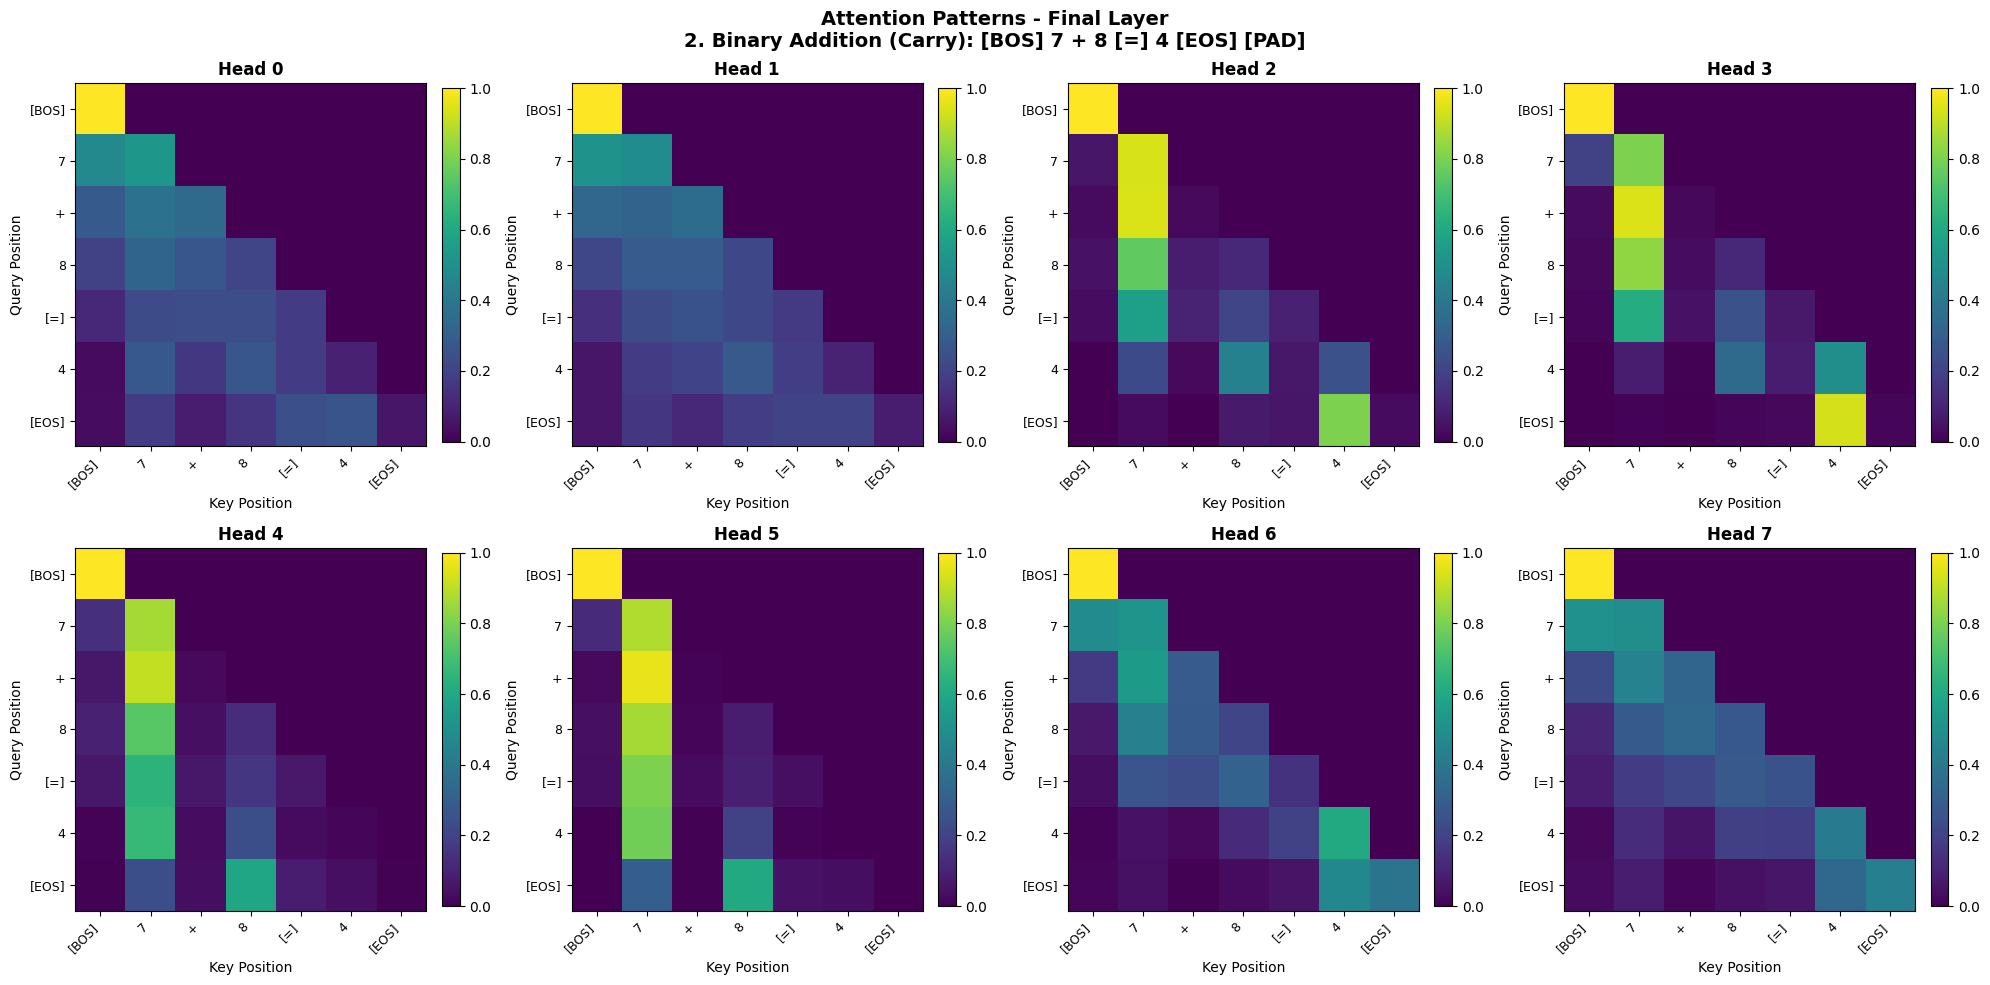


Saved: attention_binary_mult_small.png


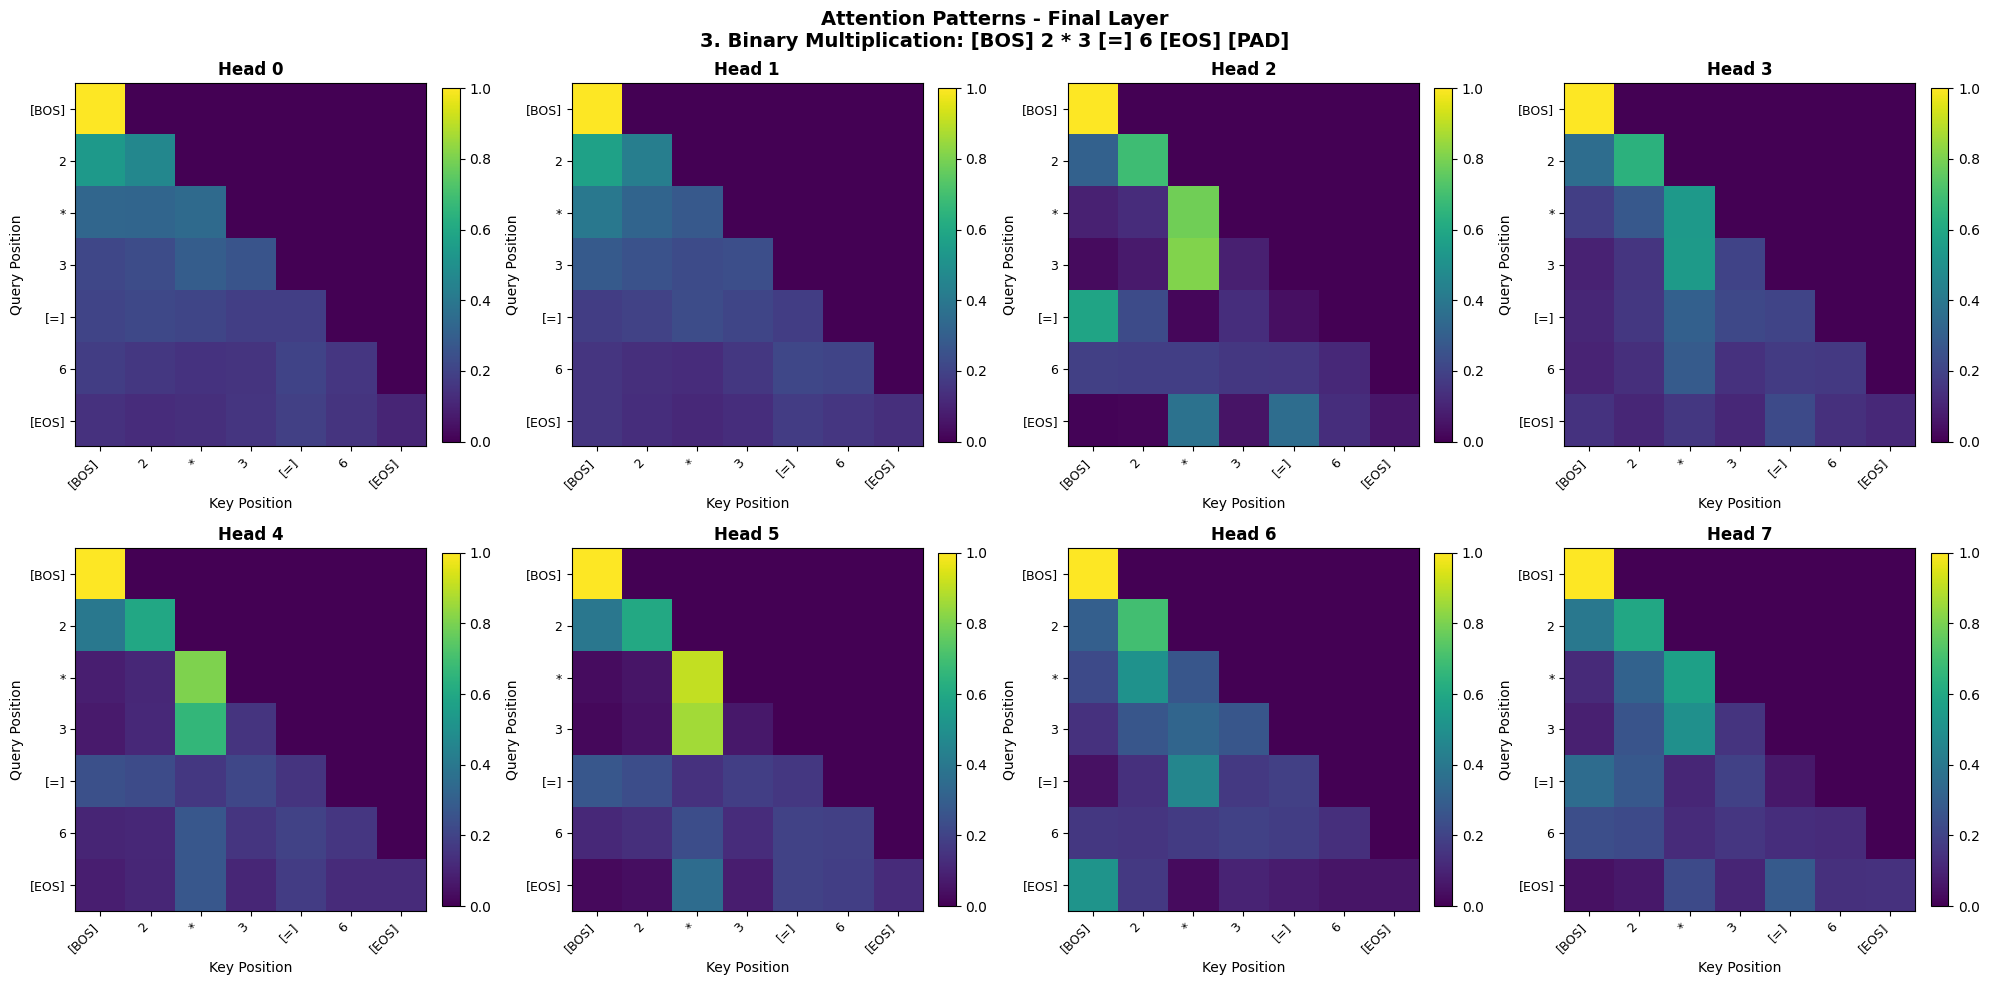


Note: Using constructed example for ternary_add
Saved: attention_ternary_add.png


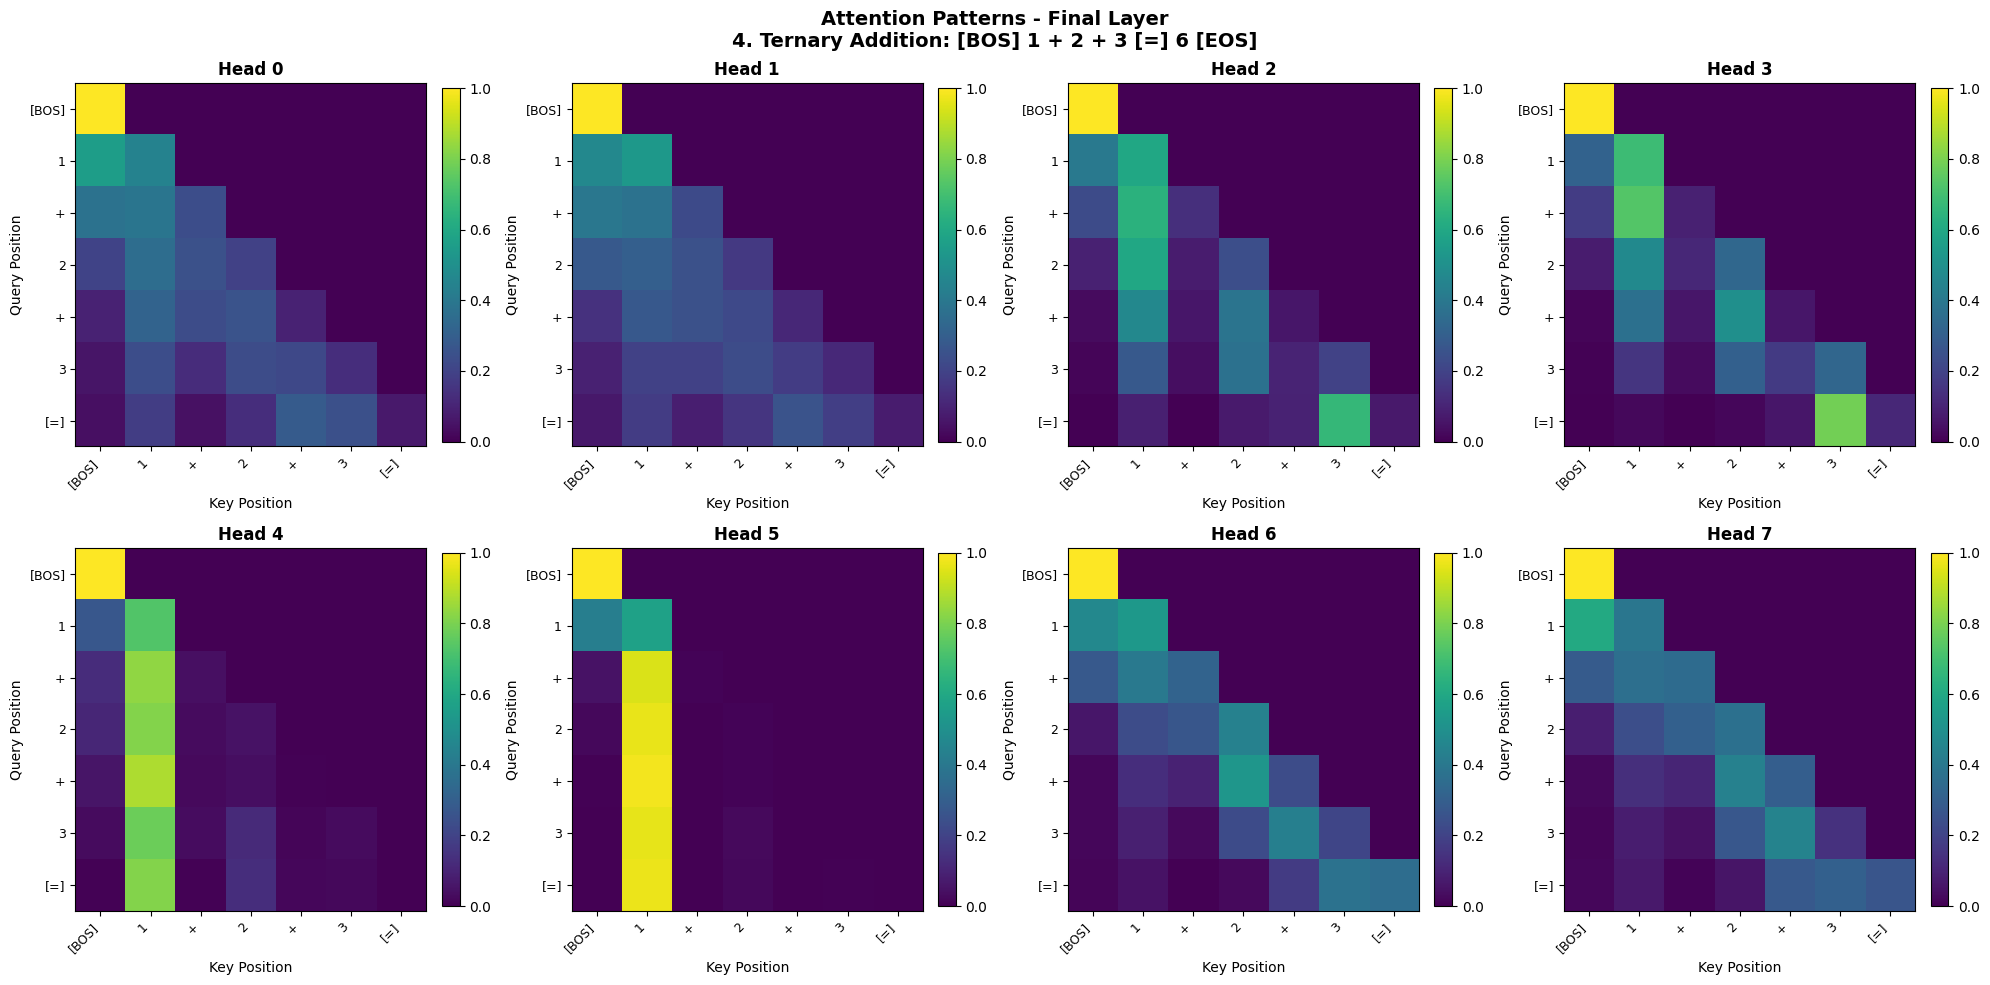


Note: Using constructed example for ternary_mult
Saved: attention_ternary_mult.png


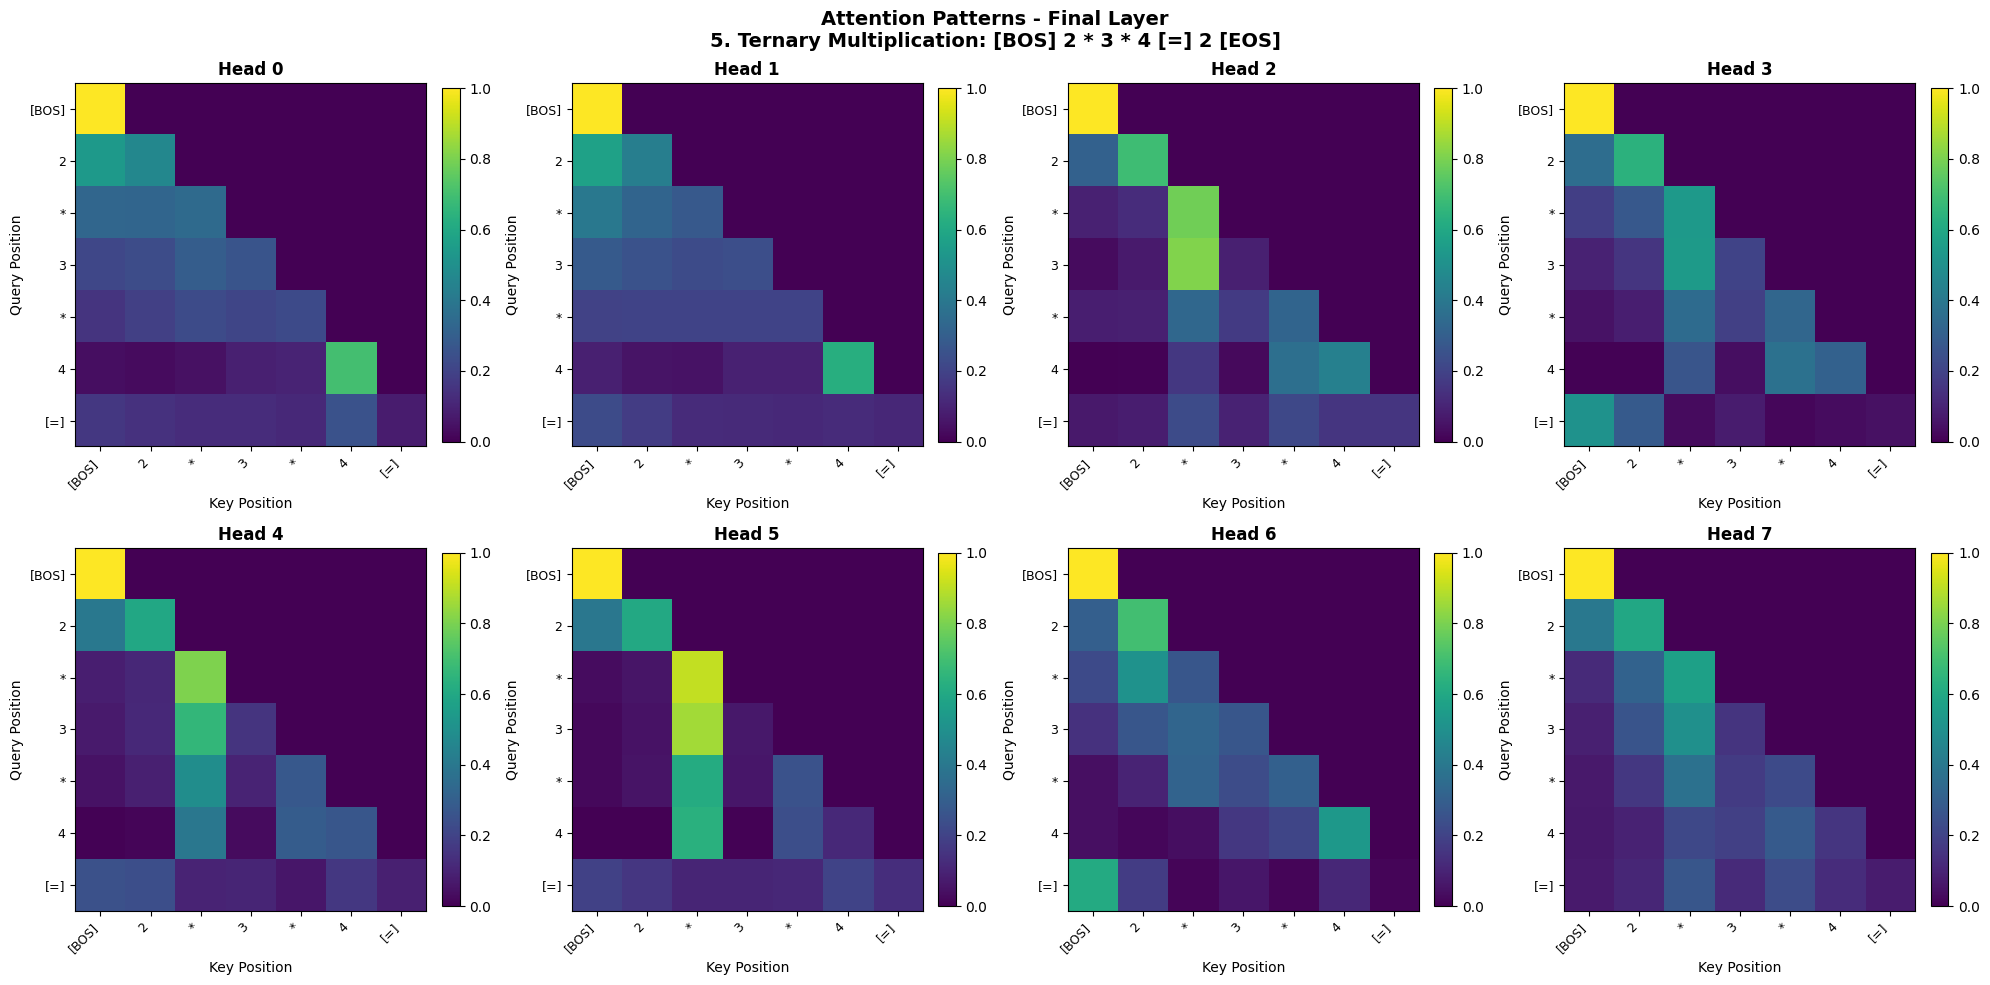

In [32]:
# Load best baseline model
model.load_state_dict(torch.load('best_model.pt'))
model = model.to(device)
model.eval()
print("Loaded best baseline model checkpoint")

print("\nGenerating attention visualizations for all 5 standardized examples...")
visualize_attention_patterns(model, val_inputs, vocab, device)

In [33]:
# print("\n" + "="*80)
# print("TODO: Write your interpretability analysis in the PDF report [3 points]:")
# print("For each of the 5 examples, analyze the attention patterns:")
# print("1. Do tokens after [=] attend back to the operands and operators?")
# print("2. Do different heads exhibit different specializations?")
# print("   (e.g., local vs. global attention, operator-focused vs. operand-focused)")
# print("3. Can you identify any heads that seem to implement specific")
# print("   algorithmic components (e.g., carrying information forward)?")
# print("="*80 + "\n")

## Section 8: Save Results

In [34]:
results = {
    'experiment_1': {
        'history': history_baseline,
        'metrics': metrics_baseline,
        'config': config
    },
    'experiment_2a': {
        'dropout_histories': dropout_histories,
        'dropout_values': dropout_values
    },
    'experiment_2b': {
        'weight_decay_histories': weight_decay_histories,
        'weight_decay_values': weight_decay_values
    },
}

with open('HW2_A25_modern_transformer_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to 'HW2_A25_modern_transformer_results.pkl'")

Results saved to 'HW2_A25_modern_transformer_results.pkl'
